In [74]:
# Parameters
var_list = ["default1", "default2"]
plevel_list = [False, 300]
aew_subset = "default_subset"
model_save_name = "default_model.keras"
tuner_project_name = "default_tuner_run"






In [75]:
# Parameters
var_list = [
    "cape",
    "crr",
    "d",
    "ie",
    "ishf",
    "lsrr",
    "pv",
    "q",
    "q",
    "r",
    "r",
    "sp",
    "sstk",
    "tcw",
    "tcwv",
    "t",
    "t",
    "ttr",
    "u",
    "u",
    "v",
    "v",
    "vo",
    "w",
    "w",
]
plevel_list = [
    False,
    False,
    300,
    False,
    False,
    False,
    300,
    300,
    850,
    300,
    850,
    False,
    False,
    False,
    False,
    300,
    850,
    False,
    300,
    850,
    300,
    850,
    300,
    300,
    850,
]
aew_subset = "12hr_before"
model_save_name = "best_model_var4.keras"
tuner_project_name = "tuner_run(second)1_0"


In [76]:
#!/usr/bin/env python

# coding: utf-8


import numpy as np

import matplotlib.pyplot as plt

import xarray as xr

import sklearn

import sklearn.model_selection

import keras

from keras import layers

import keras_tuner

import tensorflow as tf

import tensorflow.keras.backend as K

keras.utils.set_random_seed(812)

In [77]:
#functions to calculate f1 score as loss function

def f1_loss_sigmoid(y_true, y_pred):
    """

    F1 metric for sigmoid output and integer encoded labels.

"""

    # compute tp, fp, and fn

    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)

    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)

    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)


    # precision (tp / (tp + fp))

    p = tp / (tp + fp + K.epsilon())

   # recall (tp / (tp + fn))

    r = tp / (tp + fn + K.epsilon())


# harmonic mean of precision and recall

    f1 = (2 * p * r) / (p + r + K.epsilon())

    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

    return 1 - K.mean(f1)

In [78]:
def f1_loss_onehot(y_true, y_pred):

   """

   F1 metric for two-class output and one-hot encoded labels.

   """

   # compute tp, fp, and fn

   tp = K.sum(K.cast(y_true[:, 1] * y_pred[:, 1], 'float'), axis=0)

   fp = K.sum(K.cast((1 - y_true[:, 1]) * y_pred[:, 1], 'float'), axis=0)

   fn = K.sum(K.cast(y_true[:, 0] * (1 - y_pred[:, 0]), 'float'), axis=0)


   # precision (tp / (tp + fp))

   p = tp / (tp + fp + K.epsilon())

   # recall (tp / (tp + fn))

   r = tp / (tp + fn + K.epsilon())


   # harmonic mean of precision and recall

   f1 = (2 * p * r) / (p + r + K.epsilon())

   f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

   return 1 - K.mean(f1)

In [79]:
def add_dim(ds):

    """

    Preprocessing help when opening netcdf files

    """
    return ds.assign_coords({"sample": 1}).expand_dims(dim={"sample": 1}).drop_vars('utc_date')


    

In [80]:
import os
import xarray as xr

def open_files_zarr(list_of_vars, aew_subset="12hr_before",
                    directory="/glade/derecho/scratch/rmandava/AEW_time_location_files/",
                    plevel_list=None, zarr_store_path="zarr_data"):
    """
    Opens ERA5 NetCDF files for the given variables. For each variable (or pressure-level variant),
    it checks if a corresponding Zarr store exists in 'zarr_store_path'. If so, it loads the dataset
    from the Zarr store; if not, it opens the NetCDF files, preprocesses them, saves them to Zarr,
    and then returns the dataset.
    """
    # Create the zarr_store_path directory if it doesn't exist.
    if not os.path.exists(zarr_store_path):
        os.makedirs(zarr_store_path)
    
    datas = {}
    for num, var in enumerate(list_of_vars):
        # Determine the key and filename based on whether a pressure level is specified.
        if plevel_list:
            if plevel_list[num]:
                key = f"{var}_{int(plevel_list[num])}"
                file_pattern = f'{directory}/{var}/aew_{aew_subset}_{int(plevel_list[num])}_*.nc'
            else:
                key = var
                file_pattern = f'{directory}/{var}/aew_{aew_subset}_*.nc'
        else:
            key = var
            file_pattern = f'{directory}/{var}/aew_{aew_subset}_*.nc'
        
        # Define the zarr path for this variable.
        zarr_path = os.path.join(zarr_store_path, f"{key}.zarr")
        
        # If the Zarr dataset exists, load from it; otherwise, create it.
        if os.path.exists(zarr_path):
            print(f"Loading {key} from Zarr store.")
            ds = xr.open_zarr(zarr_path)
        else:
            print(f"Creating Zarr store for {key} from NetCDF files.")
            ds = xr.open_mfdataset(
                file_pattern,
                preprocess=add_dim,
                concat_dim="sample",
                combine="nested",
            )
            ds.to_zarr(zarr_path, mode="w")
        datas[key] = ds
    
    return datas


In [48]:
def transpose_load_concat(data_dictionary):
    thedatas = {}
    for key, value in data_dictionary.items():
        if '_' not in key:
            thedatas[key] = value[key.upper()].expand_dims('features').transpose(
                'sample', 'latitude', 'longitude', 'features').values
        else:
            thedatas[key] = value[key.split('_')[0].upper()].expand_dims('features').transpose(
                'sample', 'latitude', 'longitude', 'features').values

    # Get labels from one of the datasets (adjust if necessary)
    label = list(data_dictionary.values())[0]['label'].values

    # First, build the data array
    if len(data_dictionary) > 1:
        data = np.concatenate(list(thedatas.values()), axis=3)
    elif len(data_dictionary) == 1:
        data = np.squeeze(np.asarray(list(thedatas.values())), axis=0)
    
    # Now that 'data' is defined, get the number of samples
    n_samples = data.shape[0]
    
    # Extract grid-level coordinates from the first dataset
    first_key = list(data_dictionary.keys())[0]
    lats = data_dictionary[first_key]['latitude'].values  # e.g., shape (32,)
    lons = data_dictionary[first_key]['longitude'].values   # e.g., shape (32,)
    
    # Choose a representative value (e.g., the central value)
    central_lat = lats[len(lats) // 2]
    central_lon = lons[len(lons) // 2]
    
    # Create per-sample coordinate arrays with one value per sample
    sample_lat = np.full((n_samples,), central_lat)
    sample_lon = np.full((n_samples,), central_lon)
    
    # Return the data, labels, and per-sample coordinate arrays
    return data, label, sample_lat, sample_lon


In [81]:
def transpose_load_concat(data_dictionary):
    # Build the data arrays for each variable
    thedatas = {}
    for key, value in data_dictionary.items():
        if '_' not in key:
            thedatas[key] = value[key.upper()].expand_dims('features').transpose(
                'sample', 'latitude', 'longitude', 'features').values
        else:
            thedatas[key] = value[key.split('_')[0].upper()].expand_dims('features').transpose(
                'sample', 'latitude', 'longitude', 'features').values

    # Get labels from one of the datasets (adjust if necessary)
    label = list(data_dictionary.values())[0]['label'].values

    # Concatenate the data along the features dimension
    if len(data_dictionary) > 1:
        data = np.concatenate(list(thedatas.values()), axis=3)
    elif len(data_dictionary) == 1:
        data = np.squeeze(np.asarray(list(thedatas.values())), axis=0)
    
    # Determine number of samples
    n_samples = data.shape[0]
    
    # Extract grid-level coordinate vectors from the first dataset
    first_key = list(data_dictionary.keys())[0]
    lats = data_dictionary[first_key]['latitude'].values  # e.g., shape (32,)
    lons = data_dictionary[first_key]['longitude'].values   # e.g., shape (32,)
    
    # Create 2D grid coordinate arrays using meshgrid.
    # The 'indexing' parameter 'ij' means that the first dimension corresponds to latitudes.
    grid_lats, grid_lons = np.meshgrid(lats, lons, indexing='ij')  # both shape (32, 32)
    
    # Initialize arrays to hold per-sample centroids
    sample_lat = np.empty(n_samples)
    sample_lon = np.empty(n_samples)
    
    # Compute a weighted centroid for each sample using the first channel (index 0) as weights.
    eps = 1e-8  # small epsilon to avoid division by zero
    for i in range(n_samples):
        # Extract the grid from the sample for the first feature channel.
        # Adjust this if a different channel or weighting scheme is desired.
        sample_grid = data[i, :, :, 0]  # shape (32, 32)
        weight = sample_grid + eps  # add epsilon
        total_weight = np.sum(weight)
        sample_lat[i] = np.sum(grid_lats * weight) / total_weight
        sample_lon[i] = np.sum(grid_lons * weight) / total_weight
    
    return data, label, sample_lat, sample_lon


In [82]:
def omit_nans(data, label, lat, lon):
    """
    Remove any nans from the data and apply the same mask to labels and coordinates.
    
    Args:
      data (numpy array): Training data.
      label (numpy array): Labels.
      lat (numpy array): Latitude array for each sample.
      lon (numpy array): Longitude array for each sample.
    
    Returns:
      traindata, trainlabel, lat_filtered, lon_filtered
    """
    maskarray = np.full(data.shape[0], True)
    # Find sample indices that have NaNs
    masker = np.unique(np.argwhere(np.isnan(data))[:, 0])
    maskarray[masker] = False

    traindata = data[maskarray, :, :, :]
    trainlabel = label[maskarray]
    lat_filtered = lat[maskarray]
    lon_filtered = lon[maskarray]
    
    return traindata, trainlabel, lat_filtered, lon_filtered


In [83]:
def zscore(data):

  """

  Rescaling the data using zscore (mean/std).

  Each variable gets scaled independently from others.

  Note that we will need to remove test data for formal training.

  """

  for i in range(0, data_.shape[-1]):

      data_[:, :, :, i] = (

               data_[:, :, :, i] - np.nanmean(

                     data_[:, :, :, i])) / np.nanstd(data_[:, :, :, i])

  return data_

In [84]:
def minmax(data):

   """

   Rescaling the data using min-max.

   Each variable gets scaled independently from others.

   Note that we will need to remove test data for formal training.

   """

   for i in range(0, data_.shape[-1]):

          data_[:, :, :, i] = (

              data_[:, :, :, i] - np.nanmin(data_[:, :, :, i])

          ) / (np.nanmax(data_[:, :, :, i]) - np.nanmin(data_[:, :, :, i]))
   return data

In [85]:
def random_split(data, label, split=0.3, seed=0):

   """

   Help spliting data randomly for training and testing.

   """

   np.random.seed(0)

   da_indx = np.random.permutation(data.shape[0])

   data = data[da_indx.astype(int)]

   label = label[da_indx.astype(int)]

   init_range = int(data.shape[0] * (1 - 0.3))

   return data[:init_range], label[:init_range], data[init_range:], label[init_range:]

In [86]:
def pick_loss(loss_string):

   """

   Help selecting the activation functions

   """

   lossdict = {

           "relu": keras.activations.relu,

           "tanh": keras.activations.tanh,

           "selu": keras.activations.selu,

           "sigmoid": keras.activations.sigmoid,

           "relu6": keras.activations.relu6,

           "silu": keras.activations.silu,

           "gelu": keras.activations.gelu,

           "lrelu": keras.activations.leaky_relu,

   }

   return lossdict[loss_string]

In [87]:
number_of_features = len(var_list)

In [88]:
data = open_files_zarr(
    list_of_vars=var_list,
    aew_subset=aew_subset,
    directory="/glade/derecho/scratch/rmandava/AEW_time_location_files/",
    plevel_list=plevel_list,
    zarr_store_path="/glade/derecho/scratch/rmandava/AEW_time_location_files/project/zarr"
)






Loading cape from Zarr store.
Loading crr from Zarr store.
Loading d_300 from Zarr store.
Loading ie from Zarr store.
Loading ishf from Zarr store.
Loading lsrr from Zarr store.
Loading pv_300 from Zarr store.
Loading q_300 from Zarr store.
Loading q_850 from Zarr store.
Loading r_300 from Zarr store.
Loading r_850 from Zarr store.
Loading sp from Zarr store.
Loading sstk from Zarr store.
Loading tcw from Zarr store.
Loading tcwv from Zarr store.
Loading t_300 from Zarr store.
Loading t_850 from Zarr store.
Loading ttr from Zarr store.
Loading u_300 from Zarr store.
Loading u_850 from Zarr store.
Loading v_300 from Zarr store.
Loading v_850 from Zarr store.
Loading vo_300 from Zarr store.
Loading w_300 from Zarr store.
Loading w_850 from Zarr store.


In [89]:
print(data['cape'])


<xarray.Dataset> Size: 11MB
Dimensions:  (sample: 2750, latitude: 32, longitude: 32)
Coordinates:
  * sample   (sample) int64 22kB 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    time     (sample) datetime64[ns] 22kB dask.array<chunksize=(2750,), meta=np.ndarray>
Dimensions without coordinates: latitude, longitude
Data variables:
    CAPE     (sample, latitude, longitude) float32 11MB dask.array<chunksize=(1, 32, 32), meta=np.ndarray>
    label    (sample) float64 22kB dask.array<chunksize=(2750,), meta=np.ndarray>
Attributes:
    CONVERSION_DATE:      Thu May 16 09:28:20 MDT 2019
    CONVERSION_PLATFORM:  Linux r2i5n6 3.12.62-60.64.8-default #1 SMP Tue Oct...
    Conventions:          CF-1.6
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NCO:                  netCDF Operators version 4.7.4 (http://nco.sf.net)
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECM

In [90]:
# transpose the data and concat variables

#data_, labels_ = transpose_load_concat(data)
data_, labels_, sample_lat, sample_lon = transpose_load_concat(data)

print(np.shape(data_))

(2750, 32, 32, 25)


In [91]:
# check / remove nans

data_, labels_, sample_lat, sample_lon = omit_nans(data_, labels_, sample_lat, sample_lon)






In [92]:
#split train and test set
X_train, X_test, y_train, y_test, lat_train, lat_test, lon_train, lon_test = sklearn.model_selection.train_test_split(
    data_, labels_, sample_lat, sample_lon, test_size=0.2, random_state=42)



print (np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test))


y_train = np.expand_dims(y_train, axis=1)

y_test = np.expand_dims(y_test, axis=1)

(560, 32, 32, 25) (140, 32, 32, 25) (560,) (140,)


In [93]:
# now rescale using sklearn object

# create our scaler object

# scaler_input = sklearn.preprocessing.MinMaxScaler()

#Zscore scaling

scaler_input = sklearn.preprocessing.StandardScaler()


# now fit and transform our input data and labels

# training data

# inputs

X_train_tmp = np.reshape(X_train, (-1, len(var_list)))

input_train_scaled = scaler_input.fit_transform(X_train_tmp)

input_train_scaled = np.reshape(input_train_scaled, X_train.shape)

# labels

label_train_scaled = y_train


# testing data

# inputs

X_test_tmp = np.reshape(X_test, (-1, len(var_list)))

input_test_scaled = scaler_input.fit_transform(X_test_tmp)

input_test_scaled = np.reshape(input_test_scaled, X_test.shape)

# labels

label_test_scaled = y_test

In [94]:
# print the shapes to double check them

print(

input_train_scaled.shape,

label_train_scaled.shape,

input_test_scaled.shape,

label_test_scaled.shape

)

(560, 32, 32, 25) (560, 1) (140, 32, 32, 25) (140, 1)


In [95]:
#generate class weights due to class imbalance issues

counts = np.bincount(y_train[:, 0].astype(int))


print(

"Number of positive samples in training data: {} ({:.2f}% of total)".format(

counts[1], 100 * float(counts[1]) / len(y_train))

)

Number of positive samples in training data: 91 (16.25% of total)


In [96]:
# old weights

# weight_for_0 = 1.0 / counts[0]

# weight_for_1 = 1.0 / counts[1]


#new weights

weight_for_0 = float(counts[1]) / len(y_train)

weight_for_1 = 1 - (float(counts[1]) / len(y_train))


class_weight = {0: weight_for_0, 1: weight_for_1}

print(class_weight)

{0: 0.1625, 1: 0.8375}


In [97]:
METRICS = [

keras.metrics.BinaryCrossentropy(name='cross entropy'),

keras.metrics.MeanSquaredError(name='mean_squared_error'),

keras.metrics.RootMeanSquaredError(name='root_mean_squared_error'),

keras.metrics.TruePositives(name='tp'),

keras.metrics.FalsePositives(name='fp'),

keras.metrics.TrueNegatives(name='tn'),

keras.metrics.FalseNegatives(name='fn'),

keras.metrics.BinaryAccuracy(name='binary_accuracy'),

keras.metrics.F1Score(threshold=0.5, name='f1_score'),

keras.metrics.Precision(name='precision'),

keras.metrics.Recall(name='recall'),

keras.metrics.AUC(name='auc'),

keras.metrics.AUC(name='prc', curve='PR'),

]

In [98]:
# Build CNN using keras-tuner

class MyHyperModel(keras_tuner.HyperModel):
    def build(self, hp):
        # start building model
        model = keras.Sequential()

        # input
        model.add(keras.Input(shape=(32, 32, number_of_features)))  # 32x32 images

        # data augmentation layers
        model.add(layers.RandomFlip("horizontal_and_vertical"))
        model.add(layers.RandomRotation(factor=(-0.5, 0.5)))

        # things to tune
        featmaps1 = hp.Int('units_1', min_value=10, max_value=60)
        featmaps2 = hp.Int('units_2', min_value=10, max_value=64)
        featmaps3 = hp.Int('units_3', min_value=10, max_value=128)
        featmaps4 = hp.Int('units_4', min_value=10, max_value=80)
        learning_rate = hp.Float("lr", min_value=0.00001, max_value=0.01, sampling="linear")
        act_func = hp.Choice(
            "activation",
            ["relu", "tanh", "selu", "sigmoid", "relu6", "silu", "gelu"]
        )

        # hidden layers
        model.add(layers.Conv2D(featmaps1, 3, strides=1, padding="same", activation=pick_loss(act_func)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Dropout(0.2))

        model.add(layers.Conv2D(featmaps2, 3, strides=1, padding="same", activation=pick_loss(act_func)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Dropout(0.2))

        model.add(layers.Conv2D(featmaps3, 3, strides=1, padding="same", activation=pick_loss(act_func)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Dropout(0.2))

        # Now that we have 4x4 feature maps, now apply global max pooling.
        model.add(layers.GlobalMaxPooling2D())

        # Finally, we add last fully connected (dense) layers
        model.add(layers.Dense(featmaps4))
        model.add(layers.Dense(1, activation="sigmoid"))

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss=f1_loss_sigmoid,
            metrics=METRICS
        )
        return model


In [99]:
def fit(self, hp, model, *args, **kwargs):
    batchsizenum = hp.Int('batch_size', min_value=10, max_value=60, step=5, sampling="linear")

    print({k: hp.get(k) if hp.is_active(k) else None for k in hp._hps})

    return model.fit(
        *args,
        batch_size=batchsizenum,
        # normally we might use early stopping, but not needed since
        # callbacks saves checkpoints of the model during trials
        # callbacks=keras.callbacks.EarlyStopping('val_loss', patience=5),
        validation_split=0.1,
        shuffle=True,
        class_weight=class_weight,
        **kwargs,
    )


In [100]:
# make the tuner object
tuner = keras_tuner.BayesianOptimization(
    hypermodel=MyHyperModel(),
    objective=keras_tuner.Objective("val_mean_squared_error", direction="min"),
    max_trials=5,
    project_name=tuner_project_name,    # Use the passed parameter
    alpha=0.0001,
    beta=2.6,
    seed=123,
    tune_new_entries=True,
    allow_new_entries=True,
    max_retries_per_trial=1,
    max_consecutive_failed_trials=3,
    overwrite=True
)

# summary
tuner.search_space_summary()


Search space summary
Default search space size: 6
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 60, 'step': 1, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 64, 'step': 1, 'sampling': 'linear'}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 128, 'step': 1, 'sampling': 'linear'}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 80, 'step': 1, 'sampling': 'linear'}
lr (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'selu', 'sigmoid', 'relu6', 'silu', 'gelu'], 'ordered': False}


In [101]:
# Begin the search
EPOCHS = 100

tuner.search(
    input_train_scaled,
    label_train_scaled,
    epochs=EPOCHS,
    validation_split=0.1
)

# Query the tuner object to grab the best models
models = tuner.get_best_models(num_models=5)

# Here is the best model from the tuner
best_model = models[0]
print(best_model.summary())

# Get the top hyperparameters.
best_hps = tuner.get_best_hyperparameters()

# Build the model with the best hyperparameters.
# Assuming your MyHyperModel has a build method that takes a hyperparameter object.
model = MyHyperModel().build(best_hps[0])

# Save the best model (architecture and weights)

save_dir = "/glade/derecho/scratch/rmandava/AEW_time_location_files/models"
model_save_path = os.path.join(save_dir, model_save_name)

model.save(model_save_path)


# Retrain using "best" model hyperparameters
history = model.fit(
    input_train_scaled,
    label_train_scaled,
    epochs=EPOCHS,
    validation_split=0.1,
    batch_size= 32,
    # callbacks=keras.callbacks.EarlyStopping('val_loss', patience=3),
    shuffle=True,
    class_weight=class_weight,  # Ensure 'class_weight' is defined in your scope
)

# Evaluate the model on the test data using `evaluate`
results = model.evaluate(input_test_scaled, label_test_scaled, batch_size=label_test_scaled.shape[0])
print(results)

# Generate predictions (probabilities—the output of the last layer)
predictions = model.predict(input_test_scaled)
print("predictions shape:", predictions.shape)

# Compute confusion matrix elements
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(
    label_test_scaled, np.round(predictions)
).ravel()
print("tn:", tn)
print("fp:", fp)
print("fn:", fn)
print("tp:", tp)


Trial 5 Complete [00h 00m 44s]
val_mean_squared_error: 0.1071428582072258

Best val_mean_squared_error So Far: 0.05929948762059212
Total elapsed time: 00h 03m 31s


/glade/u/home/rmandava/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 32, 32, 25)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 32, 32, 25)     │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 12)     │         2,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 62)     │         6,758 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 62)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 62)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 117)      │        65,403 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 117)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 117)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 117)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         5,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,824 (315.72 KB)

 Trainable params: 80,824 (315.72 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - auc: 0.5522 - binary_accuracy: 0.3576 - cross entropy: 110.3926 - f1_score: 0.2875 - fn: 9.0000 - fp: 226.8235 - loss: 0.2021 - mean_squared_error: 0.5236 - prc: 0.2002 - precision: 0.1781 - recall: 0.7809 - root_mean_squared_error: 0.7159 - tn: 57.0000 - tp: 48.3529 - val_auc: 0.6983 - val_binary_accuracy: 0.1071 - val_cross entropy: 3.2650 - val_f1_score: 0.1935 - val_fn: 0.0000e+00 - val_fp: 50.0000 - val_loss: 0.7904 - val_mean_squared_error: 0.6929 - val_prc: 0.1741 - val_precision: 0.1071 - val_recall: 1.0000 - val_root_mean_squared_error: 0.8324 - val_tn: 0.0000e+00 - val_tp: 6.0000
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - auc: 0.7373 - binary_accuracy: 0.2477 - cross entropy: 4.6255 - f1_score: 0.3315 - fn: 0.0000e+00 - fp: 207.0000 - loss: 0.1882 - mean_squared_error: 0.6701 - prc: 0.3119 - precision: 0.1989 - recall: 1.0000 - root_mean_squared_error: 0.8175 - tn: 26.8235 - tp: 51.3529 - val_auc: 0.7167 - 

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - auc: 0.5992 - binary_accuracy: 0.4679 - cross entropy: 129.4578 - f1_score: 0.3226 - fn: 6.0000 - fp: 88.0000 - loss: 0.2024 - mean_squared_error: 0.3405 - prc: 0.2490 - precision: 0.2063 - recall: 0.7453 - root_mean_squared_error: 0.5779 - tn: 50.0000 - tp: 24.0000

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - auc: 0.5675 - binary_accuracy: 0.4160 - cross entropy: 107.4688 - f1_score: 0.3167 - fn: 6.0000 - fp: 128.3333 - loss: 0.2007 - mean_squared_error: 0.4095 - prc: 0.2235 - precision: 0.1990 - recall: 0.7923 - root_mean_squared_error: 0.6318 - tn: 50.0000 - tp: 31.6667

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - auc: 0.5521 - binary_accuracy: 0.3810 - cross entropy: 92.9434 - f1_score: 0.3118 - fn: 6.0000 - fp: 168.6667 - loss: 0.1996 - mean_squared_error: 0.4605 - prc: 0.2148 - precision: 0.1936 - recall: 0.8222 - root_mean_squared_error: 0.6697 - tn: 50.0000 - tp: 39.3333 

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - auc: 0.5420 - binary_accuracy: 0.3552 - cross entropy: 82.5189 - f1_score: 0.3074 - fn: 6.0000 - fp: 209.1333 - loss: 0.1988 - mean_squared_error: 0.4998 - prc: 0.2058 - precision: 0.1892 - recall: 0.8433 - root_mean_squared_error: 0.6979 - tn: 50.0000 - tp: 46.8667

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - auc: 0.5367 - binary_accuracy: 0.3418 - cross entropy: 77.1845 - f1_score: 0.3049 - fn: 6.0000 - fp: 233.8235 - loss: 0.1984 - mean_squared_error: 0.5207 - prc: 0.2008 - precision: 0.1868 - recall: 0.8539 - root_mean_squared_error: 0.7126 - tn: 50.0000 - tp: 51.3529 - val_auc: 0.5300 - val_binary_accuracy: 0.1071 - val_cross entropy: 4.3718 - val_f1_score: 0.1935 - val_fn: 0.0000e+00 - val_fp: 50.0000 - val_loss: 0.8072 - val_mean_squared_error: 0.8795 - val_prc: 0.1132 - val_precision: 0.1071 - val_recall: 1.0000 - val_root_mean_squared_error: 0.9378 - val_tn: 0.0000e+00 - val_tp: 6.0000


Epoch 2/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - auc: 0.5000 - binary_accuracy: 0.1562 - cross entropy: 5.4094 - f1_score: 0.2703 - fn: 0.0000e+00 - fp: 27.0000 - loss: 0.1955 - mean_squared_error: 0.8409 - prc: 0.1562 - precision: 0.1562 - recall: 1.0000 - root_mean_squared_error: 0.9170 - tn: 0.0000e+00 - tp: 5.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.5000 - binary_accuracy: 0.2012 - cross entropy: 5.2026 - f1_score: 0.3341 - fn: 0.0000e+00 - fp: 63.0000 - loss: 0.1971 - mean_squared_error: 0.7964 - prc: 0.2012 - precision: 0.2012 - recall: 1.0000 - root_mean_squared_error: 0.8923 - tn: 0.0000e+00 - tp: 17.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.5000 - binary_accuracy: 0.2049 - cross entropy: 5.2595 - f1_score: 0.3396 - fn: 0.0000e+00 - fp: 101.1429 - loss: 0.1971 - mean_squared_error: 0.7929 - prc: 0.2049 - precision: 0.2049 - recall: 1.0000 - root_mean_squared_error: 0.8903 - tn: 0.0000e+00 - tp: 26.8571

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.5000 - binary_accuracy: 0.1953 - cross entropy: 5.4187 - f1_score: 0.3262 - fn: 0.0000e+00 - fp: 155.1818 - loss: 0.1960 - mean_squared_error: 0.8027 - prc: 0.1953 - precision: 0.1953 - recall: 1.0000 - root_mean_squared_error: 0.8958 - tn: 0.0000e+00 - tp: 36.8182

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.5000 - binary_accuracy: 0.1892 - cross entropy: 5.5418 - f1_score: 0.3177 - fn: 0.0000e+00 - fp: 209.1333 - loss: 0.1955 - mean_squared_error: 0.8089 - prc: 0.1892 - precision: 0.1892 - recall: 1.0000 - root_mean_squared_error: 0.8993 - tn: 0.0000e+00 - tp: 46.8667

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - auc: 0.5000 - binary_accuracy: 0.1868 - cross entropy: 5.5934 - f1_score: 0.3143 - fn: 0.0000e+00 - fp: 233.8235 - loss: 0.1954 - mean_squared_error: 0.8114 - prc: 0.1868 - precision: 0.1868 - recall: 1.0000 - root_mean_squared_error: 0.9007 - tn: 0.0000e+00 - tp: 51.3529 - val_auc: 0.5000 - val_binary_accuracy: 0.1071 - val_cross entropy: 5.3225 - val_f1_score: 0.1935 - val_fn: 0.0000e+00 - val_fp: 50.0000 - val_loss: 0.8071 - val_mean_squared_error: 0.8882 - val_prc: 0.1071 - val_precision: 0.1071 - val_recall: 1.0000 - val_root_mean_squared_error: 0.9424 - val_tn: 0.0000e+00 - val_tp: 6.0000


Epoch 3/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - auc: 0.5000 - binary_accuracy: 0.1562 - cross entropy: 6.5039 - f1_score: 0.2703 - fn: 0.0000e+00 - fp: 27.0000 - loss: 0.1955 - mean_squared_error: 0.8430 - prc: 0.1562 - precision: 0.1562 - recall: 1.0000 - root_mean_squared_error: 0.9181 - tn: 0.0000e+00 - tp: 5.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - auc: 0.5000 - binary_accuracy: 0.2012 - cross entropy: 6.1789 - f1_score: 0.3341 - fn: 0.0000e+00 - fp: 63.0000 - loss: 0.1971 - mean_squared_error: 0.7981 - prc: 0.2012 - precision: 0.2012 - recall: 1.0000 - root_mean_squared_error: 0.8932 - tn: 0.0000e+00 - tp: 17.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.5000 - binary_accuracy: 0.2049 - cross entropy: 6.1717 - f1_score: 0.3396 - fn: 0.0000e+00 - fp: 101.1429 - loss: 0.1971 - mean_squared_error: 0.7944 - prc: 0.2049 - precision: 0.2049 - recall: 1.0000 - root_mean_squared_error: 0.8912 - tn: 0.0000e+00 - tp: 26.8571

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.5000 - binary_accuracy: 0.1972 - cross entropy: 6.2483 - f1_score: 0.3289 - fn: 0.0000e+00 - fp: 141.7000 - loss: 0.1962 - mean_squared_error: 0.8021 - prc: 0.1972 - precision: 0.1972 - recall: 1.0000 - root_mean_squared_error: 0.8955 - tn: 0.0000e+00 - tp: 34.3000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.5000 - binary_accuracy: 0.1918 - cross entropy: 6.3062 - f1_score: 0.3213 - fn: 0.0000e+00 - fp: 182.2308 - loss: 0.1957 - mean_squared_error: 0.8075 - prc: 0.1918 - precision: 0.1918 - recall: 1.0000 - root_mean_squared_error: 0.8985 - tn: 0.0000e+00 - tp: 41.7692

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.5000 - binary_accuracy: 0.1879 - cross entropy: 6.3508 - f1_score: 0.3159 - fn: 0.0000e+00 - fp: 222.2500 - loss: 0.1954 - mean_squared_error: 0.8114 - prc: 0.1879 - precision: 0.1879 - recall: 1.0000 - root_mean_squared_error: 0.9007 - tn: 0.0000e+00 - tp: 49.2500

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - auc: 0.5000 - binary_accuracy: 0.1868 - cross entropy: 6.3638 - f1_score: 0.3143 - fn: 0.0000e+00 - fp: 233.8235 - loss: 0.1954 - mean_squared_error: 0.8125 - prc: 0.1868 - precision: 0.1868 - recall: 1.0000 - root_mean_squared_error: 0.9013 - tn: 0.0000e+00 - tp: 51.3529 - val_auc: 0.5000 - val_binary_accuracy: 0.1071 - val_cross entropy: 5.5360 - val_f1_score: 0.1935 - val_fn: 0.0000e+00 - val_fp: 50.0000 - val_loss: 0.8071 - val_mean_squared_error: 0.8892 - val_prc: 0.1071 - val_precision: 0.1071 - val_recall: 1.0000 - val_root_mean_squared_error: 0.9430 - val_tn: 0.0000e+00 - val_tp: 6.0000


Epoch 4/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.5000 - binary_accuracy: 0.1562 - cross entropy: 6.7628 - f1_score: 0.2703 - fn: 0.0000e+00 - fp: 27.0000 - loss: 0.1955 - mean_squared_error: 0.8432 - prc: 0.1562 - precision: 0.1562 - recall: 1.0000 - root_mean_squared_error: 0.9182 - tn: 0.0000e+00 - tp: 5.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.5000 - binary_accuracy: 0.2012 - cross entropy: 6.4010 - f1_score: 0.3341 - fn: 0.0000e+00 - fp: 63.0000 - loss: 0.1971 - mean_squared_error: 0.7983 - prc: 0.2012 - precision: 0.2012 - recall: 1.0000 - root_mean_squared_error: 0.8933 - tn: 0.0000e+00 - tp: 17.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.5000 - binary_accuracy: 0.2049 - cross entropy: 6.3794 - f1_score: 0.3396 - fn: 0.0000e+00 - fp: 101.1429 - loss: 0.1971 - mean_squared_error: 0.7945 - prc: 0.2049 - precision: 0.2049 - recall: 1.0000 - root_mean_squared_error: 0.8913 - tn: 0.0000e+00 - tp: 26.8571

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.5000 - binary_accuracy: 0.1972 - cross entropy: 6.4432 - f1_score: 0.3289 - fn: 0.0000e+00 - fp: 141.7000 - loss: 0.1962 - mean_squared_error: 0.8022 - prc: 0.1972 - precision: 0.1972 - recall: 1.0000 - root_mean_squared_error: 0.8956 - tn: 0.0000e+00 - tp: 34.3000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.5000 - binary_accuracy: 0.1918 - cross entropy: 6.4902 - f1_score: 0.3213 - fn: 0.0000e+00 - fp: 182.2308 - loss: 0.1957 - mean_squared_error: 0.8077 - prc: 0.1918 - precision: 0.1918 - recall: 1.0000 - root_mean_squared_error: 0.8986 - tn: 0.0000e+00 - tp: 41.7692

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.5000 - binary_accuracy: 0.1879 - cross entropy: 6.5252 - f1_score: 0.3159 - fn: 0.0000e+00 - fp: 222.2500 - loss: 0.1954 - mean_squared_error: 0.8115 - prc: 0.1879 - precision: 0.1879 - recall: 1.0000 - root_mean_squared_error: 0.9008 - tn: 0.0000e+00 - tp: 49.2500

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - auc: 0.5000 - binary_accuracy: 0.1868 - cross entropy: 6.5355 - f1_score: 0.3143 - fn: 0.0000e+00 - fp: 233.8235 - loss: 0.1954 - mean_squared_error: 0.8126 - prc: 0.1868 - precision: 0.1868 - recall: 1.0000 - root_mean_squared_error: 0.9014 - tn: 0.0000e+00 - tp: 51.3529 - val_auc: 0.5000 - val_binary_accuracy: 0.1071 - val_cross entropy: 5.5731 - val_f1_score: 0.1935 - val_fn: 0.0000e+00 - val_fp: 50.0000 - val_loss: 0.8071 - val_mean_squared_error: 0.8893 - val_prc: 0.1071 - val_precision: 0.1071 - val_recall: 1.0000 - val_root_mean_squared_error: 0.9430 - val_tn: 0.0000e+00 - val_tp: 6.0000


Epoch 5/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - auc: 0.5000 - binary_accuracy: 0.1562 - cross entropy: 6.7860 - f1_score: 0.2703 - fn: 0.0000e+00 - fp: 27.0000 - loss: 0.1955 - mean_squared_error: 0.8432 - prc: 0.1562 - precision: 0.1562 - recall: 1.0000 - root_mean_squared_error: 0.9182 - tn: 0.0000e+00 - tp: 5.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.5000 - binary_accuracy: 0.2012 - cross entropy: 6.4328 - f1_score: 0.3341 - fn: 0.0000e+00 - fp: 63.0000 - loss: 0.1971 - mean_squared_error: 0.7983 - prc: 0.2012 - precision: 0.2012 - recall: 1.0000 - root_mean_squared_error: 0.8933 - tn: 0.0000e+00 - tp: 17.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.5000 - binary_accuracy: 0.2049 - cross entropy: 6.4085 - f1_score: 0.3396 - fn: 0.0000e+00 - fp: 101.1429 - loss: 0.1971 - mean_squared_error: 0.7945 - prc: 0.2049 - precision: 0.2049 - recall: 1.0000 - root_mean_squared_error: 0.8913 - tn: 0.0000e+00 - tp: 26.8571

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.5000 - binary_accuracy: 0.1953 - cross entropy: 6.4852 - f1_score: 0.3262 - fn: 0.0000e+00 - fp: 155.1818 - loss: 0.1960 - mean_squared_error: 0.8042 - prc: 0.1953 - precision: 0.1953 - recall: 1.0000 - root_mean_squared_error: 0.8967 - tn: 0.0000e+00 - tp: 36.8182

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.5000 - binary_accuracy: 0.1905 - cross entropy: 6.5241 - f1_score: 0.3195 - fn: 0.0000e+00 - fp: 195.6429 - loss: 0.1956 - mean_squared_error: 0.8089 - prc: 0.1905 - precision: 0.1905 - recall: 1.0000 - root_mean_squared_error: 0.8993 - tn: 0.0000e+00 - tp: 44.3571

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - auc: 0.5000 - binary_accuracy: 0.1868 - cross entropy: 6.5551 - f1_score: 0.3143 - fn: 0.0000e+00 - fp: 233.8235 - loss: 0.1954 - mean_squared_error: 0.8127 - prc: 0.1868 - precision: 0.1868 - recall: 1.0000 - root_mean_squared_error: 0.9014 - tn: 0.0000e+00 - tp: 51.3529 - val_auc: 0.5000 - val_binary_accuracy: 0.1071 - val_cross entropy: 5.5627 - val_f1_score: 0.1935 - val_fn: 0.0000e+00 - val_fp: 50.0000 - val_loss: 0.8071 - val_mean_squared_error: 0.8892 - val_prc: 0.1071 - val_precision: 0.1071 - val_recall: 1.0000 - val_root_mean_squared_error: 0.9430 - val_tn: 0.0000e+00 - val_tp: 6.0000


Epoch 6/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 4s 275ms/step - auc: 0.5000 - binary_accuracy: 0.1562 - cross entropy: 6.7625 - f1_score: 0.2703 - fn: 0.0000e+00 - fp: 27.0000 - loss: 0.1955 - mean_squared_error: 0.8431 - prc: 0.1562 - precision: 0.1562 - recall: 1.0000 - root_mean_squared_error: 0.9182 - tn: 0.0000e+00 - tp: 5.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.5000 - binary_accuracy: 0.2059 - cross entropy: 6.3714 - f1_score: 0.3407 - fn: 0.0000e+00 - fp: 75.2000 - loss: 0.1973 - mean_squared_error: 0.7935 - prc: 0.2059 - precision: 0.2059 - recall: 1.0000 - root_mean_squared_error: 0.8907 - tn: 0.0000e+00 - tp: 20.8000

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.5000 - binary_accuracy: 0.2013 - cross entropy: 6.4116 - f1_score: 0.3345 - fn: 0.0000e+00 - fp: 114.8750 - loss: 0.1967 - mean_squared_error: 0.7982 - prc: 0.2013 - precision: 0.2013 - recall: 1.0000 - root_mean_squared_error: 0.8933 - tn: 0.0000e+00 - tp: 29.1250

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.5000 - binary_accuracy: 0.1953 - cross entropy: 6.4593 - f1_score: 0.3262 - fn: 0.0000e+00 - fp: 155.1818 - loss: 0.1960 - mean_squared_error: 0.8041 - prc: 0.1953 - precision: 0.1953 - recall: 1.0000 - root_mean_squared_error: 0.8967 - tn: 0.0000e+00 - tp: 36.8182

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.5000 - binary_accuracy: 0.1905 - cross entropy: 6.4978 - f1_score: 0.3195 - fn: 0.0000e+00 - fp: 195.6429 - loss: 0.1956 - mean_squared_error: 0.8089 - prc: 0.1905 - precision: 0.1905 - recall: 1.0000 - root_mean_squared_error: 0.8993 - tn: 0.0000e+00 - tp: 44.3571

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - auc: 0.5000 - binary_accuracy: 0.1868 - cross entropy: 6.5283 - f1_score: 0.3143 - fn: 0.0000e+00 - fp: 233.8235 - loss: 0.1954 - mean_squared_error: 0.8126 - prc: 0.1868 - precision: 0.1868 - recall: 1.0000 - root_mean_squared_error: 0.9014 - tn: 0.0000e+00 - tp: 51.3529 - val_auc: 0.5000 - val_binary_accuracy: 0.1071 - val_cross entropy: 5.5336 - val_f1_score: 0.1935 - val_fn: 0.0000e+00 - val_fp: 50.0000 - val_loss: 0.8071 - val_mean_squared_error: 0.8891 - val_prc: 0.1071 - val_precision: 0.1071 - val_recall: 1.0000 - val_root_mean_squared_error: 0.9429 - val_tn: 0.0000e+00 - val_tp: 6.0000


Epoch 7/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - auc: 0.5000 - binary_accuracy: 0.1562 - cross entropy: 6.7141 - f1_score: 0.2703 - fn: 0.0000e+00 - fp: 27.0000 - loss: 0.1955 - mean_squared_error: 0.8431 - prc: 0.1562 - precision: 0.1562 - recall: 1.0000 - root_mean_squared_error: 0.9182 - tn: 0.0000e+00 - tp: 5.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.5000 - binary_accuracy: 0.2012 - cross entropy: 6.3716 - f1_score: 0.3341 - fn: 0.0000e+00 - fp: 63.0000 - loss: 0.1971 - mean_squared_error: 0.7982 - prc: 0.2012 - precision: 0.2012 - recall: 1.0000 - root_mean_squared_error: 0.8933 - tn: 0.0000e+00 - tp: 17.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.5000 - binary_accuracy: 0.2049 - cross entropy: 6.3488 - f1_score: 0.3396 - fn: 0.0000e+00 - fp: 101.1429 - loss: 0.1971 - mean_squared_error: 0.7945 - prc: 0.2049 - precision: 0.2049 - recall: 1.0000 - root_mean_squared_error: 0.8913 - tn: 0.0000e+00 - tp: 26.8571

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.5000 - binary_accuracy: 0.1972 - cross entropy: 6.4075 - f1_score: 0.3289 - fn: 0.0000e+00 - fp: 141.7000 - loss: 0.1962 - mean_squared_error: 0.8022 - prc: 0.1972 - precision: 0.1972 - recall: 1.0000 - root_mean_squared_error: 0.8956 - tn: 0.0000e+00 - tp: 34.3000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.5000 - binary_accuracy: 0.1918 - cross entropy: 6.4487 - f1_score: 0.3213 - fn: 0.0000e+00 - fp: 182.2308 - loss: 0.1957 - mean_squared_error: 0.8076 - prc: 0.1918 - precision: 0.1918 - recall: 1.0000 - root_mean_squared_error: 0.8986 - tn: 0.0000e+00 - tp: 41.7692

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - auc: 0.5000 - binary_accuracy: 0.1868 - cross entropy: 6.4870 - f1_score: 0.3143 - fn: 0.0000e+00 - fp: 233.8235 - loss: 0.1954 - mean_squared_error: 0.8126 - prc: 0.1868 - precision: 0.1868 - recall: 1.0000 - root_mean_squared_error: 0.9014 - tn: 0.0000e+00 - tp: 51.3529 - val_auc: 0.5100 - val_binary_accuracy: 0.1071 - val_cross entropy: 5.4853 - val_f1_score: 0.1935 - val_fn: 0.0000e+00 - val_fp: 50.0000 - val_loss: 0.8071 - val_mean_squared_error: 0.8889 - val_prc: 0.1091 - val_precision: 0.1071 - val_recall: 1.0000 - val_root_mean_squared_error: 0.9428 - val_tn: 0.0000e+00 - val_tp: 6.0000


Epoch 8/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - auc: 0.5000 - binary_accuracy: 0.1562 - cross entropy: 6.6532 - f1_score: 0.2703 - fn: 0.0000e+00 - fp: 27.0000 - loss: 0.1955 - mean_squared_error: 0.8430 - prc: 0.1562 - precision: 0.1562 - recall: 1.0000 - root_mean_squared_error: 0.9182 - tn: 0.0000e+00 - tp: 5.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.5000 - binary_accuracy: 0.2059 - cross entropy: 6.2630 - f1_score: 0.3407 - fn: 0.0000e+00 - fp: 75.2000 - loss: 0.1973 - mean_squared_error: 0.7934 - prc: 0.2059 - precision: 0.2059 - recall: 1.0000 - root_mean_squared_error: 0.8906 - tn: 0.0000e+00 - tp: 20.8000

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.5000 - binary_accuracy: 0.1972 - cross entropy: 6.3281 - f1_score: 0.3289 - fn: 0.0000e+00 - fp: 141.7000 - loss: 0.1962 - mean_squared_error: 0.8021 - prc: 0.1972 - precision: 0.1972 - recall: 1.0000 - root_mean_squared_error: 0.8955 - tn: 0.0000e+00 - tp: 34.3000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.5000 - binary_accuracy: 0.1918 - cross entropy: 6.3679 - f1_score: 0.3213 - fn: 0.0000e+00 - fp: 182.2308 - loss: 0.1957 - mean_squared_error: 0.8075 - prc: 0.1918 - precision: 0.1918 - recall: 1.0000 - root_mean_squared_error: 0.8985 - tn: 0.0000e+00 - tp: 41.7692

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.5000 - binary_accuracy: 0.1879 - cross entropy: 6.3966 - f1_score: 0.3159 - fn: 0.0000e+00 - fp: 222.2500 - loss: 0.1954 - mean_squared_error: 0.8114 - prc: 0.1879 - precision: 0.1879 - recall: 1.0000 - root_mean_squared_error: 0.9007 - tn: 0.0000e+00 - tp: 49.2500

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - auc: 0.5000 - binary_accuracy: 0.1868 - cross entropy: 6.4051 - f1_score: 0.3143 - fn: 0.0000e+00 - fp: 233.8235 - loss: 0.1954 - mean_squared_error: 0.8125 - prc: 0.1868 - precision: 0.1868 - recall: 1.0000 - root_mean_squared_error: 0.9013 - tn: 0.0000e+00 - tp: 51.3529 - val_auc: 0.5300 - val_binary_accuracy: 0.1071 - val_cross entropy: 5.4053 - val_f1_score: 0.1935 - val_fn: 0.0000e+00 - val_fp: 50.0000 - val_loss: 0.8071 - val_mean_squared_error: 0.8884 - val_prc: 0.1132 - val_precision: 0.1071 - val_recall: 1.0000 - val_root_mean_squared_error: 0.9426 - val_tn: 0.0000e+00 - val_tp: 6.0000


Epoch 9/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - auc: 0.5000 - binary_accuracy: 0.1562 - cross entropy: 6.5310 - f1_score: 0.2703 - fn: 0.0000e+00 - fp: 27.0000 - loss: 0.1955 - mean_squared_error: 0.8429 - prc: 0.1562 - precision: 0.1562 - recall: 1.0000 - root_mean_squared_error: 0.9181 - tn: 0.0000e+00 - tp: 5.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.5000 - binary_accuracy: 0.2012 - cross entropy: 6.1825 - f1_score: 0.3341 - fn: 0.0000e+00 - fp: 63.0000 - loss: 0.1971 - mean_squared_error: 0.7980 - prc: 0.2012 - precision: 0.2012 - recall: 1.0000 - root_mean_squared_error: 0.8932 - tn: 0.0000e+00 - tp: 17.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.5000 - binary_accuracy: 0.2049 - cross entropy: 6.1583 - f1_score: 0.3396 - fn: 0.0000e+00 - fp: 101.1429 - loss: 0.1971 - mean_squared_error: 0.7943 - prc: 0.2049 - precision: 0.2049 - recall: 1.0000 - root_mean_squared_error: 0.8911 - tn: 0.0000e+00 - tp: 26.8571

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.5000 - binary_accuracy: 0.1972 - cross entropy: 6.2099 - f1_score: 0.3289 - fn: 0.0000e+00 - fp: 141.7000 - loss: 0.1962 - mean_squared_error: 0.8019 - prc: 0.1972 - precision: 0.1972 - recall: 1.0000 - root_mean_squared_error: 0.8954 - tn: 0.0000e+00 - tp: 34.3000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.5000 - binary_accuracy: 0.1918 - cross entropy: 6.2455 - f1_score: 0.3213 - fn: 0.0000e+00 - fp: 182.2308 - loss: 0.1957 - mean_squared_error: 0.8073 - prc: 0.1918 - precision: 0.1918 - recall: 1.0000 - root_mean_squared_error: 0.8984 - tn: 0.0000e+00 - tp: 41.7692

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.5000 - binary_accuracy: 0.1879 - cross entropy: 6.2695 - f1_score: 0.3159 - fn: 0.0000e+00 - fp: 222.2500 - loss: 0.1954 - mean_squared_error: 0.8112 - prc: 0.1879 - precision: 0.1879 - recall: 1.0000 - root_mean_squared_error: 0.9006 - tn: 0.0000e+00 - tp: 49.2500

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - auc: 0.5000 - binary_accuracy: 0.1868 - cross entropy: 6.2765 - f1_score: 0.3143 - fn: 0.0000e+00 - fp: 233.8235 - loss: 0.1954 - mean_squared_error: 0.8123 - prc: 0.1868 - precision: 0.1868 - recall: 1.0000 - root_mean_squared_error: 0.9012 - tn: 0.0000e+00 - tp: 51.3529 - val_auc: 0.5500 - val_binary_accuracy: 0.1071 - val_cross entropy: 5.2613 - val_f1_score: 0.1935 - val_fn: 0.0000e+00 - val_fp: 50.0000 - val_loss: 0.8071 - val_mean_squared_error: 0.8875 - val_prc: 0.1176 - val_precision: 0.1071 - val_recall: 1.0000 - val_root_mean_squared_error: 0.9421 - val_tn: 0.0000e+00 - val_tp: 6.0000


Epoch 10/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - auc: 0.5000 - binary_accuracy: 0.1562 - cross entropy: 6.3226 - f1_score: 0.2703 - fn: 0.0000e+00 - fp: 27.0000 - loss: 0.1955 - mean_squared_error: 0.8425 - prc: 0.1562 - precision: 0.1562 - recall: 1.0000 - root_mean_squared_error: 0.9179 - tn: 0.0000e+00 - tp: 5.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.5000 - binary_accuracy: 0.2012 - cross entropy: 5.9878 - f1_score: 0.3341 - fn: 0.0000e+00 - fp: 63.0000 - loss: 0.1971 - mean_squared_error: 0.7977 - prc: 0.2012 - precision: 0.2012 - recall: 1.0000 - root_mean_squared_error: 0.8930 - tn: 0.0000e+00 - tp: 17.0000

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.5000 - binary_accuracy: 0.2013 - cross entropy: 5.9820 - f1_score: 0.3345 - fn: 0.0000e+00 - fp: 114.8750 - loss: 0.1966 - mean_squared_error: 0.7975 - prc: 0.2013 - precision: 0.2013 - recall: 1.0000 - root_mean_squared_error: 0.8930 - tn: 0.0000e+00 - tp: 29.1250

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.5000 - binary_accuracy: 0.1936 - cross entropy: 6.0233 - f1_score: 0.3238 - fn: 0.0000e+00 - fp: 168.6667 - loss: 0.1958 - mean_squared_error: 0.8052 - prc: 0.1936 - precision: 0.1936 - recall: 1.0000 - root_mean_squared_error: 0.8973 - tn: 0.0000e+00 - tp: 39.3333

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.5000 - binary_accuracy: 0.1892 - cross entropy: 6.0439 - f1_score: 0.3177 - fn: 0.0000e+00 - fp: 209.1333 - loss: 0.1955 - mean_squared_error: 0.8095 - prc: 0.1892 - precision: 0.1892 - recall: 1.0000 - root_mean_squared_error: 0.8997 - tn: 0.0000e+00 - tp: 46.8667

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - auc: 0.5000 - binary_accuracy: 0.1868 - cross entropy: 6.0551 - f1_score: 0.3143 - fn: 0.0000e+00 - fp: 233.8235 - loss: 0.1953 - mean_squared_error: 0.8119 - prc: 0.1868 - precision: 0.1868 - recall: 1.0000 - root_mean_squared_error: 0.9010 - tn: 0.0000e+00 - tp: 51.3529 - val_auc: 0.5117 - val_binary_accuracy: 0.1071 - val_cross entropy: 4.9979 - val_f1_score: 0.1935 - val_fn: 0.0000e+00 - val_fp: 50.0000 - val_loss: 0.8071 - val_mean_squared_error: 0.8853 - val_prc: 0.1091 - val_precision: 0.1071 - val_recall: 1.0000 - val_root_mean_squared_error: 0.9409 - val_tn: 0.0000e+00 - val_tp: 6.0000


Epoch 11/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - auc: 0.5000 - binary_accuracy: 0.1562 - cross entropy: 5.9430 - f1_score: 0.2703 - fn: 0.0000e+00 - fp: 27.0000 - loss: 0.1955 - mean_squared_error: 0.8415 - prc: 0.1562 - precision: 0.1562 - recall: 1.0000 - root_mean_squared_error: 0.9173 - tn: 0.0000e+00 - tp: 5.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - auc: 0.5013 - binary_accuracy: 0.2012 - cross entropy: 5.6280 - f1_score: 0.3341 - fn: 0.0000e+00 - fp: 63.0000 - loss: 0.1970 - mean_squared_error: 0.7967 - prc: 0.2016 - precision: 0.2012 - recall: 1.0000 - root_mean_squared_error: 0.8924 - tn: 0.0000e+00 - tp: 17.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - auc: 0.5080 - binary_accuracy: 0.2049 - cross entropy: 5.5960 - f1_score: 0.3396 - fn: 0.0000e+00 - fp: 101.1429 - loss: 0.1971 - mean_squared_error: 0.7929 - prc: 0.2076 - precision: 0.2049 - recall: 1.0000 - root_mean_squared_error: 0.8904 - tn: 0.0000e+00 - tp: 26.8571

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - auc: 0.5180 - binary_accuracy: 0.1972 - cross entropy: 5.6230 - f1_score: 0.3289 - fn: 0.0000e+00 - fp: 141.7000 - loss: 0.1961 - mean_squared_error: 0.8005 - prc: 0.2030 - precision: 0.1972 - recall: 1.0000 - root_mean_squared_error: 0.8946 - tn: 0.0000e+00 - tp: 34.3000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.5257 - binary_accuracy: 0.1918 - cross entropy: 5.6369 - f1_score: 0.3213 - fn: 0.0000e+00 - fp: 182.2308 - loss: 0.1957 - mean_squared_error: 0.8058 - prc: 0.2000 - precision: 0.1918 - recall: 1.0000 - root_mean_squared_error: 0.8976 - tn: 0.0000e+00 - tp: 41.7692

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - auc: 0.5334 - binary_accuracy: 0.1868 - cross entropy: 5.6410 - f1_score: 0.3143 - fn: 0.0000e+00 - fp: 233.8235 - loss: 0.1953 - mean_squared_error: 0.8107 - prc: 0.1974 - precision: 0.1868 - recall: 1.0000 - root_mean_squared_error: 0.9003 - tn: 0.0000e+00 - tp: 51.3529 - val_auc: 0.6200 - val_binary_accuracy: 0.1071 - val_cross entropy: 4.4634 - val_f1_score: 0.1935 - val_fn: 0.0000e+00 - val_fp: 50.0000 - val_loss: 0.8071 - val_mean_squared_error: 0.8784 - val_prc: 0.1517 - val_precision: 0.1071 - val_recall: 1.0000 - val_root_mean_squared_error: 0.9373 - val_tn: 0.0000e+00 - val_tp: 6.0000


Epoch 12/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - auc: 0.6481 - binary_accuracy: 0.1562 - cross entropy: 5.2669 - f1_score: 0.2703 - fn: 0.0000e+00 - fp: 27.0000 - loss: 0.1954 - mean_squared_error: 0.8380 - prc: 0.2083 - precision: 0.1562 - recall: 1.0000 - root_mean_squared_error: 0.9154 - tn: 0.0000e+00 - tp: 5.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.6392 - binary_accuracy: 0.2012 - cross entropy: 4.9666 - f1_score: 0.3341 - fn: 0.0000e+00 - fp: 63.0000 - loss: 0.1969 - mean_squared_error: 0.7933 - prc: 0.2582 - precision: 0.2012 - recall: 1.0000 - root_mean_squared_error: 0.8905 - tn: 0.0000e+00 - tp: 17.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.6336 - binary_accuracy: 0.2049 - cross entropy: 4.9069 - f1_score: 0.3396 - fn: 0.0000e+00 - fp: 101.1429 - loss: 0.1970 - mean_squared_error: 0.7893 - prc: 0.2599 - precision: 0.2049 - recall: 1.0000 - root_mean_squared_error: 0.8883 - tn: 0.0000e+00 - tp: 26.8571

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.6363 - binary_accuracy: 0.1953 - cross entropy: 4.8834 - f1_score: 0.3262 - fn: 0.0000e+00 - fp: 155.1818 - loss: 0.1958 - mean_squared_error: 0.7981 - prc: 0.2498 - precision: 0.1953 - recall: 1.0000 - root_mean_squared_error: 0.8933 - tn: 0.0000e+00 - tp: 36.8182

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.6383 - binary_accuracy: 0.1905 - cross entropy: 4.8516 - f1_score: 0.3195 - fn: 0.0000e+00 - fp: 195.6429 - loss: 0.1955 - mean_squared_error: 0.8021 - prc: 0.2451 - precision: 0.1905 - recall: 1.0000 - root_mean_squared_error: 0.8955 - tn: 0.0000e+00 - tp: 44.3571

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - auc: 0.6428 - binary_accuracy: 0.1868 - cross entropy: 4.8121 - f1_score: 0.3143 - fn: 0.0000e+00 - fp: 233.8235 - loss: 0.1952 - mean_squared_error: 0.8051 - prc: 0.2430 - precision: 0.1868 - recall: 1.0000 - root_mean_squared_error: 0.8972 - tn: 0.0000e+00 - tp: 51.3529 - val_auc: 0.6517 - val_binary_accuracy: 0.1071 - val_cross entropy: 3.0647 - val_f1_score: 0.1935 - val_fn: 0.0000e+00 - val_fp: 50.0000 - val_loss: 0.8074 - val_mean_squared_error: 0.8247 - val_prc: 0.2319 - val_precision: 0.1071 - val_recall: 1.0000 - val_root_mean_squared_error: 0.9081 - val_tn: 0.0000e+00 - val_tp: 6.0000


Epoch 13/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - auc: 0.6815 - binary_accuracy: 0.1562 - cross entropy: 3.5364 - f1_score: 0.2703 - fn: 0.0000e+00 - fp: 27.0000 - loss: 0.1946 - mean_squared_error: 0.8028 - prc: 0.2239 - precision: 0.1562 - recall: 1.0000 - root_mean_squared_error: 0.8960 - tn: 0.0000e+00 - tp: 5.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.7255 - binary_accuracy: 0.2012 - cross entropy: 3.2012 - f1_score: 0.3341 - fn: 0.0000e+00 - fp: 63.0000 - loss: 0.1956 - mean_squared_error: 0.7507 - prc: 0.3186 - precision: 0.2012 - recall: 1.0000 - root_mean_squared_error: 0.8662 - tn: 0.0000e+00 - tp: 17.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.7363 - binary_accuracy: 0.2049 - cross entropy: 2.9774 - f1_score: 0.3396 - fn: 0.0000e+00 - fp: 101.1429 - loss: 0.1952 - mean_squared_error: 0.7290 - prc: 0.3355 - precision: 0.2049 - recall: 1.0000 - root_mean_squared_error: 0.8536 - tn: 0.0000e+00 - tp: 26.8571

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.7368 - binary_accuracy: 0.2003 - cross entropy: 2.7485 - f1_score: 0.3297 - fn: 0.0000e+00 - fp: 140.7000 - loss: 0.1940 - mean_squared_error: 0.6981 - prc: 0.3350 - precision: 0.1978 - recall: 1.0000 - root_mean_squared_error: 0.8348 - tn: 1.0000 - tp: 34.3000    

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.7326 - binary_accuracy: 0.2130 - cross entropy: 2.5576 - f1_score: 0.3270 - fn: 0.0000e+00 - fp: 174.1538 - loss: 0.1928 - mean_squared_error: 0.6670 - prc: 0.3306 - precision: 0.1958 - recall: 1.0000 - root_mean_squared_error: 0.8154 - tn: 8.0769 - tp: 41.7692

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.7317 - binary_accuracy: 0.2310 - cross entropy: 2.4065 - f1_score: 0.3279 - fn: 0.0000e+00 - fp: 203.2500 - loss: 0.1916 - mean_squared_error: 0.6404 - prc: 0.3271 - precision: 0.1963 - recall: 1.0000 - root_mean_squared_error: 0.7983 - tn: 19.0000 - tp: 49.2500

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - auc: 0.7318 - binary_accuracy: 0.2366 - cross entropy: 2.3651 - f1_score: 0.3282 - fn: 0.0000e+00 - fp: 211.2941 - loss: 0.1912 - mean_squared_error: 0.6329 - prc: 0.3262 - precision: 0.1966 - recall: 1.0000 - root_mean_squared_error: 0.7935 - tn: 22.5294 - tp: 51.3529 - val_auc: 0.6850 - val_binary_accuracy: 0.5000 - val_cross entropy: 0.7205 - val_f1_score: 0.2222 - val_fn: 2.0000 - val_fp: 26.0000 - val_loss: 0.7852 - val_mean_squared_error: 0.2683 - val_prc: 0.2082 - val_precision: 0.1333 - val_recall: 0.6667 - val_root_mean_squared_error: 0.5179 - val_tn: 24.0000 - val_tp: 4.0000


Epoch 14/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 3s 248ms/step - auc: 0.7963 - binary_accuracy: 0.6562 - cross entropy: 0.6523 - f1_score: 0.4211 - fn: 1.0000 - fp: 10.0000 - loss: 0.1652 - mean_squared_error: 0.2336 - prc: 0.4786 - precision: 0.2857 - recall: 0.8000 - root_mean_squared_error: 0.4833 - tn: 17.0000 - tp: 4.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8007 - binary_accuracy: 0.7012 - cross entropy: 0.6187 - f1_score: 0.5317 - fn: 2.2500 - fp: 20.7500 - loss: 0.1563 - mean_squared_error: 0.2133 - prc: 0.4681 - precision: 0.3889 - recall: 0.8500 - root_mean_squared_error: 0.4616 - tn: 42.2500 - tp: 14.7500

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8102 - binary_accuracy: 0.7138 - cross entropy: 0.6427 - f1_score: 0.5499 - fn: 3.5714 - fp: 31.7143 - loss: 0.1515 - mean_squared_error: 0.2126 - prc: 0.4767 - precision: 0.4063 - recall: 0.8571 - root_mean_squared_error: 0.4610 - tn: 69.4286 - tp: 23.2857

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8128 - binary_accuracy: 0.7299 - cross entropy: 0.6334 - f1_score: 0.5491 - fn: 5.9000 - fp: 38.9000 - loss: 0.1479 - mean_squared_error: 0.2042 - prc: 0.4760 - precision: 0.4105 - recall: 0.8360 - root_mean_squared_error: 0.4515 - tn: 102.8000 - tp: 28.4000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8104 - binary_accuracy: 0.7382 - cross entropy: 0.6587 - f1_score: 0.5439 - fn: 8.3846 - fp: 46.8462 - loss: 0.1469 - mean_squared_error: 0.2018 - prc: 0.4594 - precision: 0.4094 - recall: 0.8160 - root_mean_squared_error: 0.4490 - tn: 135.3846 - tp: 33.3846

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - auc: 0.8092 - binary_accuracy: 0.7414 - cross entropy: 0.7569 - f1_score: 0.5373 - fn: 10.7647 - fp: 59.7647 - loss: 0.1460 - mean_squared_error: 0.2041 - prc: 0.4424 - precision: 0.4041 - recall: 0.8066 - root_mean_squared_error: 0.4515 - tn: 174.0588 - tp: 40.5882 - val_auc: 0.5850 - val_binary_accuracy: 0.5536 - val_cross entropy: 2.9661 - val_f1_score: 0.1935 - val_fn: 3.0000 - val_fp: 22.0000 - val_loss: 0.7970 - val_mean_squared_error: 0.4137 - val_prc: 0.1362 - val_precision: 0.1200 - val_recall: 0.5000 - val_root_mean_squared_error: 0.6432 - val_tn: 28.0000 - val_tp: 3.0000


Epoch 15/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - auc: 0.7074 - binary_accuracy: 0.6562 - cross entropy: 3.4117 - f1_score: 0.4211 - fn: 1.0000 - fp: 10.0000 - loss: 0.1593 - mean_squared_error: 0.3476 - prc: 0.2811 - precision: 0.2857 - recall: 0.8000 - root_mean_squared_error: 0.5895 - tn: 17.0000 - tp: 4.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7622 - binary_accuracy: 0.6934 - cross entropy: 3.0028 - f1_score: 0.5251 - fn: 2.2500 - fp: 21.5000 - loss: 0.1426 - mean_squared_error: 0.3034 - prc: 0.3733 - precision: 0.3817 - recall: 0.8500 - root_mean_squared_error: 0.5501 - tn: 41.5000 - tp: 14.7500

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7861 - binary_accuracy: 0.7079 - cross entropy: 2.8156 - f1_score: 0.5487 - fn: 3.0000 - fp: 33.0000 - loss: 0.1367 - mean_squared_error: 0.2863 - prc: 0.4055 - precision: 0.4018 - recall: 0.8711 - root_mean_squared_error: 0.5344 - tn: 68.1429 - tp: 23.8571

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8007 - binary_accuracy: 0.7198 - cross entropy: 2.6874 - f1_score: 0.5537 - fn: 3.4000 - fp: 43.6000 - loss: 0.1339 - mean_squared_error: 0.2740 - prc: 0.4107 - precision: 0.4038 - recall: 0.8846 - root_mean_squared_error: 0.5226 - tn: 98.1000 - tp: 30.9000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8091 - binary_accuracy: 0.7286 - cross entropy: 2.5917 - f1_score: 0.5567 - fn: 4.0000 - fp: 53.5385 - loss: 0.1315 - mean_squared_error: 0.2647 - prc: 0.4139 - precision: 0.4056 - recall: 0.8905 - root_mean_squared_error: 0.5136 - tn: 128.6923 - tp: 37.7692

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - auc: 0.8114 - binary_accuracy: 0.7378 - cross entropy: 2.4927 - f1_score: 0.5560 - fn: 6.0588 - fp: 64.4118 - loss: 0.1306 - mean_squared_error: 0.2554 - prc: 0.4124 - precision: 0.4071 - recall: 0.8801 - root_mean_squared_error: 0.5044 - tn: 169.4118 - tp: 45.2941 - val_auc: 0.6800 - val_binary_accuracy: 0.8571 - val_cross entropy: 1.0342 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.6179 - val_mean_squared_error: 0.1468 - val_prc: 0.2408 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3831 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 16/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - auc: 0.6185 - binary_accuracy: 0.8125 - cross entropy: 1.2098 - f1_score: 0.4000 - fn: 3.0000 - fp: 3.0000 - loss: 0.1610 - mean_squared_error: 0.1813 - prc: 0.3097 - precision: 0.4000 - recall: 0.4000 - root_mean_squared_error: 0.4258 - tn: 24.0000 - tp: 2.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.6429 - binary_accuracy: 0.7827 - cross entropy: 1.4289 - f1_score: 0.4101 - fn: 12.8000 - fp: 8.0000 - loss: 0.1788 - mean_squared_error: 0.2059 - prc: 0.3925 - precision: 0.4618 - recall: 0.3711 - root_mean_squared_error: 0.4530 - tn: 67.2000 - tp: 8.0000

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.6798 - binary_accuracy: 0.7986 - cross entropy: 1.3275 - f1_score: 0.4550 - fn: 15.8750 - fp: 11.7500 - loss: 0.1646 - mean_squared_error: 0.1895 - prc: 0.4237 - precision: 0.4959 - recall: 0.4233 - root_mean_squared_error: 0.4341 - tn: 103.1250 - tp: 13.2500

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7014 - binary_accuracy: 0.8009 - cross entropy: 1.4077 - f1_score: 0.4758 - fn: 17.6364 - fp: 19.3636 - loss: 0.1571 - mean_squared_error: 0.1880 - prc: 0.4236 - precision: 0.4893 - recall: 0.4741 - root_mean_squared_error: 0.4326 - tn: 135.8182 - tp: 19.1818

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7163 - binary_accuracy: 0.7974 - cross entropy: 1.5246 - f1_score: 0.4845 - fn: 19.0000 - fp: 29.2857 - loss: 0.1526 - mean_squared_error: 0.1916 - prc: 0.4197 - precision: 0.4748 - recall: 0.5151 - root_mean_squared_error: 0.4369 - tn: 166.3571 - tp: 25.3571

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - auc: 0.7264 - binary_accuracy: 0.7932 - cross entropy: 1.6556 - f1_score: 0.4894 - fn: 20.0588 - fp: 39.5294 - loss: 0.1496 - mean_squared_error: 0.1961 - prc: 0.4139 - precision: 0.4623 - recall: 0.5481 - root_mean_squared_error: 0.4420 - tn: 194.2941 - tp: 31.2941 - val_auc: 0.7167 - val_binary_accuracy: 0.7679 - val_cross entropy: 2.2540 - val_f1_score: 0.3810 - val_fn: 2.0000 - val_fp: 11.0000 - val_loss: 0.6154 - val_mean_squared_error: 0.2226 - val_prc: 0.2503 - val_precision: 0.2667 - val_recall: 0.6667 - val_root_mean_squared_error: 0.4718 - val_tn: 39.0000 - val_tp: 4.0000


Epoch 17/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 3s 250ms/step - auc: 0.7741 - binary_accuracy: 0.7188 - cross entropy: 2.9471 - f1_score: 0.4706 - fn: 1.0000 - fp: 8.0000 - loss: 0.1386 - mean_squared_error: 0.2592 - prc: 0.3607 - precision: 0.3333 - recall: 0.8000 - root_mean_squared_error: 0.5091 - tn: 19.0000 - tp: 4.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8003 - binary_accuracy: 0.7363 - cross entropy: 2.9384 - f1_score: 0.5563 - fn: 2.5000 - fp: 17.7500 - loss: 0.1285 - mean_squared_error: 0.2457 - prc: 0.4393 - precision: 0.4199 - recall: 0.8307 - root_mean_squared_error: 0.4952 - tn: 45.2500 - tp: 14.5000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8268 - binary_accuracy: 0.7710 - cross entropy: 2.6098 - f1_score: 0.6069 - fn: 3.1429 - fp: 23.2857 - loss: 0.1154 - mean_squared_error: 0.2161 - prc: 0.4849 - precision: 0.4711 - recall: 0.8601 - root_mean_squared_error: 0.4629 - tn: 77.8571 - tp: 23.7143

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8420 - binary_accuracy: 0.7925 - cross entropy: 2.3426 - f1_score: 0.6249 - fn: 4.1000 - fp: 28.0000 - loss: 0.1098 - mean_squared_error: 0.1973 - prc: 0.5049 - precision: 0.4909 - recall: 0.8661 - root_mean_squared_error: 0.4415 - tn: 113.7000 - tp: 30.2000

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8397 - binary_accuracy: 0.8098 - cross entropy: 2.1164 - f1_score: 0.6292 - fn: 7.9286 - fp: 31.7857 - loss: 0.1101 - mean_squared_error: 0.1821 - prc: 0.5115 - precision: 0.5100 - recall: 0.8337 - root_mean_squared_error: 0.4239 - tn: 163.8571 - tp: 36.4286

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - auc: 0.8295 - binary_accuracy: 0.8172 - cross entropy: 2.0197 - f1_score: 0.6223 - fn: 12.0000 - fp: 33.7059 - loss: 0.1146 - mean_squared_error: 0.1757 - prc: 0.5057 - precision: 0.5178 - recall: 0.7980 - root_mean_squared_error: 0.4165 - tn: 200.1176 - tp: 39.3529 - val_auc: 0.5833 - val_binary_accuracy: 0.8929 - val_cross entropy: 0.9215 - val_f1_score: 0.0000e+00 - val_fn: 6.0000 - val_fp: 0.0000e+00 - val_loss: 0.9856 - val_mean_squared_error: 0.1059 - val_prc: 0.2979 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_root_mean_squared_error: 0.3255 - val_tn: 50.0000 - val_tp: 0.0000e+00


Epoch 18/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - auc: 0.6000 - binary_accuracy: 0.8750 - cross entropy: 1.4152 - f1_score: 0.3333 - fn: 4.0000 - fp: 0.0000e+00 - loss: 0.1786 - mean_squared_error: 0.1250 - prc: 0.3811 - precision: 1.0000 - recall: 0.2000 - root_mean_squared_error: 0.3535 - tn: 27.0000 - tp: 1.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.6390 - binary_accuracy: 0.8370 - cross entropy: 1.6580 - f1_score: 0.3800 - fn: 15.0000 - fp: 1.0000 - loss: 0.1950 - mean_squared_error: 0.1612 - prc: 0.4682 - precision: 0.8531 - recall: 0.2484 - root_mean_squared_error: 0.4006 - tn: 74.2000 - tp: 5.8000   

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.6825 - binary_accuracy: 0.8487 - cross entropy: 1.5312 - f1_score: 0.4603 - fn: 19.1111 - fp: 4.4444 - loss: 0.1715 - mean_squared_error: 0.1489 - prc: 0.4978 - precision: 0.8046 - recall: 0.3425 - root_mean_squared_error: 0.3848 - tn: 123.8889 - tp: 12.5556

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.7015 - binary_accuracy: 0.8406 - cross entropy: 1.7063 - f1_score: 0.4825 - fn: 21.6154 - fp: 14.9231 - loss: 0.1613 - mean_squared_error: 0.1561 - prc: 0.4710 - precision: 0.7101 - recall: 0.4143 - root_mean_squared_error: 0.3942 - tn: 167.3077 - tp: 20.1538

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.7116 - binary_accuracy: 0.8337 - cross entropy: 1.8691 - f1_score: 0.4917 - fn: 22.9375 - fp: 24.3125 - loss: 0.1566 - mean_squared_error: 0.1628 - prc: 0.4556 - precision: 0.6614 - recall: 0.4583 - root_mean_squared_error: 0.4023 - tn: 197.9375 - tp: 26.3125

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - auc: 0.7139 - binary_accuracy: 0.8314 - cross entropy: 1.9267 - f1_score: 0.4933 - fn: 23.2941 - fp: 27.2941 - loss: 0.1555 - mean_squared_error: 0.1651 - prc: 0.4505 - precision: 0.6477 - recall: 0.4701 - root_mean_squared_error: 0.4051 - tn: 206.5294 - tp: 28.0588 - val_auc: 0.6633 - val_binary_accuracy: 0.6964 - val_cross entropy: 3.8207 - val_f1_score: 0.3200 - val_fn: 2.0000 - val_fp: 15.0000 - val_loss: 0.6873 - val_mean_squared_error: 0.2981 - val_prc: 0.1891 - val_precision: 0.2105 - val_recall: 0.6667 - val_root_mean_squared_error: 0.5459 - val_tn: 35.0000 - val_tp: 4.0000


Epoch 19/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.6741 - binary_accuracy: 0.5625 - cross entropy: 7.6041 - f1_score: 0.3636 - fn: 1.0000 - fp: 13.0000 - loss: 0.1704 - mean_squared_error: 0.4358 - prc: 0.2375 - precision: 0.2353 - recall: 0.8000 - root_mean_squared_error: 0.6602 - tn: 14.0000 - tp: 4.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7307 - binary_accuracy: 0.6329 - cross entropy: 6.3636 - f1_score: 0.4855 - fn: 2.8000 - fp: 30.6000 - loss: 0.1530 - mean_squared_error: 0.3645 - prc: 0.3465 - precision: 0.3430 - recall: 0.8424 - root_mean_squared_error: 0.6027 - tn: 44.6000 - tp: 18.0000

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7533 - binary_accuracy: 0.6516 - cross entropy: 5.9609 - f1_score: 0.5001 - fn: 3.2500 - fp: 44.2500 - loss: 0.1480 - mean_squared_error: 0.3445 - prc: 0.3612 - precision: 0.3529 - recall: 0.8665 - root_mean_squared_error: 0.5859 - tn: 70.6250 - tp: 25.8750

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7644 - binary_accuracy: 0.6619 - cross entropy: 5.8197 - f1_score: 0.5041 - fn: 3.6364 - fp: 58.0000 - loss: 0.1458 - mean_squared_error: 0.3341 - prc: 0.3623 - precision: 0.3542 - recall: 0.8807 - root_mean_squared_error: 0.5770 - tn: 97.1818 - tp: 33.1818

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7744 - binary_accuracy: 0.6723 - cross entropy: 5.6858 - f1_score: 0.5075 - fn: 4.1333 - fp: 75.4667 - loss: 0.1433 - mean_squared_error: 0.3240 - prc: 0.3623 - precision: 0.3552 - recall: 0.8929 - root_mean_squared_error: 0.5683 - tn: 133.6667 - tp: 42.7333

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - auc: 0.7774 - binary_accuracy: 0.6756 - cross entropy: 5.6470 - f1_score: 0.5075 - fn: 4.4706 - fp: 83.5294 - loss: 0.1426 - mean_squared_error: 0.3208 - prc: 0.3613 - precision: 0.3548 - recall: 0.8958 - root_mean_squared_error: 0.5656 - tn: 150.2941 - tp: 46.8824 - val_auc: 0.7067 - val_binary_accuracy: 0.7321 - val_cross entropy: 3.2093 - val_f1_score: 0.3478 - val_fn: 2.0000 - val_fp: 13.0000 - val_loss: 0.6648 - val_mean_squared_error: 0.2625 - val_prc: 0.2480 - val_precision: 0.2353 - val_recall: 0.6667 - val_root_mean_squared_error: 0.5123 - val_tn: 37.0000 - val_tp: 4.0000


Epoch 20/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 3s 260ms/step - auc: 0.7407 - binary_accuracy: 0.6562 - cross entropy: 5.3681 - f1_score: 0.4211 - fn: 1.0000 - fp: 10.0000 - loss: 0.1536 - mean_squared_error: 0.3292 - prc: 0.3062 - precision: 0.2857 - recall: 0.8000 - root_mean_squared_error: 0.5738 - tn: 17.0000 - tp: 4.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.7803 - binary_accuracy: 0.6980 - cross entropy: 5.0533 - f1_score: 0.5374 - fn: 2.6000 - fp: 25.2000 - loss: 0.1377 - mean_squared_error: 0.2935 - prc: 0.4067 - precision: 0.3929 - recall: 0.8577 - root_mean_squared_error: 0.5414 - tn: 50.0000 - tp: 18.2000

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8005 - binary_accuracy: 0.7221 - cross entropy: 4.6604 - f1_score: 0.5592 - fn: 3.1250 - fp: 34.1250 - loss: 0.1312 - mean_squared_error: 0.2706 - prc: 0.4248 - precision: 0.4120 - recall: 0.8761 - root_mean_squared_error: 0.5191 - tn: 80.7500 - tp: 26.0000

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8081 - binary_accuracy: 0.7324 - cross entropy: 4.4825 - f1_score: 0.5628 - fn: 3.9091 - fp: 44.1818 - loss: 0.1295 - mean_squared_error: 0.2610 - prc: 0.4242 - precision: 0.4142 - recall: 0.8817 - root_mean_squared_error: 0.5099 - tn: 111.0000 - tp: 32.9091

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8124 - binary_accuracy: 0.7393 - cross entropy: 4.3314 - f1_score: 0.5634 - fn: 4.8571 - fp: 53.8571 - loss: 0.1284 - mean_squared_error: 0.2542 - prc: 0.4231 - precision: 0.4145 - recall: 0.8822 - root_mean_squared_error: 0.5032 - tn: 141.7857 - tp: 39.5000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - auc: 0.8135 - binary_accuracy: 0.7443 - cross entropy: 4.2297 - f1_score: 0.5626 - fn: 5.9412 - fp: 62.7647 - loss: 0.1280 - mean_squared_error: 0.2495 - prc: 0.4196 - precision: 0.4141 - recall: 0.8799 - root_mean_squared_error: 0.4986 - tn: 171.0588 - tp: 45.4118 - val_auc: 0.7600 - val_binary_accuracy: 0.8393 - val_cross entropy: 1.8955 - val_f1_score: 0.4706 - val_fn: 2.0000 - val_fp: 7.0000 - val_loss: 0.5358 - val_mean_squared_error: 0.1599 - val_prc: 0.3192 - val_precision: 0.3636 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3999 - val_tn: 43.0000 - val_tp: 4.0000


Epoch 21/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - auc: 0.7926 - binary_accuracy: 0.7812 - cross entropy: 2.4894 - f1_score: 0.5333 - fn: 1.0000 - fp: 6.0000 - loss: 0.1287 - mean_squared_error: 0.2223 - prc: 0.3975 - precision: 0.4000 - recall: 0.8000 - root_mean_squared_error: 0.4715 - tn: 21.0000 - tp: 4.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7818 - binary_accuracy: 0.7520 - cross entropy: 3.0496 - f1_score: 0.5457 - fn: 4.0000 - fp: 16.0000 - loss: 0.1375 - mean_squared_error: 0.2468 - prc: 0.4238 - precision: 0.4295 - recall: 0.7512 - root_mean_squared_error: 0.4963 - tn: 47.0000 - tp: 13.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8067 - binary_accuracy: 0.7713 - cross entropy: 2.9433 - f1_score: 0.5850 - fn: 4.8571 - fp: 23.1429 - loss: 0.1263 - mean_squared_error: 0.2272 - prc: 0.4587 - precision: 0.4641 - recall: 0.7931 - root_mean_squared_error: 0.4757 - tn: 78.0000 - tp: 22.0000

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8218 - binary_accuracy: 0.7831 - cross entropy: 2.8413 - f1_score: 0.5963 - fn: 5.4000 - fp: 30.6000 - loss: 0.1216 - mean_squared_error: 0.2155 - prc: 0.4681 - precision: 0.4702 - recall: 0.8165 - root_mean_squared_error: 0.4632 - tn: 111.1000 - tp: 28.9000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8281 - binary_accuracy: 0.7884 - cross entropy: 2.8095 - f1_score: 0.5983 - fn: 6.3846 - fp: 38.4615 - loss: 0.1196 - mean_squared_error: 0.2103 - prc: 0.4683 - precision: 0.4698 - recall: 0.8254 - root_mean_squared_error: 0.4576 - tn: 143.7692 - tp: 35.3846

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - auc: 0.8295 - binary_accuracy: 0.7922 - cross entropy: 2.7865 - f1_score: 0.5965 - fn: 8.2353 - fp: 48.3529 - loss: 0.1189 - mean_squared_error: 0.2064 - prc: 0.4647 - precision: 0.4673 - recall: 0.8259 - root_mean_squared_error: 0.4535 - tn: 185.4706 - tp: 43.1176 - val_auc: 0.7867 - val_binary_accuracy: 0.8571 - val_cross entropy: 0.9573 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5364 - val_mean_squared_error: 0.1262 - val_prc: 0.4275 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3552 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 22/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - auc: 0.6630 - binary_accuracy: 0.8438 - cross entropy: 1.3024 - f1_score: 0.4444 - fn: 3.0000 - fp: 2.0000 - loss: 0.1487 - mean_squared_error: 0.1560 - prc: 0.3343 - precision: 0.5000 - recall: 0.4000 - root_mean_squared_error: 0.3950 - tn: 25.0000 - tp: 2.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.6649 - binary_accuracy: 0.8014 - cross entropy: 1.8557 - f1_score: 0.4594 - fn: 9.2500 - fp: 7.0000 - loss: 0.1617 - mean_squared_error: 0.1932 - prc: 0.3844 - precision: 0.5008 - recall: 0.4253 - root_mean_squared_error: 0.4385 - tn: 56.0000 - tp: 7.7500

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.7113 - binary_accuracy: 0.8192 - cross entropy: 1.7102 - f1_score: 0.5219 - fn: 13.5000 - fp: 11.3750 - loss: 0.1436 - mean_squared_error: 0.1724 - prc: 0.4475 - precision: 0.5502 - recall: 0.4976 - root_mean_squared_error: 0.4138 - tn: 103.5000 - tp: 15.6250

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.7255 - binary_accuracy: 0.8254 - cross entropy: 1.6622 - f1_score: 0.5347 - fn: 16.3636 - fp: 15.5455 - loss: 0.1377 - mean_squared_error: 0.1656 - prc: 0.4552 - precision: 0.5520 - recall: 0.5206 - root_mean_squared_error: 0.4057 - tn: 139.6364 - tp: 20.4545

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.7337 - binary_accuracy: 0.8298 - cross entropy: 1.6354 - f1_score: 0.5421 - fn: 19.2143 - fp: 19.5714 - loss: 0.1338 - mean_squared_error: 0.1613 - prc: 0.4572 - precision: 0.5520 - recall: 0.5350 - root_mean_squared_error: 0.4005 - tn: 176.0714 - tp: 25.1429

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - auc: 0.7370 - binary_accuracy: 0.8317 - cross entropy: 1.6475 - f1_score: 0.5440 - fn: 22.0000 - fp: 23.9412 - loss: 0.1322 - mean_squared_error: 0.1599 - prc: 0.4524 - precision: 0.5473 - recall: 0.5435 - root_mean_squared_error: 0.3989 - tn: 209.8824 - tp: 29.3529 - val_auc: 0.7717 - val_binary_accuracy: 0.8571 - val_cross entropy: 1.3546 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5637 - val_mean_squared_error: 0.1401 - val_prc: 0.3150 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3744 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 23/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - auc: 0.7630 - binary_accuracy: 0.8750 - cross entropy: 1.4049 - f1_score: 0.6000 - fn: 2.0000 - fp: 2.0000 - loss: 0.1074 - mean_squared_error: 0.1250 - prc: 0.4619 - precision: 0.6000 - recall: 0.6000 - root_mean_squared_error: 0.3535 - tn: 25.0000 - tp: 3.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - auc: 0.7513 - binary_accuracy: 0.7904 - cross entropy: 2.1502 - f1_score: 0.5280 - fn: 6.5000 - fp: 11.2500 - loss: 0.1390 - mean_squared_error: 0.1945 - prc: 0.4455 - precision: 0.4877 - recall: 0.5820 - root_mean_squared_error: 0.4380 - tn: 51.7500 - tp: 10.5000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - auc: 0.7833 - binary_accuracy: 0.7954 - cross entropy: 2.2257 - f1_score: 0.5678 - fn: 7.5714 - fp: 18.8571 - loss: 0.1296 - mean_squared_error: 0.1908 - prc: 0.4800 - precision: 0.5013 - recall: 0.6640 - root_mean_squared_error: 0.4351 - tn: 82.2857 - tp: 19.2857

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.7976 - binary_accuracy: 0.7941 - cross entropy: 2.3646 - f1_score: 0.5722 - fn: 8.2000 - fp: 28.4000 - loss: 0.1269 - mean_squared_error: 0.1936 - prc: 0.4776 - precision: 0.4871 - recall: 0.7086 - root_mean_squared_error: 0.4388 - tn: 113.3000 - tp: 26.1000

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8047 - binary_accuracy: 0.7892 - cross entropy: 2.5773 - f1_score: 0.5698 - fn: 9.2143 - fp: 42.4286 - loss: 0.1259 - mean_squared_error: 0.2003 - prc: 0.4662 - precision: 0.4699 - recall: 0.7433 - root_mean_squared_error: 0.4464 - tn: 153.2143 - tp: 35.1429

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - auc: 0.8070 - binary_accuracy: 0.7864 - cross entropy: 2.6990 - f1_score: 0.5672 - fn: 10.0588 - fp: 52.2941 - loss: 0.1257 - mean_squared_error: 0.2038 - prc: 0.4583 - precision: 0.4604 - recall: 0.7592 - root_mean_squared_error: 0.4505 - tn: 181.5294 - tp: 41.2941 - val_auc: 0.7433 - val_binary_accuracy: 0.7857 - val_cross entropy: 2.5198 - val_f1_score: 0.4000 - val_fn: 2.0000 - val_fp: 10.0000 - val_loss: 0.5888 - val_mean_squared_error: 0.1912 - val_prc: 0.2735 - val_precision: 0.2857 - val_recall: 0.6667 - val_root_mean_squared_error: 0.4373 - val_tn: 40.0000 - val_tp: 4.0000


Epoch 24/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - auc: 0.7630 - binary_accuracy: 0.7188 - cross entropy: 3.9223 - f1_score: 0.4706 - fn: 1.0000 - fp: 8.0000 - loss: 0.1401 - mean_squared_error: 0.2674 - prc: 0.3329 - precision: 0.3333 - recall: 0.8000 - root_mean_squared_error: 0.5171 - tn: 19.0000 - tp: 4.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - auc: 0.7874 - binary_accuracy: 0.7448 - cross entropy: 3.6475 - f1_score: 0.5643 - fn: 2.5000 - fp: 17.0000 - loss: 0.1276 - mean_squared_error: 0.2466 - prc: 0.4276 - precision: 0.4292 - recall: 0.8307 - root_mean_squared_error: 0.4959 - tn: 46.0000 - tp: 14.5000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - auc: 0.8139 - binary_accuracy: 0.7720 - cross entropy: 3.3180 - f1_score: 0.6066 - fn: 3.1429 - fp: 23.7143 - loss: 0.1162 - mean_squared_error: 0.2212 - prc: 0.4683 - precision: 0.4703 - recall: 0.8601 - root_mean_squared_error: 0.4689 - tn: 77.4286 - tp: 23.7143

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - auc: 0.8263 - binary_accuracy: 0.7816 - cross entropy: 3.1575 - f1_score: 0.6120 - fn: 3.6000 - fp: 32.2000 - loss: 0.1136 - mean_squared_error: 0.2123 - prc: 0.4726 - precision: 0.4718 - recall: 0.8752 - root_mean_squared_error: 0.4596 - tn: 109.5000 - tp: 30.7000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - auc: 0.8309 - binary_accuracy: 0.7868 - cross entropy: 3.0775 - f1_score: 0.6124 - fn: 4.3846 - fp: 40.4615 - loss: 0.1127 - mean_squared_error: 0.2079 - prc: 0.4703 - precision: 0.4708 - recall: 0.8798 - root_mean_squared_error: 0.4549 - tn: 141.7692 - tp: 37.3846

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - auc: 0.8283 - binary_accuracy: 0.7908 - cross entropy: 2.9990 - f1_score: 0.6076 - fn: 6.5882 - fp: 50.0588 - loss: 0.1136 - mean_squared_error: 0.2046 - prc: 0.4633 - precision: 0.4680 - recall: 0.8690 - root_mean_squared_error: 0.4515 - tn: 183.7647 - tp: 44.7647 - val_auc: 0.7100 - val_binary_accuracy: 0.8571 - val_cross entropy: 1.2798 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5708 - val_mean_squared_error: 0.1416 - val_prc: 0.3319 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3764 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 25/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.6889 - binary_accuracy: 0.8750 - cross entropy: 1.1008 - f1_score: 0.5000 - fn: 3.0000 - fp: 1.0000 - loss: 0.1337 - mean_squared_error: 0.1238 - prc: 0.5448 - precision: 0.6667 - recall: 0.4000 - root_mean_squared_error: 0.3518 - tn: 26.0000 - tp: 2.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.6623 - binary_accuracy: 0.8236 - cross entropy: 1.6351 - f1_score: 0.4435 - fn: 11.0000 - fp: 3.7500 - loss: 0.1669 - mean_squared_error: 0.1729 - prc: 0.4920 - precision: 0.6031 - recall: 0.3510 - root_mean_squared_error: 0.4137 - tn: 59.2500 - tp: 6.0000

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7078 - binary_accuracy: 0.8395 - cross entropy: 1.4645 - f1_score: 0.5101 - fn: 16.0000 - fp: 6.1250 - loss: 0.1495 - mean_squared_error: 0.1564 - prc: 0.5303 - precision: 0.6536 - recall: 0.4200 - root_mean_squared_error: 0.3936 - tn: 108.7500 - tp: 13.1250

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.7254 - binary_accuracy: 0.8452 - cross entropy: 1.4180 - f1_score: 0.5309 - fn: 18.6364 - fp: 9.6364 - loss: 0.1414 - mean_squared_error: 0.1508 - prc: 0.5281 - precision: 0.6461 - recall: 0.4559 - root_mean_squared_error: 0.3868 - tn: 145.5455 - tp: 18.1818

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.7379 - binary_accuracy: 0.8496 - cross entropy: 1.3946 - f1_score: 0.5461 - fn: 21.0000 - fp: 13.2143 - loss: 0.1357 - mean_squared_error: 0.1468 - prc: 0.5261 - precision: 0.6398 - recall: 0.4841 - root_mean_squared_error: 0.3818 - tn: 182.4286 - tp: 23.3571

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - auc: 0.7438 - binary_accuracy: 0.8499 - cross entropy: 1.4330 - f1_score: 0.5505 - fn: 23.4706 - fp: 17.7059 - loss: 0.1330 - mean_squared_error: 0.1467 - prc: 0.5160 - precision: 0.6257 - recall: 0.5016 - root_mean_squared_error: 0.3819 - tn: 216.1176 - tp: 27.8824 - val_auc: 0.7550 - val_binary_accuracy: 0.8214 - val_cross entropy: 1.7190 - val_f1_score: 0.3750 - val_fn: 3.0000 - val_fp: 7.0000 - val_loss: 0.5939 - val_mean_squared_error: 0.1534 - val_prc: 0.2936 - val_precision: 0.3000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3916 - val_tn: 43.0000 - val_tp: 3.0000


Epoch 26/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - auc: 0.8148 - binary_accuracy: 0.8438 - cross entropy: 1.3578 - f1_score: 0.6154 - fn: 1.0000 - fp: 4.0000 - loss: 0.1098 - mean_squared_error: 0.1551 - prc: 0.4398 - precision: 0.5000 - recall: 0.8000 - root_mean_squared_error: 0.3938 - tn: 23.0000 - tp: 4.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.7831 - binary_accuracy: 0.8028 - cross entropy: 2.0768 - f1_score: 0.6033 - fn: 5.4000 - fp: 13.6000 - loss: 0.1204 - mean_squared_error: 0.1887 - prc: 0.4591 - precision: 0.5132 - recall: 0.7332 - root_mean_squared_error: 0.4333 - tn: 61.6000 - tp: 15.4000

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8029 - binary_accuracy: 0.8088 - cross entropy: 2.1422 - f1_score: 0.6148 - fn: 6.3750 - fp: 20.7500 - loss: 0.1152 - mean_squared_error: 0.1825 - prc: 0.4733 - precision: 0.5158 - recall: 0.7633 - root_mean_squared_error: 0.4264 - tn: 94.1250 - tp: 22.7500

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8096 - binary_accuracy: 0.8051 - cross entropy: 2.3461 - f1_score: 0.6093 - fn: 7.1818 - fp: 30.4545 - loss: 0.1151 - mean_squared_error: 0.1867 - prc: 0.4659 - precision: 0.5009 - recall: 0.7835 - root_mean_squared_error: 0.4314 - tn: 124.7273 - tp: 29.6364

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8136 - binary_accuracy: 0.7993 - cross entropy: 2.5247 - f1_score: 0.6015 - fn: 7.7857 - fp: 41.5714 - loss: 0.1156 - mean_squared_error: 0.1926 - prc: 0.4580 - precision: 0.4855 - recall: 0.8000 - root_mean_squared_error: 0.4382 - tn: 154.0714 - tp: 36.5714

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - auc: 0.8155 - binary_accuracy: 0.7953 - cross entropy: 2.6663 - f1_score: 0.5951 - fn: 8.5294 - fp: 51.6471 - loss: 0.1163 - mean_squared_error: 0.1969 - prc: 0.4513 - precision: 0.4743 - recall: 0.8101 - root_mean_squared_error: 0.4430 - tn: 182.1765 - tp: 42.8235 - val_auc: 0.7367 - val_binary_accuracy: 0.7857 - val_cross entropy: 2.4633 - val_f1_score: 0.4000 - val_fn: 2.0000 - val_fp: 10.0000 - val_loss: 0.5962 - val_mean_squared_error: 0.2145 - val_prc: 0.2712 - val_precision: 0.2857 - val_recall: 0.6667 - val_root_mean_squared_error: 0.4631 - val_tn: 40.0000 - val_tp: 4.0000


Epoch 27/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - auc: 0.7667 - binary_accuracy: 0.7500 - cross entropy: 3.7532 - f1_score: 0.5000 - fn: 1.0000 - fp: 7.0000 - loss: 0.1340 - mean_squared_error: 0.2499 - prc: 0.3343 - precision: 0.3636 - recall: 0.8000 - root_mean_squared_error: 0.4999 - tn: 20.0000 - tp: 4.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8101 - binary_accuracy: 0.7708 - cross entropy: 3.3661 - f1_score: 0.5996 - fn: 2.8000 - fp: 18.0000 - loss: 0.1204 - mean_squared_error: 0.2290 - prc: 0.4522 - precision: 0.4673 - recall: 0.8424 - root_mean_squared_error: 0.4775 - tn: 57.2000 - tp: 18.0000

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8324 - binary_accuracy: 0.7914 - cross entropy: 3.0577 - f1_score: 0.6251 - fn: 3.2500 - fp: 24.3750 - loss: 0.1123 - mean_squared_error: 0.2084 - prc: 0.4804 - precision: 0.4902 - recall: 0.8665 - root_mean_squared_error: 0.4549 - tn: 90.5000 - tp: 25.8750

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8397 - binary_accuracy: 0.7969 - cross entropy: 2.9715 - f1_score: 0.6273 - fn: 3.8182 - fp: 32.7273 - loss: 0.1107 - mean_squared_error: 0.2027 - prc: 0.4810 - precision: 0.4892 - recall: 0.8777 - root_mean_squared_error: 0.4490 - tn: 122.4545 - tp: 33.0000

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8443 - binary_accuracy: 0.8018 - cross entropy: 2.8954 - f1_score: 0.6288 - fn: 4.5000 - fp: 40.2857 - loss: 0.1093 - mean_squared_error: 0.1978 - prc: 0.4813 - precision: 0.4891 - recall: 0.8832 - root_mean_squared_error: 0.4436 - tn: 155.3571 - tp: 39.8571

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - auc: 0.8448 - binary_accuracy: 0.8035 - cross entropy: 2.8589 - f1_score: 0.6254 - fn: 5.6471 - fp: 47.7647 - loss: 0.1095 - mean_squared_error: 0.1956 - prc: 0.4774 - precision: 0.4855 - recall: 0.8807 - root_mean_squared_error: 0.4413 - tn: 186.0588 - tp: 45.7059 - val_auc: 0.7617 - val_binary_accuracy: 0.8750 - val_cross entropy: 1.5564 - val_f1_score: 0.5333 - val_fn: 2.0000 - val_fp: 5.0000 - val_loss: 0.5004 - val_mean_squared_error: 0.1273 - val_prc: 0.3100 - val_precision: 0.4444 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3568 - val_tn: 45.0000 - val_tp: 4.0000


Epoch 28/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.8037 - binary_accuracy: 0.8125 - cross entropy: 2.0137 - f1_score: 0.5714 - fn: 1.0000 - fp: 5.0000 - loss: 0.1140 - mean_squared_error: 0.1784 - prc: 0.3969 - precision: 0.4444 - recall: 0.8000 - root_mean_squared_error: 0.4224 - tn: 22.0000 - tp: 4.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.7916 - binary_accuracy: 0.7930 - cross entropy: 2.3506 - f1_score: 0.6027 - fn: 3.2500 - fp: 13.2500 - loss: 0.1184 - mean_squared_error: 0.1983 - prc: 0.4517 - precision: 0.4875 - recall: 0.7910 - root_mean_squared_error: 0.4448 - tn: 49.7500 - tp: 13.7500

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8142 - binary_accuracy: 0.8053 - cross entropy: 2.2889 - f1_score: 0.6318 - fn: 4.1429 - fp: 20.0000 - loss: 0.1107 - mean_squared_error: 0.1871 - prc: 0.4884 - precision: 0.5131 - recall: 0.8234 - root_mean_squared_error: 0.4320 - tn: 81.1429 - tp: 22.7143

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8220 - binary_accuracy: 0.8069 - cross entropy: 2.2969 - f1_score: 0.6291 - fn: 4.9000 - fp: 28.4000 - loss: 0.1104 - mean_squared_error: 0.1858 - prc: 0.4849 - precision: 0.5046 - recall: 0.8377 - root_mean_squared_error: 0.4306 - tn: 113.3000 - tp: 29.4000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8249 - binary_accuracy: 0.8052 - cross entropy: 2.3523 - f1_score: 0.6230 - fn: 5.6923 - fp: 37.6923 - loss: 0.1110 - mean_squared_error: 0.1880 - prc: 0.4770 - precision: 0.4942 - recall: 0.8463 - root_mean_squared_error: 0.4332 - tn: 144.5385 - tp: 36.0769

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8266 - binary_accuracy: 0.8044 - cross entropy: 2.3882 - f1_score: 0.6187 - fn: 6.5625 - fp: 46.5000 - loss: 0.1115 - mean_squared_error: 0.1891 - prc: 0.4710 - precision: 0.4873 - recall: 0.8514 - root_mean_squared_error: 0.4346 - tn: 175.7500 - tp: 42.6875

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - auc: 0.8270 - binary_accuracy: 0.8041 - cross entropy: 2.4000 - f1_score: 0.6173 - fn: 6.8235 - fp: 49.0588 - loss: 0.1117 - mean_squared_error: 0.1895 - prc: 0.4692 - precision: 0.4852 - recall: 0.8526 - root_mean_squared_error: 0.4350 - tn: 184.7647 - tp: 44.5294 - val_auc: 0.7700 - val_binary_accuracy: 0.8571 - val_cross entropy: 1.5453 - val_f1_score: 0.5000 - val_fn: 2.0000 - val_fp: 6.0000 - val_loss: 0.5382 - val_mean_squared_error: 0.1485 - val_prc: 0.3502 - val_precision: 0.4000 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3854 - val_tn: 44.0000 - val_tp: 4.0000


Epoch 29/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - auc: 0.7889 - binary_accuracy: 0.7812 - cross entropy: 2.3018 - f1_score: 0.5333 - fn: 1.0000 - fp: 6.0000 - loss: 0.1250 - mean_squared_error: 0.2183 - prc: 0.3666 - precision: 0.4000 - recall: 0.8000 - root_mean_squared_error: 0.4673 - tn: 21.0000 - tp: 4.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7846 - binary_accuracy: 0.7812 - cross entropy: 2.3295 - f1_score: 0.5892 - fn: 3.2500 - fp: 13.7500 - loss: 0.1238 - mean_squared_error: 0.2125 - prc: 0.4374 - precision: 0.4710 - recall: 0.7910 - root_mean_squared_error: 0.4602 - tn: 49.2500 - tp: 13.7500

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.8169 - binary_accuracy: 0.8134 - cross entropy: 2.0191 - f1_score: 0.6388 - fn: 4.7500 - fp: 19.6250 - loss: 0.1092 - mean_squared_error: 0.1795 - prc: 0.4975 - precision: 0.5250 - recall: 0.8200 - root_mean_squared_error: 0.4214 - tn: 95.2500 - tp: 24.3750

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.8304 - binary_accuracy: 0.8259 - cross entropy: 1.8653 - f1_score: 0.6496 - fn: 6.0833 - fp: 26.8333 - loss: 0.1046 - mean_squared_error: 0.1664 - prc: 0.5127 - precision: 0.5342 - recall: 0.8313 - root_mean_squared_error: 0.4057 - tn: 141.8333 - tp: 33.2500

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8339 - binary_accuracy: 0.8308 - cross entropy: 1.7928 - f1_score: 0.6503 - fn: 7.6667 - fp: 32.0667 - loss: 0.1035 - mean_squared_error: 0.1614 - prc: 0.5168 - precision: 0.5361 - recall: 0.8290 - root_mean_squared_error: 0.3997 - tn: 177.0667 - tp: 39.2000

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - auc: 0.8345 - binary_accuracy: 0.8325 - cross entropy: 1.7611 - f1_score: 0.6482 - fn: 8.8824 - fp: 35.3529 - loss: 0.1037 - mean_squared_error: 0.1594 - prc: 0.5172 - precision: 0.5351 - recall: 0.8242 - root_mean_squared_error: 0.3975 - tn: 198.4706 - tp: 42.4706 - val_auc: 0.7233 - val_binary_accuracy: 0.9107 - val_cross entropy: 0.8149 - val_f1_score: 0.4444 - val_fn: 4.0000 - val_fp: 1.0000 - val_loss: 0.5326 - val_mean_squared_error: 0.0843 - val_prc: 0.5108 - val_precision: 0.6667 - val_recall: 0.3333 - val_root_mean_squared_error: 0.2904 - val_tn: 49.0000 - val_tp: 2.0000


Epoch 30/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 3s 258ms/step - auc: 0.7000 - binary_accuracy: 0.9062 - cross entropy: 1.2333 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.1150 - mean_squared_error: 0.0937 - prc: 0.5598 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.3062 - tn: 27.0000 - tp: 2.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.6643 - binary_accuracy: 0.8646 - cross entropy: 1.7886 - f1_score: 0.4995 - fn: 11.2500 - fp: 0.2500 - loss: 0.1538 - mean_squared_error: 0.1352 - prc: 0.5279 - precision: 0.9773 - recall: 0.3391 - root_mean_squared_error: 0.3659 - tn: 62.7500 - tp: 5.7500    

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.6838 - binary_accuracy: 0.8560 - cross entropy: 1.7305 - f1_score: 0.4962 - fn: 17.4286 - fp: 1.8571 - loss: 0.1535 - mean_squared_error: 0.1391 - prc: 0.5383 - precision: 0.8945 - recall: 0.3473 - root_mean_squared_error: 0.3718 - tn: 99.2857 - tp: 9.4286

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.7006 - binary_accuracy: 0.8580 - cross entropy: 1.6218 - f1_score: 0.5034 - fn: 21.2000 - fp: 4.2000 - loss: 0.1458 - mean_squared_error: 0.1353 - prc: 0.5371 - precision: 0.8367 - recall: 0.3680 - root_mean_squared_error: 0.3670 - tn: 137.5000 - tp: 13.1000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.7161 - binary_accuracy: 0.8589 - cross entropy: 1.5463 - f1_score: 0.5162 - fn: 23.9231 - fp: 7.8462 - loss: 0.1396 - mean_squared_error: 0.1333 - prc: 0.5345 - precision: 0.7884 - recall: 0.3995 - root_mean_squared_error: 0.3644 - tn: 174.3846 - tp: 17.8462

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.7279 - binary_accuracy: 0.8597 - cross entropy: 1.5062 - f1_score: 0.5285 - fn: 26.2500 - fp: 11.8125 - loss: 0.1350 - mean_squared_error: 0.1322 - prc: 0.5300 - precision: 0.7551 - recall: 0.4286 - root_mean_squared_error: 0.3630 - tn: 210.4375 - tp: 23.0000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - auc: 0.7309 - binary_accuracy: 0.8598 - cross entropy: 1.4979 - f1_score: 0.5314 - fn: 26.8824 - fp: 13.0588 - loss: 0.1338 - mean_squared_error: 0.1320 - prc: 0.5280 - precision: 0.7456 - recall: 0.4366 - root_mean_squared_error: 0.3628 - tn: 220.7647 - tp: 24.4706 - val_auc: 0.7083 - val_binary_accuracy: 0.8750 - val_cross entropy: 0.9370 - val_f1_score: 0.4615 - val_fn: 3.0000 - val_fp: 4.0000 - val_loss: 0.5514 - val_mean_squared_error: 0.1237 - val_prc: 0.3680 - val_precision: 0.4286 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3517 - val_tn: 46.0000 - val_tp: 3.0000


Epoch 31/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - auc: 0.7481 - binary_accuracy: 0.8125 - cross entropy: 1.4009 - f1_score: 0.4000 - fn: 3.0000 - fp: 3.0000 - loss: 0.1576 - mean_squared_error: 0.1750 - prc: 0.4534 - precision: 0.4000 - recall: 0.4000 - root_mean_squared_error: 0.4184 - tn: 24.0000 - tp: 2.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7742 - binary_accuracy: 0.8086 - cross entropy: 1.5495 - f1_score: 0.5054 - fn: 7.5000 - fp: 7.5000 - loss: 0.1489 - mean_squared_error: 0.1815 - prc: 0.4991 - precision: 0.5097 - recall: 0.5028 - root_mean_squared_error: 0.4257 - tn: 55.5000 - tp: 9.5000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7985 - binary_accuracy: 0.8277 - cross entropy: 1.4795 - f1_score: 0.5745 - fn: 9.4286 - fp: 11.1429 - loss: 0.1315 - mean_squared_error: 0.1651 - prc: 0.5335 - precision: 0.5641 - recall: 0.5872 - root_mean_squared_error: 0.4053 - tn: 90.0000 - tp: 17.4286

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8150 - binary_accuracy: 0.8423 - cross entropy: 1.4059 - f1_score: 0.6080 - fn: 11.0909 - fp: 16.6364 - loss: 0.1206 - mean_squared_error: 0.1521 - prc: 0.5456 - precision: 0.5797 - recall: 0.6428 - root_mean_squared_error: 0.3888 - tn: 138.5455 - tp: 25.7273

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8230 - binary_accuracy: 0.8476 - cross entropy: 1.3752 - f1_score: 0.6200 - fn: 12.4286 - fp: 21.2143 - loss: 0.1160 - mean_squared_error: 0.1471 - prc: 0.5506 - precision: 0.5819 - recall: 0.6678 - root_mean_squared_error: 0.3824 - tn: 174.4286 - tp: 31.9286

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - auc: 0.8264 - binary_accuracy: 0.8500 - cross entropy: 1.3698 - f1_score: 0.6240 - fn: 14.1176 - fp: 25.7647 - loss: 0.1139 - mean_squared_error: 0.1448 - prc: 0.5500 - precision: 0.5796 - recall: 0.6802 - root_mean_squared_error: 0.3795 - tn: 208.0588 - tp: 37.2353 - val_auc: 0.7933 - val_binary_accuracy: 0.8929 - val_cross entropy: 0.7711 - val_f1_score: 0.5000 - val_fn: 3.0000 - val_fp: 3.0000 - val_loss: 0.5551 - val_mean_squared_error: 0.1046 - val_prc: 0.4388 - val_precision: 0.5000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3235 - val_tn: 47.0000 - val_tp: 3.0000


Epoch 32/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 3s 266ms/step - auc: 0.6593 - binary_accuracy: 0.8750 - cross entropy: 1.4874 - f1_score: 0.5000 - fn: 3.0000 - fp: 1.0000 - loss: 0.1354 - mean_squared_error: 0.1249 - prc: 0.3929 - precision: 0.6667 - recall: 0.4000 - root_mean_squared_error: 0.3535 - tn: 26.0000 - tp: 2.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.7142 - binary_accuracy: 0.8333 - cross entropy: 1.6043 - f1_score: 0.5034 - fn: 9.2500 - fp: 4.5000 - loss: 0.1472 - mean_squared_error: 0.1608 - prc: 0.4795 - precision: 0.6214 - recall: 0.4253 - root_mean_squared_error: 0.3998 - tn: 58.5000 - tp: 7.7500 

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.7477 - binary_accuracy: 0.8396 - cross entropy: 1.5367 - f1_score: 0.5460 - fn: 13.0000 - fp: 7.2857 - loss: 0.1373 - mean_squared_error: 0.1551 - prc: 0.5133 - precision: 0.6408 - recall: 0.4789 - root_mean_squared_error: 0.3930 - tn: 93.8571 - tp: 13.8571

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.7663 - binary_accuracy: 0.8469 - cross entropy: 1.4676 - f1_score: 0.5641 - fn: 15.5000 - fp: 10.5000 - loss: 0.1299 - mean_squared_error: 0.1478 - prc: 0.5204 - precision: 0.6377 - recall: 0.5107 - root_mean_squared_error: 0.3836 - tn: 131.2000 - tp: 18.8000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.7799 - binary_accuracy: 0.8505 - cross entropy: 1.4285 - f1_score: 0.5766 - fn: 17.4615 - fp: 14.6923 - loss: 0.1247 - mean_squared_error: 0.1437 - prc: 0.5255 - precision: 0.6288 - recall: 0.5405 - root_mean_squared_error: 0.3782 - tn: 167.5385 - tp: 24.3077

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.7887 - binary_accuracy: 0.8527 - cross entropy: 1.4229 - f1_score: 0.5852 - fn: 19.3125 - fp: 19.1875 - loss: 0.1213 - mean_squared_error: 0.1416 - prc: 0.5266 - precision: 0.6205 - recall: 0.5639 - root_mean_squared_error: 0.3756 - tn: 203.0625 - tp: 29.9375

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - auc: 0.7908 - binary_accuracy: 0.8532 - cross entropy: 1.4235 - f1_score: 0.5872 - fn: 19.8235 - fp: 20.5294 - loss: 0.1205 - mean_squared_error: 0.1412 - prc: 0.5263 - precision: 0.6179 - recall: 0.5701 - root_mean_squared_error: 0.3750 - tn: 213.2941 - tp: 31.5294 - val_auc: 0.8000 - val_binary_accuracy: 0.8929 - val_cross entropy: 0.7860 - val_f1_score: 0.5714 - val_fn: 2.0000 - val_fp: 4.0000 - val_loss: 0.4477 - val_mean_squared_error: 0.1041 - val_prc: 0.4530 - val_precision: 0.5000 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3227 - val_tn: 46.0000 - val_tp: 4.0000


Epoch 33/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.6593 - binary_accuracy: 0.8125 - cross entropy: 1.7090 - f1_score: 0.4000 - fn: 3.0000 - fp: 3.0000 - loss: 0.1595 - mean_squared_error: 0.1805 - prc: 0.3929 - precision: 0.4000 - recall: 0.4000 - root_mean_squared_error: 0.4248 - tn: 24.0000 - tp: 2.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.7153 - binary_accuracy: 0.8158 - cross entropy: 1.7404 - f1_score: 0.5155 - fn: 8.0000 - fp: 6.5000 - loss: 0.1432 - mean_squared_error: 0.1766 - prc: 0.5014 - precision: 0.5367 - recall: 0.4962 - root_mean_squared_error: 0.4199 - tn: 56.5000 - tp: 9.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.7447 - binary_accuracy: 0.8279 - cross entropy: 1.6573 - f1_score: 0.5564 - fn: 11.7143 - fp: 9.2857 - loss: 0.1329 - mean_squared_error: 0.1652 - prc: 0.5317 - precision: 0.5817 - recall: 0.5334 - root_mean_squared_error: 0.4058 - tn: 91.8571 - tp: 15.1429

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.7637 - binary_accuracy: 0.8396 - cross entropy: 1.5545 - f1_score: 0.5777 - fn: 14.0000 - fp: 12.2000 - loss: 0.1247 - mean_squared_error: 0.1540 - prc: 0.5439 - precision: 0.5965 - recall: 0.5606 - root_mean_squared_error: 0.3914 - tn: 129.5000 - tp: 20.3000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.7779 - binary_accuracy: 0.8478 - cross entropy: 1.4833 - f1_score: 0.5944 - fn: 15.8462 - fp: 15.3846 - loss: 0.1185 - mean_squared_error: 0.1462 - prc: 0.5532 - precision: 0.6047 - recall: 0.5858 - root_mean_squared_error: 0.3811 - tn: 166.8462 - tp: 25.9231

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - auc: 0.7875 - binary_accuracy: 0.8535 - cross entropy: 1.4591 - f1_score: 0.6061 - fn: 18.3529 - fp: 20.1176 - loss: 0.1141 - mean_squared_error: 0.1411 - prc: 0.5515 - precision: 0.6066 - recall: 0.6077 - root_mean_squared_error: 0.3744 - tn: 213.7059 - tp: 33.0000 - val_auc: 0.7950 - val_binary_accuracy: 0.8929 - val_cross entropy: 0.8232 - val_f1_score: 0.5714 - val_fn: 2.0000 - val_fp: 4.0000 - val_loss: 0.4486 - val_mean_squared_error: 0.1056 - val_prc: 0.4444 - val_precision: 0.5000 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3250 - val_tn: 46.0000 - val_tp: 4.0000


Epoch 34/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - auc: 0.7333 - binary_accuracy: 0.7812 - cross entropy: 1.2029 - f1_score: 0.3636 - fn: 3.0000 - fp: 4.0000 - loss: 0.1502 - mean_squared_error: 0.1654 - prc: 0.5639 - precision: 0.3333 - recall: 0.4000 - root_mean_squared_error: 0.4067 - tn: 23.0000 - tp: 2.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 0.7449 - binary_accuracy: 0.7951 - cross entropy: 1.4343 - f1_score: 0.4766 - fn: 6.0000 - fp: 6.6667 - loss: 0.1425 - mean_squared_error: 0.1682 - prc: 0.5596 - precision: 0.4619 - recall: 0.4935 - root_mean_squared_error: 0.4098 - tn: 44.3333 - tp: 7.0000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - auc: 0.7855 - binary_accuracy: 0.8154 - cross entropy: 1.4103 - f1_score: 0.5551 - fn: 9.1667 - fp: 10.1667 - loss: 0.1283 - mean_squared_error: 0.1575 - prc: 0.5937 - precision: 0.5419 - recall: 0.5697 - root_mean_squared_error: 0.3964 - tn: 77.8333 - tp: 14.8333

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - auc: 0.8031 - binary_accuracy: 0.8321 - cross entropy: 1.3412 - f1_score: 0.5868 - fn: 11.1111 - fp: 13.2222 - loss: 0.1194 - mean_squared_error: 0.1462 - prc: 0.6015 - precision: 0.5693 - recall: 0.6061 - root_mean_squared_error: 0.3814 - tn: 115.1111 - tp: 20.5556

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.8139 - binary_accuracy: 0.8432 - cross entropy: 1.3042 - f1_score: 0.6080 - fn: 12.8333 - fp: 16.2500 - loss: 0.1131 - mean_squared_error: 0.1385 - prc: 0.6059 - precision: 0.5860 - recall: 0.6324 - root_mean_squared_error: 0.3709 - tn: 152.4167 - tp: 26.5000

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8203 - binary_accuracy: 0.8512 - cross entropy: 1.2945 - f1_score: 0.6206 - fn: 15.5000 - fp: 20.7500 - loss: 0.1087 - mean_squared_error: 0.1331 - prc: 0.6022 - precision: 0.5944 - recall: 0.6499 - root_mean_squared_error: 0.3638 - tn: 201.5000 - tp: 33.7500

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - auc: 0.8211 - binary_accuracy: 0.8524 - cross entropy: 1.2980 - f1_score: 0.6222 - fn: 16.0588 - fp: 21.8824 - loss: 0.1081 - mean_squared_error: 0.1325 - prc: 0.5999 - precision: 0.5947 - recall: 0.6532 - root_mean_squared_error: 0.3629 - tn: 211.9412 - tp: 35.2941 - val_auc: 0.7883 - val_binary_accuracy: 0.8929 - val_cross entropy: 0.9562 - val_f1_score: 0.5714 - val_fn: 2.0000 - val_fp: 4.0000 - val_loss: 0.4484 - val_mean_squared_error: 0.1047 - val_prc: 0.3986 - val_precision: 0.5000 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3236 - val_tn: 46.0000 - val_tp: 4.0000


Epoch 35/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - auc: 0.7407 - binary_accuracy: 0.8438 - cross entropy: 1.4982 - f1_score: 0.5455 - fn: 2.0000 - fp: 3.0000 - loss: 0.1225 - mean_squared_error: 0.1483 - prc: 0.4472 - precision: 0.5000 - recall: 0.6000 - root_mean_squared_error: 0.3851 - tn: 24.0000 - tp: 3.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.7729 - binary_accuracy: 0.8464 - cross entropy: 1.5913 - f1_score: 0.6324 - fn: 5.0000 - fp: 7.0000 - loss: 0.1121 - mean_squared_error: 0.1501 - prc: 0.5168 - precision: 0.5976 - recall: 0.6721 - root_mean_squared_error: 0.3872 - tn: 56.0000 - tp: 12.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.7993 - binary_accuracy: 0.8571 - cross entropy: 1.5365 - f1_score: 0.6665 - fn: 7.0000 - fp: 10.4286 - loss: 0.1034 - mean_squared_error: 0.1398 - prc: 0.5525 - precision: 0.6289 - recall: 0.7094 - root_mean_squared_error: 0.3734 - tn: 90.7143 - tp: 19.8571

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8130 - binary_accuracy: 0.8633 - cross entropy: 1.4889 - f1_score: 0.6747 - fn: 8.4000 - fp: 14.4000 - loss: 0.0996 - mean_squared_error: 0.1334 - prc: 0.5583 - precision: 0.6290 - recall: 0.7286 - root_mean_squared_error: 0.3647 - tn: 127.3000 - tp: 25.9000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8214 - binary_accuracy: 0.8674 - cross entropy: 1.4631 - f1_score: 0.6800 - fn: 9.6923 - fp: 18.3846 - loss: 0.0970 - mean_squared_error: 0.1295 - prc: 0.5597 - precision: 0.6280 - recall: 0.7428 - root_mean_squared_error: 0.3592 - tn: 163.8462 - tp: 32.0769

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8257 - binary_accuracy: 0.8691 - cross entropy: 1.4714 - f1_score: 0.6811 - fn: 11.1250 - fp: 22.7500 - loss: 0.0958 - mean_squared_error: 0.1279 - prc: 0.5572 - precision: 0.6241 - recall: 0.7512 - root_mean_squared_error: 0.3572 - tn: 199.5000 - tp: 38.1250

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - auc: 0.8267 - binary_accuracy: 0.8694 - cross entropy: 1.4766 - f1_score: 0.6810 - fn: 11.5294 - fp: 24.0588 - loss: 0.0956 - mean_squared_error: 0.1277 - prc: 0.5560 - precision: 0.6226 - recall: 0.7534 - root_mean_squared_error: 0.3568 - tn: 209.7647 - tp: 39.8235 - val_auc: 0.8000 - val_binary_accuracy: 0.8929 - val_cross entropy: 0.8574 - val_f1_score: 0.5714 - val_fn: 2.0000 - val_fp: 4.0000 - val_loss: 0.4572 - val_mean_squared_error: 0.1021 - val_prc: 0.4670 - val_precision: 0.5000 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3196 - val_tn: 46.0000 - val_tp: 4.0000


Epoch 36/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - auc: 0.7407 - binary_accuracy: 0.8438 - cross entropy: 1.2126 - f1_score: 0.4444 - fn: 3.0000 - fp: 2.0000 - loss: 0.1460 - mean_squared_error: 0.1441 - prc: 0.4486 - precision: 0.5000 - recall: 0.4000 - root_mean_squared_error: 0.3796 - tn: 25.0000 - tp: 2.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - auc: 0.7777 - binary_accuracy: 0.8314 - cross entropy: 1.4641 - f1_score: 0.5519 - fn: 7.0000 - fp: 6.5000 - loss: 0.1335 - mean_squared_error: 0.1581 - prc: 0.5447 - precision: 0.5745 - recall: 0.5339 - root_mean_squared_error: 0.3973 - tn: 56.5000 - tp: 10.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - auc: 0.7990 - binary_accuracy: 0.8421 - cross entropy: 1.4635 - f1_score: 0.5998 - fn: 9.5714 - fp: 9.8571 - loss: 0.1210 - mean_squared_error: 0.1493 - prc: 0.5752 - precision: 0.6082 - recall: 0.5942 - root_mean_squared_error: 0.3860 - tn: 91.2857 - tp: 17.2857

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.8124 - binary_accuracy: 0.8510 - cross entropy: 1.4027 - f1_score: 0.6170 - fn: 11.6000 - fp: 13.1000 - loss: 0.1130 - mean_squared_error: 0.1403 - prc: 0.5837 - precision: 0.6153 - recall: 0.6213 - root_mean_squared_error: 0.3738 - tn: 128.6000 - tp: 22.7000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.8219 - binary_accuracy: 0.8576 - cross entropy: 1.3539 - f1_score: 0.6285 - fn: 13.6154 - fp: 16.0769 - loss: 0.1080 - mean_squared_error: 0.1340 - prc: 0.5870 - precision: 0.6211 - recall: 0.6383 - root_mean_squared_error: 0.3651 - tn: 166.1538 - tp: 28.1538

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8255 - binary_accuracy: 0.8607 - cross entropy: 1.3446 - f1_score: 0.6330 - fn: 15.8125 - fp: 19.5625 - loss: 0.1058 - mean_squared_error: 0.1311 - prc: 0.5830 - precision: 0.6209 - recall: 0.6480 - root_mean_squared_error: 0.3612 - tn: 202.6875 - tp: 33.4375

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - auc: 0.8264 - binary_accuracy: 0.8614 - cross entropy: 1.3438 - f1_score: 0.6339 - fn: 16.4118 - fp: 20.6471 - loss: 0.1052 - mean_squared_error: 0.1304 - prc: 0.5813 - precision: 0.6201 - recall: 0.6507 - root_mean_squared_error: 0.3602 - tn: 213.1765 - tp: 34.9412 - val_auc: 0.8133 - val_binary_accuracy: 0.9286 - val_cross entropy: 0.6211 - val_f1_score: 0.6000 - val_fn: 3.0000 - val_fp: 1.0000 - val_loss: 0.4200 - val_mean_squared_error: 0.0717 - val_prc: 0.6557 - val_precision: 0.7500 - val_recall: 0.5000 - val_root_mean_squared_error: 0.2677 - val_tn: 49.0000 - val_tp: 3.0000


Epoch 37/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.7000 - binary_accuracy: 0.9062 - cross entropy: 1.2020 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.1150 - mean_squared_error: 0.0937 - prc: 0.5598 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.3061 - tn: 27.0000 - tp: 2.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7486 - binary_accuracy: 0.8730 - cross entropy: 1.4131 - f1_score: 0.5735 - fn: 9.0000 - fp: 1.5000 - loss: 0.1221 - mean_squared_error: 0.1180 - prc: 0.6089 - precision: 0.8773 - recall: 0.4339 - root_mean_squared_error: 0.3427 - tn: 61.5000 - tp: 8.0000    

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.7748 - binary_accuracy: 0.8756 - cross entropy: 1.3923 - f1_score: 0.6172 - fn: 12.0000 - fp: 3.8571 - loss: 0.1127 - mean_squared_error: 0.1166 - prc: 0.6219 - precision: 0.8332 - recall: 0.5047 - root_mean_squared_error: 0.3409 - tn: 97.2857 - tp: 14.8571

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7930 - binary_accuracy: 0.8807 - cross entropy: 1.3653 - f1_score: 0.6409 - fn: 14.1818 - fp: 8.1818 - loss: 0.1050 - mean_squared_error: 0.1125 - prc: 0.6131 - precision: 0.7859 - recall: 0.5631 - root_mean_squared_error: 0.3348 - tn: 147.0000 - tp: 22.6364

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8013 - binary_accuracy: 0.8802 - cross entropy: 1.3779 - f1_score: 0.6465 - fn: 15.7143 - fp: 12.7143 - loss: 0.1023 - mean_squared_error: 0.1128 - prc: 0.6053 - precision: 0.7534 - recall: 0.5932 - root_mean_squared_error: 0.3354 - tn: 182.9286 - tp: 28.6429

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - auc: 0.8057 - binary_accuracy: 0.8786 - cross entropy: 1.4066 - f1_score: 0.6468 - fn: 17.3529 - fp: 17.3529 - loss: 0.1015 - mean_squared_error: 0.1145 - prc: 0.5946 - precision: 0.7267 - recall: 0.6124 - root_mean_squared_error: 0.3380 - tn: 216.4706 - tp: 34.0000 - val_auc: 0.7967 - val_binary_accuracy: 0.8750 - val_cross entropy: 0.8873 - val_f1_score: 0.4615 - val_fn: 3.0000 - val_fp: 4.0000 - val_loss: 0.5236 - val_mean_squared_error: 0.1104 - val_prc: 0.4411 - val_precision: 0.4286 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3323 - val_tn: 46.0000 - val_tp: 3.0000


Epoch 38/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - auc: 0.7593 - binary_accuracy: 0.8438 - cross entropy: 1.4835 - f1_score: 0.5455 - fn: 2.0000 - fp: 3.0000 - loss: 0.1195 - mean_squared_error: 0.1377 - prc: 0.5413 - precision: 0.5000 - recall: 0.6000 - root_mean_squared_error: 0.3711 - tn: 24.0000 - tp: 3.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7875 - binary_accuracy: 0.8535 - cross entropy: 1.5725 - f1_score: 0.6410 - fn: 5.2500 - fp: 6.0000 - loss: 0.1064 - mean_squared_error: 0.1371 - prc: 0.5808 - precision: 0.6214 - recall: 0.6635 - root_mean_squared_error: 0.3696 - tn: 57.0000 - tp: 11.7500

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8065 - binary_accuracy: 0.8687 - cross entropy: 1.4697 - f1_score: 0.6786 - fn: 8.2500 - fp: 9.2500 - loss: 0.0965 - mean_squared_error: 0.1253 - prc: 0.6007 - precision: 0.6636 - recall: 0.6952 - root_mean_squared_error: 0.3531 - tn: 105.6250 - tp: 20.8750

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8186 - binary_accuracy: 0.8753 - cross entropy: 1.4080 - f1_score: 0.6893 - fn: 10.0833 - fp: 14.0833 - loss: 0.0919 - mean_squared_error: 0.1198 - prc: 0.5976 - precision: 0.6624 - recall: 0.7200 - root_mean_squared_error: 0.3454 - tn: 154.5833 - tp: 29.2500

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8224 - binary_accuracy: 0.8778 - cross entropy: 1.3882 - f1_score: 0.6914 - fn: 11.7333 - fp: 17.6667 - loss: 0.0906 - mean_squared_error: 0.1178 - prc: 0.5927 - precision: 0.6594 - recall: 0.7284 - root_mean_squared_error: 0.3426 - tn: 191.4667 - tp: 35.1333

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - auc: 0.8243 - binary_accuracy: 0.8788 - cross entropy: 1.3811 - f1_score: 0.6915 - fn: 12.8235 - fp: 19.8235 - loss: 0.0903 - mean_squared_error: 0.1169 - prc: 0.5901 - precision: 0.6571 - recall: 0.7313 - root_mean_squared_error: 0.3414 - tn: 214.0000 - tp: 38.5294 - val_auc: 0.7250 - val_binary_accuracy: 0.9107 - val_cross entropy: 0.8390 - val_f1_score: 0.4444 - val_fn: 4.0000 - val_fp: 1.0000 - val_loss: 0.5645 - val_mean_squared_error: 0.0891 - val_prc: 0.4978 - val_precision: 0.6667 - val_recall: 0.3333 - val_root_mean_squared_error: 0.2984 - val_tn: 49.0000 - val_tp: 2.0000


Epoch 39/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - auc: 0.6889 - binary_accuracy: 0.8750 - cross entropy: 1.6218 - f1_score: 0.5000 - fn: 3.0000 - fp: 1.0000 - loss: 0.1331 - mean_squared_error: 0.1217 - prc: 0.5448 - precision: 0.6667 - recall: 0.4000 - root_mean_squared_error: 0.3488 - tn: 26.0000 - tp: 2.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.7354 - binary_accuracy: 0.8526 - cross entropy: 1.7517 - f1_score: 0.5499 - fn: 11.2000 - fp: 3.4000 - loss: 0.1314 - mean_squared_error: 0.1387 - prc: 0.5781 - precision: 0.7313 - recall: 0.4418 - root_mean_squared_error: 0.3720 - tn: 71.8000 - tp: 9.6000

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7477 - binary_accuracy: 0.8583 - cross entropy: 1.6692 - f1_score: 0.5672 - fn: 15.0000 - fp: 5.1250 - loss: 0.1257 - mean_squared_error: 0.1343 - prc: 0.5732 - precision: 0.7308 - recall: 0.4650 - root_mean_squared_error: 0.3660 - tn: 109.7500 - tp: 14.1250

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7574 - binary_accuracy: 0.8610 - cross entropy: 1.5936 - f1_score: 0.5734 - fn: 18.2727 - fp: 7.8182 - loss: 0.1206 - mean_squared_error: 0.1312 - prc: 0.5648 - precision: 0.7138 - recall: 0.4823 - root_mean_squared_error: 0.3618 - tn: 147.3636 - tp: 18.5455

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7700 - binary_accuracy: 0.8665 - cross entropy: 1.5180 - f1_score: 0.5894 - fn: 21.4667 - fp: 11.3333 - loss: 0.1145 - mean_squared_error: 0.1262 - prc: 0.5610 - precision: 0.7045 - recall: 0.5119 - root_mean_squared_error: 0.3547 - tn: 197.8000 - tp: 25.4000

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - auc: 0.7746 - binary_accuracy: 0.8682 - cross entropy: 1.4991 - f1_score: 0.5947 - fn: 22.8235 - fp: 13.1765 - loss: 0.1125 - mean_squared_error: 0.1246 - prc: 0.5585 - precision: 0.6990 - recall: 0.5237 - root_mean_squared_error: 0.3524 - tn: 220.6471 - tp: 28.5294 - val_auc: 0.7167 - val_binary_accuracy: 0.8750 - val_cross entropy: 1.0144 - val_f1_score: 0.3636 - val_fn: 4.0000 - val_fp: 3.0000 - val_loss: 0.6360 - val_mean_squared_error: 0.1240 - val_prc: 0.3829 - val_precision: 0.4000 - val_recall: 0.3333 - val_root_mean_squared_error: 0.3521 - val_tn: 47.0000 - val_tp: 2.0000


Epoch 40/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step - auc: 0.6778 - binary_accuracy: 0.8438 - cross entropy: 1.7198 - f1_score: 0.4444 - fn: 3.0000 - fp: 2.0000 - loss: 0.1471 - mean_squared_error: 0.1485 - prc: 0.5343 - precision: 0.5000 - recall: 0.4000 - root_mean_squared_error: 0.3854 - tn: 25.0000 - tp: 2.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7464 - binary_accuracy: 0.8451 - cross entropy: 1.6377 - f1_score: 0.5576 - fn: 8.0000 - fp: 4.2500 - loss: 0.1289 - mean_squared_error: 0.1425 - prc: 0.6101 - precision: 0.6364 - recall: 0.4962 - root_mean_squared_error: 0.3770 - tn: 58.7500 - tp: 9.0000 

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.7739 - binary_accuracy: 0.8554 - cross entropy: 1.5457 - f1_score: 0.5955 - fn: 12.7500 - fp: 7.1250 - loss: 0.1189 - mean_squared_error: 0.1346 - prc: 0.6178 - precision: 0.6700 - recall: 0.5361 - root_mean_squared_error: 0.3663 - tn: 107.7500 - tp: 16.3750

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.7852 - binary_accuracy: 0.8618 - cross entropy: 1.4750 - f1_score: 0.6080 - fn: 15.4545 - fp: 9.5455 - loss: 0.1136 - mean_squared_error: 0.1287 - prc: 0.6145 - precision: 0.6737 - recall: 0.5547 - root_mean_squared_error: 0.3581 - tn: 145.6364 - tp: 21.3636

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7922 - binary_accuracy: 0.8658 - cross entropy: 1.4371 - f1_score: 0.6144 - fn: 18.2143 - fp: 12.0714 - loss: 0.1105 - mean_squared_error: 0.1252 - prc: 0.6092 - precision: 0.6734 - recall: 0.5658 - root_mean_squared_error: 0.3531 - tn: 183.5714 - tp: 26.1429

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.7954 - binary_accuracy: 0.8677 - cross entropy: 1.4345 - f1_score: 0.6162 - fn: 20.8235 - fp: 14.9412 - loss: 0.1090 - mean_squared_error: 0.1237 - prc: 0.6007 - precision: 0.6680 - recall: 0.5731 - root_mean_squared_error: 0.3512 - tn: 218.8824 - tp: 30.5294 - val_auc: 0.7100 - val_binary_accuracy: 0.8750 - val_cross entropy: 1.2119 - val_f1_score: 0.3636 - val_fn: 4.0000 - val_fp: 3.0000 - val_loss: 0.6301 - val_mean_squared_error: 0.1231 - val_prc: 0.2940 - val_precision: 0.4000 - val_recall: 0.3333 - val_root_mean_squared_error: 0.3509 - val_tn: 47.0000 - val_tp: 2.0000


Epoch 41/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - auc: 0.7333 - binary_accuracy: 0.8438 - cross entropy: 1.7692 - f1_score: 0.5455 - fn: 2.0000 - fp: 3.0000 - loss: 0.1309 - mean_squared_error: 0.1575 - prc: 0.3819 - precision: 0.5000 - recall: 0.6000 - root_mean_squared_error: 0.3969 - tn: 24.0000 - tp: 3.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7704 - binary_accuracy: 0.8431 - cross entropy: 1.8541 - f1_score: 0.6207 - fn: 5.2500 - fp: 6.7500 - loss: 0.1176 - mean_squared_error: 0.1574 - prc: 0.5128 - precision: 0.5923 - recall: 0.6528 - root_mean_squared_error: 0.3952 - tn: 56.2500 - tp: 11.7500

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7938 - binary_accuracy: 0.8539 - cross entropy: 1.7971 - f1_score: 0.6547 - fn: 7.5714 - fp: 10.1429 - loss: 0.1083 - mean_squared_error: 0.1464 - prc: 0.5568 - precision: 0.6251 - recall: 0.6877 - root_mean_squared_error: 0.3813 - tn: 91.0000 - tp: 19.2857

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8046 - binary_accuracy: 0.8563 - cross entropy: 1.7950 - f1_score: 0.6570 - fn: 9.1000 - fp: 15.3000 - loss: 0.1060 - mean_squared_error: 0.1434 - prc: 0.5615 - precision: 0.6151 - recall: 0.7075 - root_mean_squared_error: 0.3776 - tn: 126.4000 - tp: 25.2000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8114 - binary_accuracy: 0.8558 - cross entropy: 1.8325 - f1_score: 0.6551 - fn: 10.4615 - fp: 21.2308 - loss: 0.1048 - mean_squared_error: 0.1431 - prc: 0.5581 - precision: 0.6019 - recall: 0.7231 - root_mean_squared_error: 0.3775 - tn: 161.0000 - tp: 31.3077

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - auc: 0.8157 - binary_accuracy: 0.8547 - cross entropy: 1.8951 - f1_score: 0.6516 - fn: 12.3529 - fp: 28.8235 - loss: 0.1042 - mean_squared_error: 0.1438 - prc: 0.5501 - precision: 0.5885 - recall: 0.7355 - root_mean_squared_error: 0.3786 - tn: 205.0000 - tp: 39.0000 - val_auc: 0.7100 - val_binary_accuracy: 0.8750 - val_cross entropy: 1.2527 - val_f1_score: 0.4615 - val_fn: 3.0000 - val_fp: 4.0000 - val_loss: 0.5371 - val_mean_squared_error: 0.1161 - val_prc: 0.3319 - val_precision: 0.4286 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3408 - val_tn: 46.0000 - val_tp: 3.0000


Epoch 42/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - auc: 0.7333 - binary_accuracy: 0.8125 - cross entropy: 1.7275 - f1_score: 0.4000 - fn: 3.0000 - fp: 3.0000 - loss: 0.1575 - mean_squared_error: 0.1711 - prc: 0.4347 - precision: 0.4000 - recall: 0.4000 - root_mean_squared_error: 0.4136 - tn: 24.0000 - tp: 2.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.7672 - binary_accuracy: 0.8314 - cross entropy: 1.8404 - f1_score: 0.5574 - fn: 6.7500 - fp: 6.0000 - loss: 0.1329 - mean_squared_error: 0.1600 - prc: 0.5185 - precision: 0.5696 - recall: 0.5458 - root_mean_squared_error: 0.3988 - tn: 57.0000 - tp: 10.2500

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.7906 - binary_accuracy: 0.8465 - cross entropy: 1.7714 - f1_score: 0.6078 - fn: 9.7143 - fp: 8.4286 - loss: 0.1189 - mean_squared_error: 0.1462 - prc: 0.5576 - precision: 0.6223 - recall: 0.5942 - root_mean_squared_error: 0.3809 - tn: 92.7143 - tp: 17.1429

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8035 - binary_accuracy: 0.8563 - cross entropy: 1.7119 - f1_score: 0.6274 - fn: 11.5000 - fp: 11.7000 - loss: 0.1113 - mean_squared_error: 0.1372 - prc: 0.5633 - precision: 0.6318 - recall: 0.6244 - root_mean_squared_error: 0.3689 - tn: 130.0000 - tp: 22.8000

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8142 - binary_accuracy: 0.8610 - cross entropy: 1.6985 - f1_score: 0.6394 - fn: 13.3571 - fp: 17.7857 - loss: 0.1061 - mean_squared_error: 0.1329 - prc: 0.5613 - precision: 0.6258 - recall: 0.6576 - root_mean_squared_error: 0.3633 - tn: 177.8571 - tp: 31.0000

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - auc: 0.8172 - binary_accuracy: 0.8617 - cross entropy: 1.7290 - f1_score: 0.6411 - fn: 14.8824 - fp: 22.5882 - loss: 0.1046 - mean_squared_error: 0.1324 - prc: 0.5548 - precision: 0.6176 - recall: 0.6718 - root_mean_squared_error: 0.3629 - tn: 211.2353 - tp: 36.4706 - val_auc: 0.7850 - val_binary_accuracy: 0.8929 - val_cross entropy: 1.2246 - val_f1_score: 0.5714 - val_fn: 2.0000 - val_fp: 4.0000 - val_loss: 0.4668 - val_mean_squared_error: 0.1068 - val_prc: 0.3866 - val_precision: 0.5000 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3267 - val_tn: 46.0000 - val_tp: 4.0000


Epoch 43/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.7481 - binary_accuracy: 0.8438 - cross entropy: 1.5190 - f1_score: 0.5455 - fn: 2.0000 - fp: 3.0000 - loss: 0.1214 - mean_squared_error: 0.1537 - prc: 0.4513 - precision: 0.5000 - recall: 0.6000 - root_mean_squared_error: 0.3921 - tn: 24.0000 - tp: 3.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7786 - binary_accuracy: 0.8561 - cross entropy: 1.5619 - f1_score: 0.6347 - fn: 5.7500 - fp: 5.2500 - loss: 0.1108 - mean_squared_error: 0.1426 - prc: 0.5597 - precision: 0.6369 - recall: 0.6356 - root_mean_squared_error: 0.3766 - tn: 57.7500 - tp: 11.2500

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8035 - binary_accuracy: 0.8660 - cross entropy: 1.5355 - f1_score: 0.6664 - fn: 8.4286 - fp: 7.7143 - loss: 0.1023 - mean_squared_error: 0.1326 - prc: 0.5990 - precision: 0.6715 - recall: 0.6631 - root_mean_squared_error: 0.3631 - tn: 93.4286 - tp: 18.4286

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8189 - binary_accuracy: 0.8754 - cross entropy: 1.4496 - f1_score: 0.6818 - fn: 10.1000 - fp: 10.1000 - loss: 0.0949 - mean_squared_error: 0.1231 - prc: 0.6155 - precision: 0.6824 - recall: 0.6827 - root_mean_squared_error: 0.3495 - tn: 131.6000 - tp: 24.2000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8301 - binary_accuracy: 0.8811 - cross entropy: 1.3911 - f1_score: 0.6910 - fn: 11.6923 - fp: 12.6923 - loss: 0.0906 - mean_squared_error: 0.1173 - prc: 0.6250 - precision: 0.6865 - recall: 0.6970 - root_mean_squared_error: 0.3410 - tn: 169.5385 - tp: 30.0769

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8354 - binary_accuracy: 0.8839 - cross entropy: 1.3837 - f1_score: 0.6943 - fn: 13.5000 - fp: 15.6250 - loss: 0.0886 - mean_squared_error: 0.1145 - prc: 0.6256 - precision: 0.6854 - recall: 0.7049 - root_mean_squared_error: 0.3371 - tn: 206.6250 - tp: 35.7500

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - auc: 0.8367 - binary_accuracy: 0.8846 - cross entropy: 1.3834 - f1_score: 0.6951 - fn: 14.0000 - fp: 16.4706 - loss: 0.0881 - mean_squared_error: 0.1138 - prc: 0.6254 - precision: 0.6849 - recall: 0.7070 - root_mean_squared_error: 0.3361 - tn: 217.3529 - tp: 37.3529 - val_auc: 0.7217 - val_binary_accuracy: 0.8929 - val_cross entropy: 0.8123 - val_f1_score: 0.5000 - val_fn: 3.0000 - val_fp: 3.0000 - val_loss: 0.5527 - val_mean_squared_error: 0.1066 - val_prc: 0.3867 - val_precision: 0.5000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3265 - val_tn: 47.0000 - val_tp: 3.0000


Epoch 44/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - auc: 0.6889 - binary_accuracy: 0.8750 - cross entropy: 1.1725 - f1_score: 0.5000 - fn: 3.0000 - fp: 1.0000 - loss: 0.1292 - mean_squared_error: 0.1104 - prc: 0.5448 - precision: 0.6667 - recall: 0.4000 - root_mean_squared_error: 0.3322 - tn: 26.0000 - tp: 2.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - auc: 0.7103 - binary_accuracy: 0.8555 - cross entropy: 1.5211 - f1_score: 0.5379 - fn: 9.2500 - fp: 2.5000 - loss: 0.1383 - mean_squared_error: 0.1337 - prc: 0.5596 - precision: 0.7291 - recall: 0.4286 - root_mean_squared_error: 0.3644 - tn: 60.5000 - tp: 7.7500 

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - auc: 0.7371 - binary_accuracy: 0.8558 - cross entropy: 1.5248 - f1_score: 0.5633 - fn: 13.7143 - fp: 4.7143 - loss: 0.1313 - mean_squared_error: 0.1333 - prc: 0.5735 - precision: 0.7275 - recall: 0.4624 - root_mean_squared_error: 0.3642 - tn: 96.4286 - tp: 13.1429

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - auc: 0.7570 - binary_accuracy: 0.8650 - cross entropy: 1.4449 - f1_score: 0.5880 - fn: 16.1000 - fp: 6.6000 - loss: 0.1206 - mean_squared_error: 0.1251 - prc: 0.5822 - precision: 0.7293 - recall: 0.4970 - root_mean_squared_error: 0.3527 - tn: 135.1000 - tp: 18.2000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.7731 - binary_accuracy: 0.8721 - cross entropy: 1.3933 - f1_score: 0.6101 - fn: 17.7692 - fp: 8.9231 - loss: 0.1128 - mean_squared_error: 0.1191 - prc: 0.5876 - precision: 0.7278 - recall: 0.5321 - root_mean_squared_error: 0.3439 - tn: 173.3077 - tp: 24.0000

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.7820 - binary_accuracy: 0.8751 - cross entropy: 1.4008 - f1_score: 0.6215 - fn: 19.5625 - fp: 12.1250 - loss: 0.1087 - mean_squared_error: 0.1170 - prc: 0.5832 - precision: 0.7183 - recall: 0.5571 - root_mean_squared_error: 0.3410 - tn: 210.1250 - tp: 29.6875

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - auc: 0.7843 - binary_accuracy: 0.8758 - cross entropy: 1.4071 - f1_score: 0.6242 - fn: 20.0588 - fp: 13.1176 - loss: 0.1077 - mean_squared_error: 0.1165 - prc: 0.5814 - precision: 0.7150 - recall: 0.5638 - root_mean_squared_error: 0.3404 - tn: 220.7059 - tp: 31.2941 - val_auc: 0.7933 - val_binary_accuracy: 0.8571 - val_cross entropy: 1.4626 - val_f1_score: 0.5000 - val_fn: 2.0000 - val_fp: 6.0000 - val_loss: 0.5153 - val_mean_squared_error: 0.1405 - val_prc: 0.4400 - val_precision: 0.4000 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3749 - val_tn: 44.0000 - val_tp: 4.0000


Epoch 45/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - auc: 0.7630 - binary_accuracy: 0.8750 - cross entropy: 2.0760 - f1_score: 0.6000 - fn: 2.0000 - fp: 2.0000 - loss: 0.1072 - mean_squared_error: 0.1250 - prc: 0.4619 - precision: 0.6000 - recall: 0.6000 - root_mean_squared_error: 0.3536 - tn: 25.0000 - tp: 3.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8000 - binary_accuracy: 0.8574 - cross entropy: 2.1825 - f1_score: 0.6572 - fn: 4.5000 - fp: 6.7500 - loss: 0.1004 - mean_squared_error: 0.1367 - prc: 0.5491 - precision: 0.6264 - recall: 0.6926 - root_mean_squared_error: 0.3685 - tn: 56.2500 - tp: 12.5000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8211 - binary_accuracy: 0.8640 - cross entropy: 2.1249 - f1_score: 0.6835 - fn: 6.4286 - fp: 10.4286 - loss: 0.0947 - mean_squared_error: 0.1313 - prc: 0.5797 - precision: 0.6449 - recall: 0.7280 - root_mean_squared_error: 0.3616 - tn: 90.7143 - tp: 20.4286

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8306 - binary_accuracy: 0.8671 - cross entropy: 2.0723 - f1_score: 0.6861 - fn: 7.8000 - fp: 14.9000 - loss: 0.0938 - mean_squared_error: 0.1290 - prc: 0.5795 - precision: 0.6369 - recall: 0.7457 - root_mean_squared_error: 0.3586 - tn: 126.8000 - tp: 26.5000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8366 - binary_accuracy: 0.8673 - cross entropy: 2.0613 - f1_score: 0.6843 - fn: 9.0769 - fp: 20.0769 - loss: 0.0936 - mean_squared_error: 0.1290 - prc: 0.5747 - precision: 0.6258 - recall: 0.7582 - root_mean_squared_error: 0.3586 - tn: 162.1538 - tp: 32.6923

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8386 - binary_accuracy: 0.8666 - cross entropy: 2.0697 - f1_score: 0.6804 - fn: 10.6250 - fp: 25.3125 - loss: 0.0941 - mean_squared_error: 0.1295 - prc: 0.5688 - precision: 0.6158 - recall: 0.7637 - root_mean_squared_error: 0.3594 - tn: 196.9375 - tp: 38.6250

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - auc: 0.8390 - binary_accuracy: 0.8664 - cross entropy: 2.0732 - f1_score: 0.6792 - fn: 11.0588 - fp: 26.8235 - loss: 0.0942 - mean_squared_error: 0.1296 - prc: 0.5669 - precision: 0.6130 - recall: 0.7652 - root_mean_squared_error: 0.3596 - tn: 207.0000 - tp: 40.2941 - val_auc: 0.7883 - val_binary_accuracy: 0.8750 - val_cross entropy: 1.0966 - val_f1_score: 0.4615 - val_fn: 3.0000 - val_fp: 4.0000 - val_loss: 0.5163 - val_mean_squared_error: 0.1097 - val_prc: 0.3887 - val_precision: 0.4286 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3312 - val_tn: 46.0000 - val_tp: 3.0000


Epoch 46/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.7667 - binary_accuracy: 0.8438 - cross entropy: 1.4985 - f1_score: 0.5455 - fn: 2.0000 - fp: 3.0000 - loss: 0.1195 - mean_squared_error: 0.1461 - prc: 0.5461 - precision: 0.5000 - recall: 0.6000 - root_mean_squared_error: 0.3822 - tn: 24.0000 - tp: 3.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7908 - binary_accuracy: 0.8600 - cross entropy: 1.6821 - f1_score: 0.6435 - fn: 5.5000 - fp: 5.0000 - loss: 0.1059 - mean_squared_error: 0.1347 - prc: 0.6078 - precision: 0.6458 - recall: 0.6442 - root_mean_squared_error: 0.3657 - tn: 58.0000 - tp: 11.5000

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8131 - binary_accuracy: 0.8785 - cross entropy: 1.5822 - f1_score: 0.6918 - fn: 8.3750 - fp: 7.3750 - loss: 0.0919 - mean_squared_error: 0.1181 - prc: 0.6305 - precision: 0.6999 - recall: 0.6856 - root_mean_squared_error: 0.3418 - tn: 107.5000 - tp: 20.7500

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8192 - binary_accuracy: 0.8852 - cross entropy: 1.4892 - f1_score: 0.7016 - fn: 10.4545 - fp: 9.4545 - loss: 0.0868 - mean_squared_error: 0.1118 - prc: 0.6297 - precision: 0.7091 - recall: 0.6954 - root_mean_squared_error: 0.3327 - tn: 145.7273 - tp: 26.3636

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8207 - binary_accuracy: 0.8878 - cross entropy: 1.4263 - f1_score: 0.6977 - fn: 14.2667 - fp: 12.4667 - loss: 0.0861 - mean_squared_error: 0.1087 - prc: 0.6209 - precision: 0.7084 - recall: 0.6883 - root_mean_squared_error: 0.3284 - tn: 196.6667 - tp: 32.6000

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - auc: 0.8200 - binary_accuracy: 0.8884 - cross entropy: 1.4202 - f1_score: 0.6950 - fn: 16.0000 - fp: 13.9412 - loss: 0.0865 - mean_squared_error: 0.1081 - prc: 0.6150 - precision: 0.7064 - recall: 0.6849 - root_mean_squared_error: 0.3276 - tn: 219.8824 - tp: 35.3529 - val_auc: 0.7883 - val_binary_accuracy: 0.8750 - val_cross entropy: 0.9462 - val_f1_score: 0.3636 - val_fn: 4.0000 - val_fp: 3.0000 - val_loss: 0.6294 - val_mean_squared_error: 0.1189 - val_prc: 0.3771 - val_precision: 0.4000 - val_recall: 0.3333 - val_root_mean_squared_error: 0.3448 - val_tn: 47.0000 - val_tp: 2.0000


Epoch 47/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.8000 - binary_accuracy: 0.9375 - cross entropy: 0.8701 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0698 - mean_squared_error: 0.0626 - prc: 0.7188 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2503 - tn: 27.0000 - tp: 3.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - auc: 0.8157 - binary_accuracy: 0.9108 - cross entropy: 1.1303 - f1_score: 0.7457 - fn: 5.0000 - fp: 2.2500 - loss: 0.0803 - mean_squared_error: 0.0890 - prc: 0.7064 - precision: 0.8704 - recall: 0.6615 - root_mean_squared_error: 0.2961 - tn: 60.7500 - tp: 12.0000   

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - auc: 0.8341 - binary_accuracy: 0.9109 - cross entropy: 1.2338 - f1_score: 0.7626 - fn: 6.7143 - fp: 4.7143 - loss: 0.0769 - mean_squared_error: 0.0893 - prc: 0.7015 - precision: 0.8382 - recall: 0.7102 - root_mean_squared_error: 0.2975 - tn: 96.4286 - tp: 20.1429

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - auc: 0.8435 - binary_accuracy: 0.9107 - cross entropy: 1.2760 - f1_score: 0.7621 - fn: 7.9000 - fp: 7.9000 - loss: 0.0759 - mean_squared_error: 0.0896 - prc: 0.6855 - precision: 0.8064 - recall: 0.7350 - root_mean_squared_error: 0.2984 - tn: 133.8000 - tp: 26.4000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.8510 - binary_accuracy: 0.9089 - cross entropy: 1.3160 - f1_score: 0.7579 - fn: 8.9231 - fp: 11.8462 - loss: 0.0758 - mean_squared_error: 0.0913 - prc: 0.6744 - precision: 0.7784 - recall: 0.7534 - root_mean_squared_error: 0.3014 - tn: 170.3846 - tp: 32.8462

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.8553 - binary_accuracy: 0.9058 - cross entropy: 1.3724 - f1_score: 0.7505 - fn: 10.3125 - fp: 16.1875 - loss: 0.0766 - mean_squared_error: 0.0939 - prc: 0.6621 - precision: 0.7547 - recall: 0.7622 - root_mean_squared_error: 0.3056 - tn: 206.0625 - tp: 38.9375

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - auc: 0.8563 - binary_accuracy: 0.9048 - cross entropy: 1.3915 - f1_score: 0.7480 - fn: 10.7059 - fp: 17.5294 - loss: 0.0769 - mean_squared_error: 0.0948 - prc: 0.6581 - precision: 0.7477 - recall: 0.7644 - root_mean_squared_error: 0.3071 - tn: 216.2941 - tp: 40.6471 - val_auc: 0.7883 - val_binary_accuracy: 0.8929 - val_cross entropy: 1.1474 - val_f1_score: 0.5714 - val_fn: 2.0000 - val_fp: 4.0000 - val_loss: 0.4663 - val_mean_squared_error: 0.1096 - val_prc: 0.3986 - val_precision: 0.5000 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3311 - val_tn: 46.0000 - val_tp: 4.0000


Epoch 48/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - auc: 0.7185 - binary_accuracy: 0.8125 - cross entropy: 2.9653 - f1_score: 0.5000 - fn: 2.0000 - fp: 4.0000 - loss: 0.1344 - mean_squared_error: 0.1875 - prc: 0.3444 - precision: 0.4286 - recall: 0.6000 - root_mean_squared_error: 0.4331 - tn: 23.0000 - tp: 3.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.7748 - binary_accuracy: 0.8270 - cross entropy: 2.4339 - f1_score: 0.6137 - fn: 5.6000 - fp: 10.0000 - loss: 0.1169 - mean_squared_error: 0.1676 - prc: 0.5018 - precision: 0.5571 - recall: 0.6847 - root_mean_squared_error: 0.4081 - tn: 65.2000 - tp: 15.2000

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.7993 - binary_accuracy: 0.8441 - cross entropy: 2.1996 - f1_score: 0.6468 - fn: 7.1250 - fp: 13.2500 - loss: 0.1070 - mean_squared_error: 0.1503 - prc: 0.5398 - precision: 0.5886 - recall: 0.7186 - root_mean_squared_error: 0.3857 - tn: 101.6250 - tp: 22.0000

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8138 - binary_accuracy: 0.8536 - cross entropy: 2.0804 - f1_score: 0.6623 - fn: 8.2727 - fp: 17.0909 - loss: 0.1014 - mean_squared_error: 0.1411 - prc: 0.5524 - precision: 0.5991 - recall: 0.7415 - root_mean_squared_error: 0.3736 - tn: 138.0909 - tp: 28.5455

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8221 - binary_accuracy: 0.8604 - cross entropy: 1.9839 - f1_score: 0.6716 - fn: 9.7143 - fp: 20.4286 - loss: 0.0977 - mean_squared_error: 0.1346 - prc: 0.5593 - precision: 0.6069 - recall: 0.7525 - root_mean_squared_error: 0.3649 - tn: 175.2143 - tp: 34.6429

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - auc: 0.8244 - binary_accuracy: 0.8638 - cross entropy: 1.9366 - f1_score: 0.6728 - fn: 11.7059 - fp: 23.6471 - loss: 0.0968 - mean_squared_error: 0.1315 - prc: 0.5589 - precision: 0.6092 - recall: 0.7520 - root_mean_squared_error: 0.3608 - tn: 210.1765 - tp: 39.6471 - val_auc: 0.6600 - val_binary_accuracy: 0.9107 - val_cross entropy: 0.8137 - val_f1_score: 0.4444 - val_fn: 4.0000 - val_fp: 1.0000 - val_loss: 0.5196 - val_mean_squared_error: 0.0828 - val_prc: 0.4489 - val_precision: 0.6667 - val_recall: 0.3333 - val_root_mean_squared_error: 0.2878 - val_tn: 49.0000 - val_tp: 2.0000


Epoch 49/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - auc: 0.6000 - binary_accuracy: 0.8750 - cross entropy: 1.6070 - f1_score: 0.3333 - fn: 4.0000 - fp: 0.0000e+00 - loss: 0.1786 - mean_squared_error: 0.1250 - prc: 0.3811 - precision: 1.0000 - recall: 0.2000 - root_mean_squared_error: 0.3535 - tn: 27.0000 - tp: 1.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.6930 - binary_accuracy: 0.8633 - cross entropy: 1.6853 - f1_score: 0.4945 - fn: 9.5000 - fp: 1.2500 - loss: 0.1587 - mean_squared_error: 0.1365 - prc: 0.5157 - precision: 0.8753 - recall: 0.3647 - root_mean_squared_error: 0.3686 - tn: 61.7500 - tp: 7.5000    

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.7427 - binary_accuracy: 0.8766 - cross entropy: 1.6104 - f1_score: 0.5917 - fn: 12.8750 - fp: 3.7500 - loss: 0.1312 - mean_squared_error: 0.1233 - prc: 0.5590 - precision: 0.8379 - recall: 0.4847 - root_mean_squared_error: 0.3499 - tn: 111.1250 - tp: 16.2500

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.7605 - binary_accuracy: 0.8801 - cross entropy: 1.5871 - f1_score: 0.6148 - fn: 14.9091 - fp: 6.8182 - loss: 0.1204 - mean_squared_error: 0.1190 - prc: 0.5619 - precision: 0.8035 - recall: 0.5283 - root_mean_squared_error: 0.3439 - tn: 148.3636 - tp: 21.9091

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7747 - binary_accuracy: 0.8830 - cross entropy: 1.5728 - f1_score: 0.6303 - fn: 16.7143 - fp: 9.8571 - loss: 0.1132 - mean_squared_error: 0.1156 - prc: 0.5657 - precision: 0.7812 - recall: 0.5599 - root_mean_squared_error: 0.3390 - tn: 185.7857 - tp: 27.6429

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - auc: 0.7830 - binary_accuracy: 0.8831 - cross entropy: 1.6076 - f1_score: 0.6363 - fn: 18.5294 - fp: 13.5294 - loss: 0.1095 - mean_squared_error: 0.1151 - prc: 0.5620 - precision: 0.7581 - recall: 0.5808 - root_mean_squared_error: 0.3385 - tn: 220.2941 - tp: 32.8235 - val_auc: 0.7833 - val_binary_accuracy: 0.8929 - val_cross entropy: 1.3835 - val_f1_score: 0.5714 - val_fn: 2.0000 - val_fp: 4.0000 - val_loss: 0.4544 - val_mean_squared_error: 0.1074 - val_prc: 0.3530 - val_precision: 0.5000 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3277 - val_tn: 46.0000 - val_tp: 4.0000


Epoch 50/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.7370 - binary_accuracy: 0.8125 - cross entropy: 2.3851 - f1_score: 0.5000 - fn: 2.0000 - fp: 4.0000 - loss: 0.1339 - mean_squared_error: 0.1871 - prc: 0.3913 - precision: 0.4286 - recall: 0.6000 - root_mean_squared_error: 0.4325 - tn: 23.0000 - tp: 3.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - auc: 0.7994 - binary_accuracy: 0.8411 - cross entropy: 2.0700 - f1_score: 0.6195 - fn: 5.0000 - fp: 6.7500 - loss: 0.1143 - mean_squared_error: 0.1583 - prc: 0.5520 - precision: 0.5865 - recall: 0.6615 - root_mean_squared_error: 0.3962 - tn: 56.2500 - tp: 12.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - auc: 0.8341 - binary_accuracy: 0.8606 - cross entropy: 1.9403 - f1_score: 0.6743 - fn: 6.2857 - fp: 9.7143 - loss: 0.0998 - mean_squared_error: 0.1380 - prc: 0.6015 - precision: 0.6355 - recall: 0.7210 - root_mean_squared_error: 0.3691 - tn: 91.4286 - tp: 20.5714

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - auc: 0.8477 - binary_accuracy: 0.8700 - cross entropy: 1.8781 - f1_score: 0.6909 - fn: 7.3000 - fp: 13.3000 - loss: 0.0941 - mean_squared_error: 0.1282 - prc: 0.6096 - precision: 0.6436 - recall: 0.7484 - root_mean_squared_error: 0.3557 - tn: 128.4000 - tp: 27.0000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - auc: 0.8558 - binary_accuracy: 0.8747 - cross entropy: 1.8618 - f1_score: 0.6987 - fn: 8.2308 - fp: 17.3077 - loss: 0.0908 - mean_squared_error: 0.1233 - prc: 0.6120 - precision: 0.6435 - recall: 0.7672 - root_mean_squared_error: 0.3491 - tn: 164.9231 - tp: 33.5385

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.8595 - binary_accuracy: 0.8770 - cross entropy: 1.8649 - f1_score: 0.7012 - fn: 9.5000 - fp: 21.3750 - loss: 0.0896 - mean_squared_error: 0.1209 - prc: 0.6101 - precision: 0.6412 - recall: 0.7765 - root_mean_squared_error: 0.3460 - tn: 200.8750 - tp: 39.7500

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - auc: 0.8604 - binary_accuracy: 0.8775 - cross entropy: 1.8664 - f1_score: 0.7014 - fn: 9.8824 - fp: 22.5882 - loss: 0.0894 - mean_squared_error: 0.1204 - prc: 0.6095 - precision: 0.6401 - recall: 0.7785 - root_mean_squared_error: 0.3453 - tn: 211.2353 - tp: 41.4706 - val_auc: 0.6433 - val_binary_accuracy: 0.8750 - val_cross entropy: 0.9541 - val_f1_score: 0.3636 - val_fn: 4.0000 - val_fp: 3.0000 - val_loss: 0.6222 - val_mean_squared_error: 0.1123 - val_prc: 0.3253 - val_precision: 0.4000 - val_recall: 0.3333 - val_root_mean_squared_error: 0.3351 - val_tn: 47.0000 - val_tp: 2.0000


Epoch 51/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - auc: 0.6889 - binary_accuracy: 0.9062 - cross entropy: 1.2985 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.1152 - mean_squared_error: 0.0938 - prc: 0.5448 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.3062 - tn: 27.0000 - tp: 2.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.7532 - binary_accuracy: 0.8939 - cross entropy: 1.3414 - f1_score: 0.6399 - fn: 7.7500 - fp: 0.7500 - loss: 0.1132 - mean_squared_error: 0.1071 - prc: 0.6427 - precision: 0.9659 - recall: 0.4909 - root_mean_squared_error: 0.3267 - tn: 62.2500 - tp: 9.2500    

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.7874 - binary_accuracy: 0.8960 - cross entropy: 1.3406 - f1_score: 0.6804 - fn: 10.1429 - fp: 3.0000 - loss: 0.1039 - mean_squared_error: 0.1049 - prc: 0.6536 - precision: 0.9021 - recall: 0.5663 - root_mean_squared_error: 0.3236 - tn: 98.1429 - tp: 16.7143

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.8010 - binary_accuracy: 0.8982 - cross entropy: 1.3282 - f1_score: 0.6913 - fn: 12.0000 - fp: 5.6000 - loss: 0.0992 - mean_squared_error: 0.1026 - prc: 0.6448 - precision: 0.8580 - recall: 0.6013 - root_mean_squared_error: 0.3199 - tn: 136.1000 - tp: 22.3000

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8120 - binary_accuracy: 0.8986 - cross entropy: 1.3344 - f1_score: 0.6957 - fn: 14.6429 - fp: 9.4286 - loss: 0.0956 - mean_squared_error: 0.1014 - prc: 0.6355 - precision: 0.8182 - recall: 0.6281 - root_mean_squared_error: 0.3182 - tn: 186.2143 - tp: 29.7143

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - auc: 0.8143 - binary_accuracy: 0.8963 - cross entropy: 1.3836 - f1_score: 0.6908 - fn: 16.8235 - fp: 13.0000 - loss: 0.0953 - mean_squared_error: 0.1032 - prc: 0.6220 - precision: 0.7899 - recall: 0.6370 - root_mean_squared_error: 0.3209 - tn: 220.8235 - tp: 34.5294 - val_auc: 0.7833 - val_binary_accuracy: 0.8571 - val_cross entropy: 1.4036 - val_f1_score: 0.5000 - val_fn: 2.0000 - val_fp: 6.0000 - val_loss: 0.4874 - val_mean_squared_error: 0.1179 - val_prc: 0.3905 - val_precision: 0.4000 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3433 - val_tn: 44.0000 - val_tp: 4.0000


Epoch 52/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - auc: 0.7222 - binary_accuracy: 0.7812 - cross entropy: 2.3789 - f1_score: 0.4615 - fn: 2.0000 - fp: 5.0000 - loss: 0.1441 - mean_squared_error: 0.2128 - prc: 0.3837 - precision: 0.3750 - recall: 0.6000 - root_mean_squared_error: 0.4613 - tn: 22.0000 - tp: 3.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.7998 - binary_accuracy: 0.8251 - cross entropy: 2.1525 - f1_score: 0.6256 - fn: 4.6000 - fp: 10.8000 - loss: 0.1128 - mean_squared_error: 0.1707 - prc: 0.5396 - precision: 0.5503 - recall: 0.7276 - root_mean_squared_error: 0.4115 - tn: 64.4000 - tp: 16.2000

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.8313 - binary_accuracy: 0.8455 - cross entropy: 2.0550 - f1_score: 0.6627 - fn: 6.0000 - fp: 16.3333 - loss: 0.1023 - mean_squared_error: 0.1513 - prc: 0.5726 - precision: 0.5815 - recall: 0.7722 - root_mean_squared_error: 0.3870 - tn: 112.0000 - tp: 25.6667

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.8441 - binary_accuracy: 0.8519 - cross entropy: 2.0475 - f1_score: 0.6700 - fn: 7.4615 - fp: 23.0769 - loss: 0.0988 - mean_squared_error: 0.1448 - prc: 0.5789 - precision: 0.5822 - recall: 0.7910 - root_mean_squared_error: 0.3789 - tn: 159.1538 - tp: 34.3077

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.8487 - binary_accuracy: 0.8550 - cross entropy: 2.0578 - f1_score: 0.6722 - fn: 8.7500 - fp: 27.8750 - loss: 0.0972 - mean_squared_error: 0.1418 - prc: 0.5782 - precision: 0.5820 - recall: 0.7973 - root_mean_squared_error: 0.3752 - tn: 194.3750 - tp: 40.5000

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - auc: 0.8497 - binary_accuracy: 0.8557 - cross entropy: 2.0633 - f1_score: 0.6724 - fn: 9.1176 - fp: 29.2941 - loss: 0.0969 - mean_squared_error: 0.1411 - prc: 0.5774 - precision: 0.5815 - recall: 0.7988 - root_mean_squared_error: 0.3743 - tn: 204.5294 - tp: 42.2353 - val_auc: 0.7933 - val_binary_accuracy: 0.8929 - val_cross entropy: 1.0335 - val_f1_score: 0.5714 - val_fn: 2.0000 - val_fp: 4.0000 - val_loss: 0.4486 - val_mean_squared_error: 0.1066 - val_prc: 0.3968 - val_precision: 0.5000 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3264 - val_tn: 46.0000 - val_tp: 4.0000


Epoch 53/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 4s 279ms/step - auc: 0.7593 - binary_accuracy: 0.8750 - cross entropy: 1.4321 - f1_score: 0.6000 - fn: 2.0000 - fp: 2.0000 - loss: 0.1073 - mean_squared_error: 0.1215 - prc: 0.5413 - precision: 0.6000 - recall: 0.6000 - root_mean_squared_error: 0.3486 - tn: 25.0000 - tp: 3.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.8036 - binary_accuracy: 0.8711 - cross entropy: 1.4762 - f1_score: 0.6741 - fn: 4.7500 - fp: 5.2500 - loss: 0.0984 - mean_squared_error: 0.1241 - prc: 0.6398 - precision: 0.6679 - recall: 0.6807 - root_mean_squared_error: 0.3516 - tn: 57.7500 - tp: 12.2500

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8257 - binary_accuracy: 0.8814 - cross entropy: 1.4779 - f1_score: 0.7092 - fn: 6.5714 - fp: 7.7143 - loss: 0.0895 - mean_squared_error: 0.1148 - prc: 0.6616 - precision: 0.6980 - recall: 0.7212 - root_mean_squared_error: 0.3381 - tn: 93.4286 - tp: 20.2857

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8339 - binary_accuracy: 0.8883 - cross entropy: 1.4475 - f1_score: 0.7193 - fn: 8.2000 - fp: 10.1000 - loss: 0.0840 - mean_squared_error: 0.1086 - prc: 0.6584 - precision: 0.7042 - recall: 0.7354 - root_mean_squared_error: 0.3286 - tn: 131.6000 - tp: 26.1000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8390 - binary_accuracy: 0.8918 - cross entropy: 1.4209 - f1_score: 0.7221 - fn: 10.0769 - fp: 12.5385 - loss: 0.0816 - mean_squared_error: 0.1053 - prc: 0.6548 - precision: 0.7053 - recall: 0.7400 - root_mean_squared_error: 0.3237 - tn: 169.6923 - tp: 31.6923

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8403 - binary_accuracy: 0.8921 - cross entropy: 1.4269 - f1_score: 0.7172 - fn: 12.5625 - fp: 15.3750 - loss: 0.0817 - mean_squared_error: 0.1050 - prc: 0.6459 - precision: 0.7003 - recall: 0.7352 - root_mean_squared_error: 0.3232 - tn: 206.8750 - tp: 36.6875

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - auc: 0.8407 - binary_accuracy: 0.8921 - cross entropy: 1.4296 - f1_score: 0.7158 - fn: 13.2353 - fp: 16.2353 - loss: 0.0818 - mean_squared_error: 0.1049 - prc: 0.6433 - precision: 0.6985 - recall: 0.7341 - root_mean_squared_error: 0.3231 - tn: 217.5882 - tp: 38.1176 - val_auc: 0.8150 - val_binary_accuracy: 0.9286 - val_cross entropy: 0.6048 - val_f1_score: 0.6000 - val_fn: 3.0000 - val_fp: 1.0000 - val_loss: 0.3817 - val_mean_squared_error: 0.0636 - val_prc: 0.5502 - val_precision: 0.7500 - val_recall: 0.5000 - val_root_mean_squared_error: 0.2522 - val_tn: 49.0000 - val_tp: 3.0000


Epoch 54/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms/step - auc: 0.7926 - binary_accuracy: 0.9375 - cross entropy: 1.0278 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0708 - mean_squared_error: 0.0626 - prc: 0.7092 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2502 - tn: 27.0000 - tp: 3.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8079 - binary_accuracy: 0.9128 - cross entropy: 1.1723 - f1_score: 0.7289 - fn: 6.5000 - fp: 0.7500 - loss: 0.0824 - mean_squared_error: 0.0829 - prc: 0.7295 - precision: 0.9674 - recall: 0.5926 - root_mean_squared_error: 0.2868 - tn: 62.2500 - tp: 10.5000    

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8273 - binary_accuracy: 0.9082 - cross entropy: 1.3126 - f1_score: 0.7370 - fn: 9.3750 - fp: 4.2500 - loss: 0.0806 - mean_squared_error: 0.0881 - prc: 0.7028 - precision: 0.8811 - recall: 0.6475 - root_mean_squared_error: 0.2962 - tn: 110.6250 - tp: 19.7500

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8328 - binary_accuracy: 0.9024 - cross entropy: 1.4428 - f1_score: 0.7280 - fn: 10.7273 - fp: 9.0909 - loss: 0.0823 - mean_squared_error: 0.0944 - prc: 0.6736 - precision: 0.8218 - recall: 0.6754 - root_mean_squared_error: 0.3063 - tn: 146.0909 - tp: 26.0909

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8371 - binary_accuracy: 0.8974 - cross entropy: 1.5402 - f1_score: 0.7190 - fn: 12.0714 - fp: 14.2857 - loss: 0.0840 - mean_squared_error: 0.0997 - prc: 0.6517 - precision: 0.7792 - recall: 0.6943 - root_mean_squared_error: 0.3147 - tn: 181.3571 - tp: 32.2857

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - auc: 0.8391 - binary_accuracy: 0.8929 - cross entropy: 1.6262 - f1_score: 0.7100 - fn: 13.4706 - fp: 19.4706 - loss: 0.0857 - mean_squared_error: 0.1043 - prc: 0.6335 - precision: 0.7466 - recall: 0.7063 - root_mean_squared_error: 0.3217 - tn: 214.3529 - tp: 37.8824 - val_auc: 0.7933 - val_binary_accuracy: 0.9107 - val_cross entropy: 0.9310 - val_f1_score: 0.6154 - val_fn: 2.0000 - val_fp: 3.0000 - val_loss: 0.4194 - val_mean_squared_error: 0.0896 - val_prc: 0.4486 - val_precision: 0.5714 - val_recall: 0.6667 - val_root_mean_squared_error: 0.2993 - val_tn: 47.0000 - val_tp: 4.0000


Epoch 55/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 3s 252ms/step - auc: 0.7370 - binary_accuracy: 0.8438 - cross entropy: 1.6176 - f1_score: 0.5455 - fn: 2.0000 - fp: 3.0000 - loss: 0.1258 - mean_squared_error: 0.1589 - prc: 0.3913 - precision: 0.5000 - recall: 0.6000 - root_mean_squared_error: 0.3987 - tn: 24.0000 - tp: 3.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7905 - binary_accuracy: 0.8542 - cross entropy: 1.6361 - f1_score: 0.6587 - fn: 5.4000 - fp: 7.8000 - loss: 0.1056 - mean_squared_error: 0.1420 - prc: 0.5284 - precision: 0.6224 - recall: 0.7001 - root_mean_squared_error: 0.3756 - tn: 67.4000 - tp: 15.4000

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8109 - binary_accuracy: 0.8684 - cross entropy: 1.5774 - f1_score: 0.6875 - fn: 7.0000 - fp: 10.2500 - loss: 0.0966 - mean_squared_error: 0.1283 - prc: 0.5601 - precision: 0.6514 - recall: 0.7283 - root_mean_squared_error: 0.3565 - tn: 104.6250 - tp: 22.1250

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8230 - binary_accuracy: 0.8739 - cross entropy: 1.5742 - f1_score: 0.6952 - fn: 8.4545 - fp: 13.8182 - loss: 0.0932 - mean_squared_error: 0.1232 - prc: 0.5699 - precision: 0.6533 - recall: 0.7437 - root_mean_squared_error: 0.3496 - tn: 141.3636 - tp: 28.3636

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8306 - binary_accuracy: 0.8774 - cross entropy: 1.5681 - f1_score: 0.6985 - fn: 10.0714 - fp: 17.2143 - loss: 0.0913 - mean_squared_error: 0.1200 - prc: 0.5753 - precision: 0.6534 - recall: 0.7511 - root_mean_squared_error: 0.3452 - tn: 178.4286 - tp: 34.2857

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - auc: 0.8339 - binary_accuracy: 0.8790 - cross entropy: 1.5788 - f1_score: 0.6978 - fn: 11.8235 - fp: 20.5882 - loss: 0.0907 - mean_squared_error: 0.1183 - prc: 0.5760 - precision: 0.6506 - recall: 0.7530 - root_mean_squared_error: 0.3429 - tn: 213.2353 - tp: 39.5294 - val_auc: 0.7383 - val_binary_accuracy: 0.9286 - val_cross entropy: 0.7869 - val_f1_score: 0.6000 - val_fn: 3.0000 - val_fp: 1.0000 - val_loss: 0.4057 - val_mean_squared_error: 0.0714 - val_prc: 0.4401 - val_precision: 0.7500 - val_recall: 0.5000 - val_root_mean_squared_error: 0.2672 - val_tn: 49.0000 - val_tp: 3.0000


Epoch 56/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step - auc: 0.8000 - binary_accuracy: 0.9375 - cross entropy: 1.0436 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0670 - mean_squared_error: 0.0625 - prc: 0.7188 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2500 - tn: 27.0000 - tp: 3.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.7856 - binary_accuracy: 0.9004 - cross entropy: 1.3722 - f1_score: 0.7031 - fn: 7.2500 - fp: 1.5000 - loss: 0.0911 - mean_squared_error: 0.0999 - prc: 0.6715 - precision: 0.9009 - recall: 0.5773 - root_mean_squared_error: 0.3133 - tn: 61.5000 - tp: 9.7500     

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7873 - binary_accuracy: 0.8894 - cross entropy: 1.4093 - f1_score: 0.6795 - fn: 12.3750 - fp: 4.5000 - loss: 0.0974 - mean_squared_error: 0.1100 - prc: 0.6416 - precision: 0.8311 - recall: 0.5767 - root_mean_squared_error: 0.3299 - tn: 110.3750 - tp: 16.7500

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.7892 - binary_accuracy: 0.8862 - cross entropy: 1.3862 - f1_score: 0.6630 - fn: 16.6667 - fp: 8.0000 - loss: 0.0996 - mean_squared_error: 0.1128 - prc: 0.6184 - precision: 0.7863 - recall: 0.5763 - root_mean_squared_error: 0.3346 - tn: 160.6667 - tp: 22.6667

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7913 - binary_accuracy: 0.8855 - cross entropy: 1.3927 - f1_score: 0.6576 - fn: 19.5333 - fp: 10.7333 - loss: 0.1005 - mean_squared_error: 0.1135 - prc: 0.6059 - precision: 0.7651 - recall: 0.5805 - root_mean_squared_error: 0.3358 - tn: 198.4000 - tp: 27.3333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - auc: 0.7925 - binary_accuracy: 0.8852 - cross entropy: 1.4023 - f1_score: 0.6553 - fn: 21.1176 - fp: 12.5294 - loss: 0.1008 - mean_squared_error: 0.1137 - prc: 0.5993 - precision: 0.7535 - recall: 0.5842 - root_mean_squared_error: 0.3363 - tn: 221.2941 - tp: 30.2353 - val_auc: 0.7250 - val_binary_accuracy: 0.8929 - val_cross entropy: 0.9247 - val_f1_score: 0.5000 - val_fn: 3.0000 - val_fp: 3.0000 - val_loss: 0.4995 - val_mean_squared_error: 0.1023 - val_prc: 0.4602 - val_precision: 0.5000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3198 - val_tn: 47.0000 - val_tp: 3.0000


Epoch 57/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - auc: 0.7556 - binary_accuracy: 0.8438 - cross entropy: 1.8799 - f1_score: 0.5455 - fn: 2.0000 - fp: 3.0000 - loss: 0.1213 - mean_squared_error: 0.1535 - prc: 0.4561 - precision: 0.5000 - recall: 0.6000 - root_mean_squared_error: 0.3918 - tn: 24.0000 - tp: 3.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8050 - binary_accuracy: 0.8516 - cross entropy: 1.8546 - f1_score: 0.6329 - fn: 5.2500 - fp: 6.0000 - loss: 0.1077 - mean_squared_error: 0.1422 - prc: 0.5692 - precision: 0.6156 - recall: 0.6528 - root_mean_squared_error: 0.3756 - tn: 57.0000 - tp: 11.7500

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8378 - binary_accuracy: 0.8677 - cross entropy: 1.7516 - f1_score: 0.6773 - fn: 7.7500 - fp: 9.8750 - loss: 0.0948 - mean_squared_error: 0.1245 - prc: 0.6108 - precision: 0.6552 - recall: 0.7021 - root_mean_squared_error: 0.3511 - tn: 105.0000 - tp: 21.3750

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8446 - binary_accuracy: 0.8688 - cross entropy: 1.8118 - f1_score: 0.6801 - fn: 9.0000 - fp: 15.0000 - loss: 0.0932 - mean_squared_error: 0.1237 - prc: 0.6016 - precision: 0.6432 - recall: 0.7247 - root_mean_squared_error: 0.3505 - tn: 140.1818 - tp: 27.8182

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8505 - binary_accuracy: 0.8684 - cross entropy: 1.8746 - f1_score: 0.6789 - fn: 10.5333 - fp: 22.4000 - loss: 0.0923 - mean_squared_error: 0.1240 - prc: 0.5935 - precision: 0.6274 - recall: 0.7454 - root_mean_squared_error: 0.3512 - tn: 186.7333 - tp: 36.3333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - auc: 0.8522 - binary_accuracy: 0.8678 - cross entropy: 1.9057 - f1_score: 0.6771 - fn: 11.2941 - fp: 25.8824 - loss: 0.0923 - mean_squared_error: 0.1246 - prc: 0.5893 - precision: 0.6203 - recall: 0.7518 - root_mean_squared_error: 0.3522 - tn: 207.9412 - tp: 40.0588 - val_auc: 0.7350 - val_binary_accuracy: 0.9286 - val_cross entropy: 0.8039 - val_f1_score: 0.6000 - val_fn: 3.0000 - val_fp: 1.0000 - val_loss: 0.4140 - val_mean_squared_error: 0.0717 - val_prc: 0.4685 - val_precision: 0.7500 - val_recall: 0.5000 - val_root_mean_squared_error: 0.2678 - val_tn: 49.0000 - val_tp: 3.0000


Epoch 58/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.7407 - binary_accuracy: 0.8125 - cross entropy: 1.6841 - f1_score: 0.5000 - fn: 2.0000 - fp: 4.0000 - loss: 0.1297 - mean_squared_error: 0.1669 - prc: 0.4021 - precision: 0.4286 - recall: 0.6000 - root_mean_squared_error: 0.4085 - tn: 23.0000 - tp: 3.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8137 - binary_accuracy: 0.8611 - cross entropy: 1.5591 - f1_score: 0.6665 - fn: 5.8000 - fp: 6.4000 - loss: 0.0994 - mean_squared_error: 0.1302 - prc: 0.5966 - precision: 0.6514 - recall: 0.6877 - root_mean_squared_error: 0.3595 - tn: 68.8000 - tp: 15.0000

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8263 - binary_accuracy: 0.8735 - cross entropy: 1.5088 - f1_score: 0.6897 - fn: 7.8750 - fp: 8.6250 - loss: 0.0933 - mean_squared_error: 0.1201 - prc: 0.6134 - precision: 0.6773 - recall: 0.7061 - root_mean_squared_error: 0.3452 - tn: 106.2500 - tp: 21.2500

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8320 - binary_accuracy: 0.8770 - cross entropy: 1.5057 - f1_score: 0.6921 - fn: 9.9091 - fp: 12.0000 - loss: 0.0921 - mean_squared_error: 0.1176 - prc: 0.6091 - precision: 0.6743 - recall: 0.7135 - root_mean_squared_error: 0.3418 - tn: 143.1818 - tp: 26.9091

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8376 - binary_accuracy: 0.8810 - cross entropy: 1.5092 - f1_score: 0.6951 - fn: 12.4000 - fp: 16.1333 - loss: 0.0903 - mean_squared_error: 0.1144 - prc: 0.6066 - precision: 0.6728 - recall: 0.7211 - root_mean_squared_error: 0.3374 - tn: 193.0000 - tp: 34.4667

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - auc: 0.8390 - binary_accuracy: 0.8821 - cross entropy: 1.5189 - f1_score: 0.6952 - fn: 13.5294 - fp: 18.1176 - loss: 0.0898 - mean_squared_error: 0.1136 - prc: 0.6044 - precision: 0.6708 - recall: 0.7235 - root_mean_squared_error: 0.3362 - tn: 215.7059 - tp: 37.8235 - val_auc: 0.7350 - val_binary_accuracy: 0.9286 - val_cross entropy: 0.7878 - val_f1_score: 0.6000 - val_fn: 3.0000 - val_fp: 1.0000 - val_loss: 0.4244 - val_mean_squared_error: 0.0733 - val_prc: 0.4685 - val_precision: 0.7500 - val_recall: 0.5000 - val_root_mean_squared_error: 0.2707 - val_tn: 49.0000 - val_tp: 3.0000


Epoch 59/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 4s 270ms/step - auc: 0.8000 - binary_accuracy: 0.9062 - cross entropy: 1.0522 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.1125 - mean_squared_error: 0.0911 - prc: 0.7188 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.3019 - tn: 27.0000 - tp: 2.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8392 - binary_accuracy: 0.9040 - cross entropy: 1.3153 - f1_score: 0.7117 - fn: 6.8000 - fp: 2.4000 - loss: 0.0895 - mean_squared_error: 0.0947 - prc: 0.7247 - precision: 0.8922 - recall: 0.6103 - root_mean_squared_error: 0.3074 - tn: 72.8000 - tp: 14.0000    

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8524 - binary_accuracy: 0.9043 - cross entropy: 1.3420 - f1_score: 0.7246 - fn: 9.4444 - fp: 5.8889 - loss: 0.0852 - mean_squared_error: 0.0939 - prc: 0.7094 - precision: 0.8363 - recall: 0.6581 - root_mean_squared_error: 0.3062 - tn: 122.4444 - tp: 22.2222

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8547 - binary_accuracy: 0.9028 - cross entropy: 1.3677 - f1_score: 0.7224 - fn: 11.4167 - fp: 9.0000 - loss: 0.0846 - mean_squared_error: 0.0948 - prc: 0.6931 - precision: 0.8048 - recall: 0.6739 - root_mean_squared_error: 0.3077 - tn: 159.6667 - tp: 27.9167

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8552 - binary_accuracy: 0.9020 - cross entropy: 1.3928 - f1_score: 0.7199 - fn: 13.4667 - fp: 11.9333 - loss: 0.0843 - mean_squared_error: 0.0954 - prc: 0.6799 - precision: 0.7841 - recall: 0.6830 - root_mean_squared_error: 0.3087 - tn: 197.2000 - tp: 33.4000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - auc: 0.8551 - binary_accuracy: 0.9017 - cross entropy: 1.4102 - f1_score: 0.7182 - fn: 14.7059 - fp: 13.7059 - loss: 0.0842 - mean_squared_error: 0.0958 - prc: 0.6724 - precision: 0.7734 - recall: 0.6871 - root_mean_squared_error: 0.3094 - tn: 220.1176 - tp: 36.6471 - val_auc: 0.7300 - val_binary_accuracy: 0.8929 - val_cross entropy: 0.8326 - val_f1_score: 0.4000 - val_fn: 4.0000 - val_fp: 2.0000 - val_loss: 0.5751 - val_mean_squared_error: 0.0936 - val_prc: 0.4080 - val_precision: 0.5000 - val_recall: 0.3333 - val_root_mean_squared_error: 0.3060 - val_tn: 48.0000 - val_tp: 2.0000


Epoch 60/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.8000 - binary_accuracy: 0.9375 - cross entropy: 0.9505 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0670 - mean_squared_error: 0.0625 - prc: 0.7188 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2500 - tn: 27.0000 - tp: 3.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.8109 - binary_accuracy: 0.9147 - cross entropy: 1.1723 - f1_score: 0.7486 - fn: 5.5000 - fp: 1.5000 - loss: 0.0827 - mean_squared_error: 0.0873 - prc: 0.7020 - precision: 0.9136 - recall: 0.6409 - root_mean_squared_error: 0.2939 - tn: 61.5000 - tp: 11.5000   

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8283 - binary_accuracy: 0.9125 - cross entropy: 1.2659 - f1_score: 0.7597 - fn: 7.5714 - fp: 3.8571 - loss: 0.0800 - mean_squared_error: 0.0891 - prc: 0.7000 - precision: 0.8691 - recall: 0.6844 - root_mean_squared_error: 0.2976 - tn: 97.2857 - tp: 19.2857

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8379 - binary_accuracy: 0.9079 - cross entropy: 1.3725 - f1_score: 0.7490 - fn: 9.5455 - fp: 8.8182 - loss: 0.0813 - mean_squared_error: 0.0930 - prc: 0.6748 - precision: 0.8091 - recall: 0.7115 - root_mean_squared_error: 0.3043 - tn: 146.3636 - tp: 27.2727

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8454 - binary_accuracy: 0.9061 - cross entropy: 1.4514 - f1_score: 0.7453 - fn: 11.0667 - fp: 13.8000 - loss: 0.0810 - mean_squared_error: 0.0945 - prc: 0.6618 - precision: 0.7757 - recall: 0.7338 - root_mean_squared_error: 0.3069 - tn: 195.3333 - tp: 35.8000

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - auc: 0.8476 - binary_accuracy: 0.9048 - cross entropy: 1.4931 - f1_score: 0.7423 - fn: 11.7647 - fp: 16.4118 - loss: 0.0812 - mean_squared_error: 0.0957 - prc: 0.6551 - precision: 0.7613 - recall: 0.7416 - root_mean_squared_error: 0.3089 - tn: 217.4118 - tp: 39.5882 - val_auc: 0.7250 - val_binary_accuracy: 0.8929 - val_cross entropy: 0.9312 - val_f1_score: 0.5000 - val_fn: 3.0000 - val_fp: 3.0000 - val_loss: 0.4973 - val_mean_squared_error: 0.1027 - val_prc: 0.3890 - val_precision: 0.5000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3204 - val_tn: 47.0000 - val_tp: 3.0000


Epoch 61/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.7556 - binary_accuracy: 0.8750 - cross entropy: 1.6195 - f1_score: 0.6000 - fn: 2.0000 - fp: 2.0000 - loss: 0.1087 - mean_squared_error: 0.1253 - prc: 0.4561 - precision: 0.6000 - recall: 0.6000 - root_mean_squared_error: 0.3539 - tn: 25.0000 - tp: 3.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - auc: 0.8105 - binary_accuracy: 0.8822 - cross entropy: 1.6275 - f1_score: 0.6972 - fn: 4.2500 - fp: 4.7500 - loss: 0.0926 - mean_squared_error: 0.1177 - prc: 0.5947 - precision: 0.6946 - recall: 0.7012 - root_mean_squared_error: 0.3423 - tn: 58.2500 - tp: 12.7500

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - auc: 0.8336 - binary_accuracy: 0.8886 - cross entropy: 1.6027 - f1_score: 0.7264 - fn: 5.8571 - fp: 7.7143 - loss: 0.0854 - mean_squared_error: 0.1111 - prc: 0.6308 - precision: 0.7112 - recall: 0.7437 - root_mean_squared_error: 0.3326 - tn: 93.4286 - tp: 21.0000

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - auc: 0.8441 - binary_accuracy: 0.8924 - cross entropy: 1.5192 - f1_score: 0.7295 - fn: 7.7000 - fp: 10.4000 - loss: 0.0824 - mean_squared_error: 0.1063 - prc: 0.6412 - precision: 0.7096 - recall: 0.7516 - root_mean_squared_error: 0.3253 - tn: 131.3000 - tp: 26.6000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - auc: 0.8465 - binary_accuracy: 0.8926 - cross entropy: 1.4697 - f1_score: 0.7223 - fn: 10.3846 - fp: 13.0000 - loss: 0.0832 - mean_squared_error: 0.1052 - prc: 0.6411 - precision: 0.7042 - recall: 0.7422 - root_mean_squared_error: 0.3238 - tn: 169.2308 - tp: 31.3846

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - auc: 0.8407 - binary_accuracy: 0.8904 - cross entropy: 1.4593 - f1_score: 0.7051 - fn: 15.0588 - fp: 16.1176 - loss: 0.0876 - mean_squared_error: 0.1066 - prc: 0.6300 - precision: 0.6952 - recall: 0.7167 - root_mean_squared_error: 0.3260 - tn: 217.7059 - tp: 36.2941 - val_auc: 0.5717 - val_binary_accuracy: 0.8929 - val_cross entropy: 1.1358 - val_f1_score: 0.0000e+00 - val_fn: 6.0000 - val_fp: 0.0000e+00 - val_loss: 0.9766 - val_mean_squared_error: 0.1052 - val_prc: 0.1702 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_root_mean_squared_error: 0.3244 - val_tn: 50.0000 - val_tp: 0.0000e+00


Epoch 62/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.8000 - binary_accuracy: 0.9062 - cross entropy: 1.1278 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.1130 - mean_squared_error: 0.0916 - prc: 0.7188 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.3027 - tn: 27.0000 - tp: 2.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7589 - binary_accuracy: 0.8561 - cross entropy: 1.4563 - f1_score: 0.5064 - fn: 10.5000 - fp: 1.5000 - loss: 0.1426 - mean_squared_error: 0.1290 - prc: 0.6611 - precision: 0.8188 - recall: 0.3683 - root_mean_squared_error: 0.3574 - tn: 61.5000 - tp: 6.5000   

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.7579 - binary_accuracy: 0.8578 - cross entropy: 1.4988 - f1_score: 0.5371 - fn: 15.2857 - fp: 3.0000 - loss: 0.1373 - mean_squared_error: 0.1295 - prc: 0.6372 - precision: 0.8051 - recall: 0.4064 - root_mean_squared_error: 0.3588 - tn: 98.1429 - tp: 11.5714

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7658 - binary_accuracy: 0.8644 - cross entropy: 1.4803 - f1_score: 0.5607 - fn: 17.8000 - fp: 5.4000 - loss: 0.1293 - mean_squared_error: 0.1245 - prc: 0.6204 - precision: 0.7804 - recall: 0.4460 - root_mean_squared_error: 0.3520 - tn: 136.3000 - tp: 16.5000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.7762 - binary_accuracy: 0.8696 - cross entropy: 1.4800 - f1_score: 0.5826 - fn: 19.5385 - fp: 8.3077 - loss: 0.1222 - mean_squared_error: 0.1203 - prc: 0.6138 - precision: 0.7612 - recall: 0.4860 - root_mean_squared_error: 0.3460 - tn: 173.9231 - tp: 22.2308

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7856 - binary_accuracy: 0.8723 - cross entropy: 1.5142 - f1_score: 0.5961 - fn: 21.3750 - fp: 11.6250 - loss: 0.1176 - mean_squared_error: 0.1182 - prc: 0.6078 - precision: 0.7439 - recall: 0.5150 - root_mean_squared_error: 0.3430 - tn: 210.6250 - tp: 27.8750

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - auc: 0.7880 - binary_accuracy: 0.8730 - cross entropy: 1.5276 - f1_score: 0.5993 - fn: 21.8824 - fp: 12.6471 - loss: 0.1164 - mean_squared_error: 0.1177 - prc: 0.6057 - precision: 0.7387 - recall: 0.5228 - root_mean_squared_error: 0.3423 - tn: 221.1765 - tp: 29.4706 - val_auc: 0.7617 - val_binary_accuracy: 0.8750 - val_cross entropy: 1.6706 - val_f1_score: 0.5333 - val_fn: 2.0000 - val_fp: 5.0000 - val_loss: 0.5015 - val_mean_squared_error: 0.1270 - val_prc: 0.3100 - val_precision: 0.4444 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3564 - val_tn: 45.0000 - val_tp: 4.0000


Epoch 63/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - auc: 0.7741 - binary_accuracy: 0.7812 - cross entropy: 3.8949 - f1_score: 0.4615 - fn: 2.0000 - fp: 5.0000 - loss: 0.1445 - mean_squared_error: 0.2170 - prc: 0.3434 - precision: 0.3750 - recall: 0.6000 - root_mean_squared_error: 0.4658 - tn: 22.0000 - tp: 3.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7869 - binary_accuracy: 0.7949 - cross entropy: 3.5119 - f1_score: 0.5743 - fn: 4.2500 - fp: 11.2500 - loss: 0.1271 - mean_squared_error: 0.2027 - prc: 0.4517 - precision: 0.4869 - recall: 0.7012 - root_mean_squared_error: 0.4487 - tn: 51.7500 - tp: 12.7500

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8135 - binary_accuracy: 0.8181 - cross entropy: 3.1908 - f1_score: 0.6273 - fn: 5.2857 - fp: 16.0000 - loss: 0.1141 - mean_squared_error: 0.1803 - prc: 0.4981 - precision: 0.5358 - recall: 0.7577 - root_mean_squared_error: 0.4227 - tn: 85.1429 - tp: 21.5714

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8254 - binary_accuracy: 0.8271 - cross entropy: 3.0758 - f1_score: 0.6394 - fn: 6.0000 - fp: 22.1000 - loss: 0.1099 - mean_squared_error: 0.1719 - prc: 0.5024 - precision: 0.5399 - recall: 0.7859 - root_mean_squared_error: 0.4128 - tn: 119.6000 - tp: 28.3000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8308 - binary_accuracy: 0.8291 - cross entropy: 3.0443 - f1_score: 0.6403 - fn: 6.9231 - fp: 29.2308 - loss: 0.1084 - mean_squared_error: 0.1697 - prc: 0.4999 - precision: 0.5346 - recall: 0.8007 - root_mean_squared_error: 0.4105 - tn: 153.0000 - tp: 34.8462

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8350 - binary_accuracy: 0.8299 - cross entropy: 3.0462 - f1_score: 0.6398 - fn: 7.8125 - fp: 36.5000 - loss: 0.1074 - mean_squared_error: 0.1686 - prc: 0.4978 - precision: 0.5296 - recall: 0.8113 - root_mean_squared_error: 0.4095 - tn: 185.7500 - tp: 41.4375

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - auc: 0.8361 - binary_accuracy: 0.8300 - cross entropy: 3.0486 - f1_score: 0.6393 - fn: 8.0588 - fp: 38.6471 - loss: 0.1072 - mean_squared_error: 0.1685 - prc: 0.4972 - precision: 0.5278 - recall: 0.8141 - root_mean_squared_error: 0.4094 - tn: 195.1765 - tp: 43.2941 - val_auc: 0.7300 - val_binary_accuracy: 0.8214 - val_cross entropy: 2.5903 - val_f1_score: 0.4444 - val_fn: 2.0000 - val_fp: 8.0000 - val_loss: 0.5753 - val_mean_squared_error: 0.1789 - val_prc: 0.2383 - val_precision: 0.3333 - val_recall: 0.6667 - val_root_mean_squared_error: 0.4230 - val_tn: 42.0000 - val_tp: 4.0000


Epoch 64/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - auc: 0.7889 - binary_accuracy: 0.7812 - cross entropy: 4.4551 - f1_score: 0.5333 - fn: 1.0000 - fp: 6.0000 - loss: 0.1251 - mean_squared_error: 0.2187 - prc: 0.3666 - precision: 0.4000 - recall: 0.8000 - root_mean_squared_error: 0.4677 - tn: 21.0000 - tp: 4.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.8182 - binary_accuracy: 0.7988 - cross entropy: 3.4620 - f1_score: 0.6209 - fn: 2.5000 - fp: 12.7500 - loss: 0.1107 - mean_squared_error: 0.1938 - prc: 0.4914 - precision: 0.4977 - recall: 0.8307 - root_mean_squared_error: 0.4386 - tn: 50.2500 - tp: 14.5000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.8402 - binary_accuracy: 0.8201 - cross entropy: 3.0919 - f1_score: 0.6556 - fn: 4.0000 - fp: 17.1429 - loss: 0.1008 - mean_squared_error: 0.1700 - prc: 0.5401 - precision: 0.5404 - recall: 0.8393 - root_mean_squared_error: 0.4100 - tn: 84.0000 - tp: 22.8571

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8498 - binary_accuracy: 0.8312 - cross entropy: 2.8948 - f1_score: 0.6633 - fn: 5.1000 - fp: 22.1000 - loss: 0.0976 - mean_squared_error: 0.1585 - prc: 0.5509 - precision: 0.5486 - recall: 0.8430 - root_mean_squared_error: 0.3958 - tn: 119.6000 - tp: 29.2000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8555 - binary_accuracy: 0.8379 - cross entropy: 2.7782 - f1_score: 0.6671 - fn: 6.1538 - fp: 27.1538 - loss: 0.0956 - mean_squared_error: 0.1519 - prc: 0.5563 - precision: 0.5523 - recall: 0.8458 - root_mean_squared_error: 0.3876 - tn: 155.0769 - tp: 35.6154

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - auc: 0.8588 - binary_accuracy: 0.8438 - cross entropy: 2.6766 - f1_score: 0.6691 - fn: 7.8824 - fp: 33.1765 - loss: 0.0943 - mean_squared_error: 0.1458 - prc: 0.5589 - precision: 0.5557 - recall: 0.8436 - root_mean_squared_error: 0.3800 - tn: 200.6471 - tp: 43.4706 - val_auc: 0.7400 - val_binary_accuracy: 0.9464 - val_cross entropy: 0.5710 - val_f1_score: 0.6667 - val_fn: 3.0000 - val_fp: 0.0000e+00 - val_loss: 0.3604 - val_mean_squared_error: 0.0548 - val_prc: 0.5935 - val_precision: 1.0000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.2340 - val_tn: 50.0000 - val_tp: 3.0000


Epoch 65/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 3s 244ms/step - auc: 0.8000 - binary_accuracy: 0.9375 - cross entropy: 0.8837 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0764 - mean_squared_error: 0.0640 - prc: 0.7188 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2530 - tn: 27.0000 - tp: 3.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.7722 - binary_accuracy: 0.8863 - cross entropy: 1.2806 - f1_score: 0.6542 - fn: 10.2000 - fp: 1.6000 - loss: 0.1080 - mean_squared_error: 0.1140 - prc: 0.6460 - precision: 0.8949 - recall: 0.5165 - root_mean_squared_error: 0.3351 - tn: 73.6000 - tp: 10.6000   

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.7818 - binary_accuracy: 0.8878 - cross entropy: 1.2738 - f1_score: 0.6587 - fn: 13.3750 - fp: 3.1250 - loss: 0.1037 - mean_squared_error: 0.1122 - prc: 0.6358 - precision: 0.8636 - recall: 0.5348 - root_mean_squared_error: 0.3333 - tn: 111.7500 - tp: 15.7500

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.7835 - binary_accuracy: 0.8879 - cross entropy: 1.2705 - f1_score: 0.6554 - fn: 16.4545 - fp: 5.2727 - loss: 0.1011 - mean_squared_error: 0.1115 - prc: 0.6224 - precision: 0.8320 - recall: 0.5442 - root_mean_squared_error: 0.3327 - tn: 149.9091 - tp: 20.3636

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.7851 - binary_accuracy: 0.8884 - cross entropy: 1.2721 - f1_score: 0.6537 - fn: 19.3571 - fp: 7.5000 - loss: 0.0996 - mean_squared_error: 0.1106 - prc: 0.6135 - precision: 0.8099 - recall: 0.5525 - root_mean_squared_error: 0.3316 - tn: 188.1429 - tp: 25.0000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - auc: 0.7876 - binary_accuracy: 0.8882 - cross entropy: 1.2926 - f1_score: 0.6510 - fn: 22.0588 - fp: 9.9412 - loss: 0.0991 - mean_squared_error: 0.1103 - prc: 0.6049 - precision: 0.7902 - recall: 0.5587 - root_mean_squared_error: 0.3314 - tn: 223.8824 - tp: 29.2941 - val_auc: 0.7150 - val_binary_accuracy: 0.9107 - val_cross entropy: 0.8810 - val_f1_score: 0.5455 - val_fn: 3.0000 - val_fp: 2.0000 - val_loss: 0.4777 - val_mean_squared_error: 0.0915 - val_prc: 0.3819 - val_precision: 0.6000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3025 - val_tn: 48.0000 - val_tp: 3.0000


Epoch 66/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - auc: 0.7667 - binary_accuracy: 0.9062 - cross entropy: 1.3634 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0899 - mean_squared_error: 0.0938 - prc: 0.5461 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3062 - tn: 26.0000 - tp: 3.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8292 - binary_accuracy: 0.9069 - cross entropy: 1.3359 - f1_score: 0.7397 - fn: 4.7500 - fp: 2.5000 - loss: 0.0793 - mean_squared_error: 0.0920 - prc: 0.6670 - precision: 0.8134 - recall: 0.6807 - root_mean_squared_error: 0.3029 - tn: 60.5000 - tp: 12.2500

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8521 - binary_accuracy: 0.9042 - cross entropy: 1.5331 - f1_score: 0.7547 - fn: 5.8571 - fp: 6.5714 - loss: 0.0761 - mean_squared_error: 0.0943 - prc: 0.6765 - precision: 0.7817 - recall: 0.7388 - root_mean_squared_error: 0.3068 - tn: 94.5714 - tp: 21.0000

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8601 - binary_accuracy: 0.8944 - cross entropy: 1.7895 - f1_score: 0.7385 - fn: 6.6000 - fp: 13.3000 - loss: 0.0794 - mean_squared_error: 0.1031 - prc: 0.6524 - precision: 0.7281 - recall: 0.7685 - root_mean_squared_error: 0.3200 - tn: 128.4000 - tp: 27.7000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8624 - binary_accuracy: 0.8831 - cross entropy: 2.1125 - f1_score: 0.7206 - fn: 7.1538 - fp: 21.8462 - loss: 0.0829 - mean_squared_error: 0.1139 - prc: 0.6240 - precision: 0.6835 - recall: 0.7907 - root_mean_squared_error: 0.3355 - tn: 160.3846 - tp: 34.6154

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8626 - binary_accuracy: 0.8728 - cross entropy: 2.4312 - f1_score: 0.7049 - fn: 7.6250 - fp: 31.3750 - loss: 0.0860 - mean_squared_error: 0.1241 - prc: 0.5997 - precision: 0.6489 - recall: 0.8077 - root_mean_squared_error: 0.3495 - tn: 190.8750 - tp: 41.6250

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - auc: 0.8623 - binary_accuracy: 0.8696 - cross entropy: 2.5253 - f1_score: 0.7000 - fn: 7.7647 - fp: 34.2941 - loss: 0.0869 - mean_squared_error: 0.1272 - prc: 0.5925 - precision: 0.6390 - recall: 0.8121 - root_mean_squared_error: 0.3537 - tn: 199.5294 - tp: 43.5882 - val_auc: 0.7133 - val_binary_accuracy: 0.7321 - val_cross entropy: 4.6949 - val_f1_score: 0.3478 - val_fn: 2.0000 - val_fp: 13.0000 - val_loss: 0.6520 - val_mean_squared_error: 0.2506 - val_prc: 0.2257 - val_precision: 0.2353 - val_recall: 0.6667 - val_root_mean_squared_error: 0.5006 - val_tn: 37.0000 - val_tp: 4.0000


Epoch 67/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.7519 - binary_accuracy: 0.7188 - cross entropy: 6.9214 - f1_score: 0.4706 - fn: 1.0000 - fp: 8.0000 - loss: 0.1418 - mean_squared_error: 0.2810 - prc: 0.3100 - precision: 0.3333 - recall: 0.8000 - root_mean_squared_error: 0.5301 - tn: 19.0000 - tp: 4.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - auc: 0.7918 - binary_accuracy: 0.7565 - cross entropy: 5.7466 - f1_score: 0.5869 - fn: 1.7500 - fp: 16.7500 - loss: 0.1240 - mean_squared_error: 0.2446 - prc: 0.4149 - precision: 0.4444 - recall: 0.8705 - root_mean_squared_error: 0.4938 - tn: 46.2500 - tp: 15.2500

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - auc: 0.8171 - binary_accuracy: 0.7781 - cross entropy: 5.1657 - f1_score: 0.6214 - fn: 2.2857 - fp: 24.2857 - loss: 0.1141 - mean_squared_error: 0.2229 - prc: 0.4556 - precision: 0.4780 - recall: 0.8936 - root_mean_squared_error: 0.4709 - tn: 76.8571 - tp: 24.5714

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - auc: 0.8289 - binary_accuracy: 0.7819 - cross entropy: 5.0203 - f1_score: 0.6197 - fn: 2.6000 - fp: 34.1000 - loss: 0.1130 - mean_squared_error: 0.2186 - prc: 0.4595 - precision: 0.4723 - recall: 0.9062 - root_mean_squared_error: 0.4666 - tn: 107.6000 - tp: 31.7000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - auc: 0.8364 - binary_accuracy: 0.7837 - cross entropy: 4.9383 - f1_score: 0.6171 - fn: 2.9231 - fp: 43.9231 - loss: 0.1125 - mean_squared_error: 0.2162 - prc: 0.4615 - precision: 0.4671 - recall: 0.9140 - root_mean_squared_error: 0.4642 - tn: 138.3077 - tp: 38.8462

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - auc: 0.8413 - binary_accuracy: 0.7849 - cross entropy: 4.8786 - f1_score: 0.6150 - fn: 3.2500 - fp: 53.6250 - loss: 0.1121 - mean_squared_error: 0.2145 - prc: 0.4618 - precision: 0.4632 - recall: 0.9194 - root_mean_squared_error: 0.4626 - tn: 168.6250 - tp: 46.0000

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - auc: 0.8425 - binary_accuracy: 0.7850 - cross entropy: 4.8644 - f1_score: 0.6140 - fn: 3.3529 - fp: 56.4706 - loss: 0.1120 - mean_squared_error: 0.2142 - prc: 0.4615 - precision: 0.4618 - recall: 0.9207 - root_mean_squared_error: 0.4622 - tn: 177.3529 - tp: 48.0000 - val_auc: 0.7417 - val_binary_accuracy: 0.8036 - val_cross entropy: 3.0403 - val_f1_score: 0.3529 - val_fn: 3.0000 - val_fp: 8.0000 - val_loss: 0.6183 - val_mean_squared_error: 0.1855 - val_prc: 0.2546 - val_precision: 0.2727 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4307 - val_tn: 42.0000 - val_tp: 3.0000


Epoch 68/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - auc: 0.8185 - binary_accuracy: 0.7812 - cross entropy: 2.9912 - f1_score: 0.5333 - fn: 1.0000 - fp: 6.0000 - loss: 0.1249 - mean_squared_error: 0.2175 - prc: 0.4466 - precision: 0.4000 - recall: 0.8000 - root_mean_squared_error: 0.4664 - tn: 21.0000 - tp: 4.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8397 - binary_accuracy: 0.8094 - cross entropy: 2.3516 - f1_score: 0.6255 - fn: 4.2000 - fp: 13.0000 - loss: 0.1082 - mean_squared_error: 0.1769 - prc: 0.5689 - precision: 0.5246 - recall: 0.7830 - root_mean_squared_error: 0.4195 - tn: 62.2000 - tp: 16.6000

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8529 - binary_accuracy: 0.8285 - cross entropy: 2.1738 - f1_score: 0.6516 - fn: 5.5000 - fp: 16.8750 - loss: 0.0999 - mean_squared_error: 0.1592 - prc: 0.5966 - precision: 0.5537 - recall: 0.7976 - root_mean_squared_error: 0.3971 - tn: 98.0000 - tp: 23.6250

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8596 - binary_accuracy: 0.8405 - cross entropy: 2.1251 - f1_score: 0.6649 - fn: 6.6364 - fp: 20.7273 - loss: 0.0943 - mean_squared_error: 0.1487 - prc: 0.6041 - precision: 0.5678 - recall: 0.8067 - root_mean_squared_error: 0.3835 - tn: 134.4545 - tp: 30.1818

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8614 - binary_accuracy: 0.8481 - cross entropy: 2.0915 - f1_score: 0.6713 - fn: 8.0714 - fp: 24.5000 - loss: 0.0916 - mean_squared_error: 0.1422 - prc: 0.6036 - precision: 0.5758 - recall: 0.8087 - root_mean_squared_error: 0.3751 - tn: 171.1429 - tp: 36.2857

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - auc: 0.8609 - binary_accuracy: 0.8531 - cross entropy: 2.0772 - f1_score: 0.6739 - fn: 9.6471 - fp: 28.0000 - loss: 0.0903 - mean_squared_error: 0.1381 - prc: 0.6006 - precision: 0.5804 - recall: 0.8067 - root_mean_squared_error: 0.3698 - tn: 205.8235 - tp: 41.7059 - val_auc: 0.7350 - val_binary_accuracy: 0.9286 - val_cross entropy: 0.9409 - val_f1_score: 0.6000 - val_fn: 3.0000 - val_fp: 1.0000 - val_loss: 0.3901 - val_mean_squared_error: 0.0714 - val_prc: 0.4685 - val_precision: 0.7500 - val_recall: 0.5000 - val_root_mean_squared_error: 0.2673 - val_tn: 49.0000 - val_tp: 3.0000


Epoch 69/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - auc: 0.8000 - binary_accuracy: 0.9375 - cross entropy: 0.9282 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0670 - mean_squared_error: 0.0625 - prc: 0.7188 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2500 - tn: 27.0000 - tp: 3.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7736 - binary_accuracy: 0.8997 - cross entropy: 1.2656 - f1_score: 0.6911 - fn: 7.5000 - fp: 1.0000 - loss: 0.0920 - mean_squared_error: 0.0980 - prc: 0.6971 - precision: 0.9187 - recall: 0.5548 - root_mean_squared_error: 0.3109 - tn: 62.0000 - tp: 9.5000    

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.7771 - binary_accuracy: 0.8932 - cross entropy: 1.4004 - f1_score: 0.6833 - fn: 11.7143 - fp: 2.5714 - loss: 0.0954 - mean_squared_error: 0.1049 - prc: 0.6767 - precision: 0.8804 - recall: 0.5597 - root_mean_squared_error: 0.3224 - tn: 98.5714 - tp: 15.1429

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7797 - binary_accuracy: 0.8951 - cross entropy: 1.3936 - f1_score: 0.6807 - fn: 14.7000 - fp: 4.0000 - loss: 0.0929 - mean_squared_error: 0.1030 - prc: 0.6619 - precision: 0.8582 - recall: 0.5659 - root_mean_squared_error: 0.3198 - tn: 137.7000 - tp: 19.6000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.7814 - binary_accuracy: 0.8967 - cross entropy: 1.3771 - f1_score: 0.6793 - fn: 17.6923 - fp: 5.3846 - loss: 0.0919 - mean_squared_error: 0.1015 - prc: 0.6512 - precision: 0.8439 - recall: 0.5703 - root_mean_squared_error: 0.3178 - tn: 176.8462 - tp: 24.0769

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - auc: 0.7817 - binary_accuracy: 0.8964 - cross entropy: 1.3947 - f1_score: 0.6736 - fn: 21.6471 - fp: 7.8824 - loss: 0.0926 - mean_squared_error: 0.1019 - prc: 0.6340 - precision: 0.8219 - recall: 0.5730 - root_mean_squared_error: 0.3185 - tn: 225.9412 - tp: 29.7059 - val_auc: 0.7300 - val_binary_accuracy: 0.9107 - val_cross entropy: 0.9981 - val_f1_score: 0.5455 - val_fn: 3.0000 - val_fp: 2.0000 - val_loss: 0.4476 - val_mean_squared_error: 0.0809 - val_prc: 0.4640 - val_precision: 0.6000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.2844 - val_tn: 48.0000 - val_tp: 3.0000


Epoch 70/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.8000 - binary_accuracy: 0.9375 - cross entropy: 0.9572 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0670 - mean_squared_error: 0.0625 - prc: 0.7188 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2500 - tn: 27.0000 - tp: 3.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8115 - binary_accuracy: 0.9186 - cross entropy: 1.1510 - f1_score: 0.7569 - fn: 5.5000 - fp: 1.2500 - loss: 0.0761 - mean_squared_error: 0.0825 - prc: 0.7208 - precision: 0.9449 - recall: 0.6409 - root_mean_squared_error: 0.2864 - tn: 61.7500 - tp: 11.5000   

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8293 - binary_accuracy: 0.9160 - cross entropy: 1.2875 - f1_score: 0.7686 - fn: 7.2857 - fp: 3.7143 - loss: 0.0740 - mean_squared_error: 0.0852 - prc: 0.7103 - precision: 0.8883 - recall: 0.6909 - root_mean_squared_error: 0.2914 - tn: 97.4286 - tp: 19.5714

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8392 - binary_accuracy: 0.9164 - cross entropy: 1.3577 - f1_score: 0.7702 - fn: 8.4000 - fp: 6.5000 - loss: 0.0717 - mean_squared_error: 0.0848 - prc: 0.6957 - precision: 0.8508 - recall: 0.7196 - root_mean_squared_error: 0.2907 - tn: 135.2000 - tp: 25.9000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8461 - binary_accuracy: 0.9143 - cross entropy: 1.4413 - f1_score: 0.7660 - fn: 9.3846 - fp: 10.3077 - loss: 0.0713 - mean_squared_error: 0.0865 - prc: 0.6826 - precision: 0.8164 - recall: 0.7405 - root_mean_squared_error: 0.2937 - tn: 171.9231 - tp: 32.3846

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - auc: 0.8507 - binary_accuracy: 0.9116 - cross entropy: 1.5384 - f1_score: 0.7599 - fn: 10.8824 - fp: 15.2353 - loss: 0.0718 - mean_squared_error: 0.0888 - prc: 0.6671 - precision: 0.7846 - recall: 0.7566 - root_mean_squared_error: 0.2976 - tn: 218.5882 - tp: 40.4706 - val_auc: 0.7150 - val_binary_accuracy: 0.8750 - val_cross entropy: 1.2068 - val_f1_score: 0.4615 - val_fn: 3.0000 - val_fp: 4.0000 - val_loss: 0.5569 - val_mean_squared_error: 0.1281 - val_prc: 0.3819 - val_precision: 0.4286 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3579 - val_tn: 46.0000 - val_tp: 3.0000


Epoch 71/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step - auc: 0.7815 - binary_accuracy: 0.9062 - cross entropy: 1.4063 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0894 - mean_squared_error: 0.0937 - prc: 0.5592 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3062 - tn: 26.0000 - tp: 3.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7960 - binary_accuracy: 0.8919 - cross entropy: 1.4410 - f1_score: 0.6975 - fn: 5.7500 - fp: 2.7500 - loss: 0.0924 - mean_squared_error: 0.1062 - prc: 0.6361 - precision: 0.7784 - recall: 0.6323 - root_mean_squared_error: 0.3249 - tn: 60.2500 - tp: 11.2500

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8141 - binary_accuracy: 0.8972 - cross entropy: 1.4433 - f1_score: 0.7244 - fn: 8.0000 - fp: 4.7143 - loss: 0.0865 - mean_squared_error: 0.1014 - prc: 0.6585 - precision: 0.7874 - recall: 0.6720 - root_mean_squared_error: 0.3177 - tn: 96.4286 - tp: 18.8571

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8229 - binary_accuracy: 0.9001 - cross entropy: 1.4586 - f1_score: 0.7294 - fn: 9.6000 - fp: 7.4000 - loss: 0.0821 - mean_squared_error: 0.0982 - prc: 0.6552 - precision: 0.7737 - recall: 0.6928 - root_mean_squared_error: 0.3127 - tn: 134.3000 - tp: 24.7000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.8283 - binary_accuracy: 0.9005 - cross entropy: 1.4931 - f1_score: 0.7291 - fn: 11.1538 - fp: 10.6154 - loss: 0.0803 - mean_squared_error: 0.0976 - prc: 0.6489 - precision: 0.7573 - recall: 0.7072 - root_mean_squared_error: 0.3119 - tn: 171.6154 - tp: 30.6154

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.8324 - binary_accuracy: 0.9005 - cross entropy: 1.5409 - f1_score: 0.7285 - fn: 12.5625 - fp: 14.0625 - loss: 0.0795 - mean_squared_error: 0.0977 - prc: 0.6423 - precision: 0.7438 - recall: 0.7193 - root_mean_squared_error: 0.3121 - tn: 208.1875 - tp: 36.6875

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - auc: 0.8336 - binary_accuracy: 0.9004 - cross entropy: 1.5551 - f1_score: 0.7280 - fn: 12.9412 - fp: 15.1176 - loss: 0.0793 - mean_squared_error: 0.0978 - prc: 0.6403 - precision: 0.7397 - recall: 0.7226 - root_mean_squared_error: 0.3123 - tn: 218.7059 - tp: 38.4118 - val_auc: 0.7100 - val_binary_accuracy: 0.8571 - val_cross entropy: 1.3513 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5631 - val_mean_squared_error: 0.1326 - val_prc: 0.3319 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3642 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 72/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.7593 - binary_accuracy: 0.8438 - cross entropy: 1.7188 - f1_score: 0.5455 - fn: 2.0000 - fp: 3.0000 - loss: 0.1177 - mean_squared_error: 0.1387 - prc: 0.5413 - precision: 0.5000 - recall: 0.6000 - root_mean_squared_error: 0.3724 - tn: 24.0000 - tp: 3.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8161 - binary_accuracy: 0.8698 - cross entropy: 1.4264 - f1_score: 0.6634 - fn: 5.5000 - fp: 4.2500 - loss: 0.0978 - mean_squared_error: 0.1188 - prc: 0.6792 - precision: 0.6806 - recall: 0.6515 - root_mean_squared_error: 0.3437 - tn: 58.7500 - tp: 11.5000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8344 - binary_accuracy: 0.8783 - cross entropy: 1.4523 - f1_score: 0.6907 - fn: 8.2857 - fp: 6.2857 - loss: 0.0915 - mean_squared_error: 0.1121 - prc: 0.6903 - precision: 0.7132 - recall: 0.6722 - root_mean_squared_error: 0.3340 - tn: 94.8571 - tp: 18.5714

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8419 - binary_accuracy: 0.8845 - cross entropy: 1.4907 - f1_score: 0.6993 - fn: 10.1000 - fp: 8.9000 - loss: 0.0868 - mean_squared_error: 0.1075 - prc: 0.6799 - precision: 0.7147 - recall: 0.6871 - root_mean_squared_error: 0.3271 - tn: 132.8000 - tp: 24.2000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8460 - binary_accuracy: 0.8853 - cross entropy: 1.5630 - f1_score: 0.6996 - fn: 11.5385 - fp: 13.0000 - loss: 0.0852 - mean_squared_error: 0.1078 - prc: 0.6646 - precision: 0.7007 - recall: 0.7027 - root_mean_squared_error: 0.3277 - tn: 169.2308 - tp: 30.2308

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8497 - binary_accuracy: 0.8851 - cross entropy: 1.6491 - f1_score: 0.6994 - fn: 12.6875 - fp: 17.6250 - loss: 0.0844 - mean_squared_error: 0.1087 - prc: 0.6527 - precision: 0.6875 - recall: 0.7179 - root_mean_squared_error: 0.3292 - tn: 204.6250 - tp: 36.5625

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - auc: 0.8507 - binary_accuracy: 0.8850 - cross entropy: 1.6746 - f1_score: 0.6991 - fn: 13.0000 - fp: 19.0000 - loss: 0.0842 - mean_squared_error: 0.1090 - prc: 0.6492 - precision: 0.6835 - recall: 0.7220 - root_mean_squared_error: 0.3297 - tn: 214.8235 - tp: 38.3529 - val_auc: 0.7450 - val_binary_accuracy: 0.8214 - val_cross entropy: 2.3060 - val_f1_score: 0.4444 - val_fn: 2.0000 - val_fp: 8.0000 - val_loss: 0.5821 - val_mean_squared_error: 0.1787 - val_prc: 0.2561 - val_precision: 0.3333 - val_recall: 0.6667 - val_root_mean_squared_error: 0.4227 - val_tn: 42.0000 - val_tp: 4.0000


Epoch 73/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.7222 - binary_accuracy: 0.7812 - cross entropy: 2.7506 - f1_score: 0.4615 - fn: 2.0000 - fp: 5.0000 - loss: 0.1412 - mean_squared_error: 0.2011 - prc: 0.3837 - precision: 0.3750 - recall: 0.6000 - root_mean_squared_error: 0.4484 - tn: 22.0000 - tp: 3.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.7799 - binary_accuracy: 0.8153 - cross entropy: 2.4583 - f1_score: 0.6064 - fn: 5.2000 - fp: 11.4000 - loss: 0.1179 - mean_squared_error: 0.1765 - prc: 0.5036 - precision: 0.5333 - recall: 0.7057 - root_mean_squared_error: 0.4194 - tn: 63.8000 - tp: 15.6000

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8014 - binary_accuracy: 0.8294 - cross entropy: 2.3484 - f1_score: 0.6331 - fn: 6.5000 - fp: 16.1250 - loss: 0.1094 - mean_squared_error: 0.1632 - prc: 0.5234 - precision: 0.5539 - recall: 0.7405 - root_mean_squared_error: 0.4028 - tn: 98.7500 - tp: 22.6250

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8139 - binary_accuracy: 0.8375 - cross entropy: 2.3249 - f1_score: 0.6444 - fn: 7.6364 - fp: 21.0909 - loss: 0.1043 - mean_squared_error: 0.1550 - prc: 0.5313 - precision: 0.5600 - recall: 0.7604 - root_mean_squared_error: 0.3924 - tn: 134.0909 - tp: 29.1818

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8240 - binary_accuracy: 0.8442 - cross entropy: 2.2904 - f1_score: 0.6533 - fn: 8.6429 - fp: 25.6429 - loss: 0.1003 - mean_squared_error: 0.1482 - prc: 0.5388 - precision: 0.5653 - recall: 0.7751 - root_mean_squared_error: 0.3836 - tn: 170.0000 - tp: 35.7143

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - auc: 0.8294 - binary_accuracy: 0.8481 - cross entropy: 2.2764 - f1_score: 0.6566 - fn: 9.9412 - fp: 30.0000 - loss: 0.0983 - mean_squared_error: 0.1442 - prc: 0.5410 - precision: 0.5670 - recall: 0.7812 - root_mean_squared_error: 0.3785 - tn: 203.8235 - tp: 41.4118 - val_auc: 0.7150 - val_binary_accuracy: 0.8750 - val_cross entropy: 0.9837 - val_f1_score: 0.4615 - val_fn: 3.0000 - val_fp: 4.0000 - val_loss: 0.5223 - val_mean_squared_error: 0.1063 - val_prc: 0.3819 - val_precision: 0.4286 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3260 - val_tn: 46.0000 - val_tp: 3.0000


Epoch 74/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - auc: 0.7926 - binary_accuracy: 0.9375 - cross entropy: 1.0793 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0719 - mean_squared_error: 0.0634 - prc: 0.7092 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2518 - tn: 27.0000 - tp: 3.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8174 - binary_accuracy: 0.9277 - cross entropy: 1.1573 - f1_score: 0.7784 - fn: 5.2500 - fp: 0.5000 - loss: 0.0715 - mean_squared_error: 0.0728 - prc: 0.7503 - precision: 0.9792 - recall: 0.6528 - root_mean_squared_error: 0.2688 - tn: 62.5000 - tp: 11.7500    

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8389 - binary_accuracy: 0.9260 - cross entropy: 1.2074 - f1_score: 0.7917 - fn: 6.8571 - fp: 2.7143 - loss: 0.0677 - mean_squared_error: 0.0737 - prc: 0.7470 - precision: 0.9227 - recall: 0.7053 - root_mean_squared_error: 0.2709 - tn: 98.4286 - tp: 20.0000

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8469 - binary_accuracy: 0.9245 - cross entropy: 1.2278 - f1_score: 0.7883 - fn: 8.2000 - fp: 5.4000 - loss: 0.0657 - mean_squared_error: 0.0748 - prc: 0.7284 - precision: 0.8801 - recall: 0.7279 - root_mean_squared_error: 0.2730 - tn: 136.3000 - tp: 26.1000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8488 - binary_accuracy: 0.9217 - cross entropy: 1.2605 - f1_score: 0.7803 - fn: 9.8462 - fp: 8.3846 - loss: 0.0661 - mean_squared_error: 0.0775 - prc: 0.7077 - precision: 0.8472 - recall: 0.7377 - root_mean_squared_error: 0.2778 - tn: 173.8462 - tp: 31.9231

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - auc: 0.8462 - binary_accuracy: 0.9169 - cross entropy: 1.3279 - f1_score: 0.7660 - fn: 12.5294 - fp: 12.6471 - loss: 0.0689 - mean_squared_error: 0.0822 - prc: 0.6813 - precision: 0.8122 - recall: 0.7388 - root_mean_squared_error: 0.2858 - tn: 221.1765 - tp: 38.8235 - val_auc: 0.7417 - val_binary_accuracy: 0.9286 - val_cross entropy: 0.8460 - val_f1_score: 0.5000 - val_fn: 4.0000 - val_fp: 0.0000e+00 - val_loss: 0.4661 - val_mean_squared_error: 0.0678 - val_prc: 0.5512 - val_precision: 1.0000 - val_recall: 0.3333 - val_root_mean_squared_error: 0.2604 - val_tn: 50.0000 - val_tp: 2.0000


Epoch 75/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - auc: 0.8000 - binary_accuracy: 0.9375 - cross entropy: 1.1943 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0673 - mean_squared_error: 0.0625 - prc: 0.7188 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2500 - tn: 27.0000 - tp: 3.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.7840 - binary_accuracy: 0.9082 - cross entropy: 1.5531 - f1_score: 0.7081 - fn: 7.5000 - fp: 0.2500 - loss: 0.0896 - mean_squared_error: 0.0916 - prc: 0.7089 - precision: 0.9861 - recall: 0.5548 - root_mean_squared_error: 0.3010 - tn: 62.7500 - tp: 9.5000    

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.7946 - binary_accuracy: 0.9026 - cross entropy: 1.5869 - f1_score: 0.7070 - fn: 11.1429 - fp: 1.8571 - loss: 0.0912 - mean_squared_error: 0.0970 - prc: 0.6938 - precision: 0.9315 - recall: 0.5737 - root_mean_squared_error: 0.3104 - tn: 99.2857 - tp: 15.7143

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8041 - binary_accuracy: 0.9024 - cross entropy: 1.5770 - f1_score: 0.7059 - fn: 13.9091 - fp: 5.2727 - loss: 0.0874 - mean_squared_error: 0.0972 - prc: 0.6672 - precision: 0.8721 - recall: 0.6023 - root_mean_squared_error: 0.3110 - tn: 149.9091 - tp: 22.9091

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8119 - binary_accuracy: 0.9002 - cross entropy: 1.6089 - f1_score: 0.7024 - fn: 16.3333 - fp: 9.9333 - loss: 0.0865 - mean_squared_error: 0.0993 - prc: 0.6464 - precision: 0.8249 - recall: 0.6258 - root_mean_squared_error: 0.3145 - tn: 199.2000 - tp: 30.5333

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - auc: 0.8149 - binary_accuracy: 0.8989 - cross entropy: 1.6319 - f1_score: 0.7000 - fn: 17.3529 - fp: 12.4118 - loss: 0.0867 - mean_squared_error: 0.1007 - prc: 0.6374 - precision: 0.8055 - recall: 0.6353 - root_mean_squared_error: 0.3167 - tn: 221.4118 - tp: 34.0000 - val_auc: 0.6750 - val_binary_accuracy: 0.8214 - val_cross entropy: 2.0002 - val_f1_score: 0.3750 - val_fn: 3.0000 - val_fp: 7.0000 - val_loss: 0.6269 - val_mean_squared_error: 0.1770 - val_prc: 0.2390 - val_precision: 0.3000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4207 - val_tn: 43.0000 - val_tp: 3.0000


Epoch 76/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.7000 - binary_accuracy: 0.7500 - cross entropy: 2.8501 - f1_score: 0.4286 - fn: 2.0000 - fp: 6.0000 - loss: 0.1497 - mean_squared_error: 0.2297 - prc: 0.3087 - precision: 0.3333 - recall: 0.6000 - root_mean_squared_error: 0.4792 - tn: 21.0000 - tp: 3.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7933 - binary_accuracy: 0.8125 - cross entropy: 2.3385 - f1_score: 0.5971 - fn: 4.2500 - fp: 9.2500 - loss: 0.1146 - mean_squared_error: 0.1733 - prc: 0.4932 - precision: 0.5243 - recall: 0.7012 - root_mean_squared_error: 0.4138 - tn: 53.7500 - tp: 12.7500

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8222 - binary_accuracy: 0.8295 - cross entropy: 2.3110 - f1_score: 0.6414 - fn: 5.4286 - fp: 14.5714 - loss: 0.1037 - mean_squared_error: 0.1590 - prc: 0.5380 - precision: 0.5607 - recall: 0.7545 - root_mean_squared_error: 0.3967 - tn: 86.5714 - tp: 21.4286

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8331 - binary_accuracy: 0.8342 - cross entropy: 2.3762 - f1_score: 0.6470 - fn: 6.3000 - fp: 21.1000 - loss: 0.1019 - mean_squared_error: 0.1558 - prc: 0.5382 - precision: 0.5559 - recall: 0.7795 - root_mean_squared_error: 0.3932 - tn: 120.6000 - tp: 28.0000

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8418 - binary_accuracy: 0.8361 - cross entropy: 2.5334 - f1_score: 0.6487 - fn: 7.2143 - fp: 30.5714 - loss: 0.1009 - mean_squared_error: 0.1557 - prc: 0.5322 - precision: 0.5472 - recall: 0.8033 - root_mean_squared_error: 0.3934 - tn: 165.0714 - tp: 37.1429

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - auc: 0.8457 - binary_accuracy: 0.8355 - cross entropy: 2.6419 - f1_score: 0.6468 - fn: 7.8824 - fp: 37.8824 - loss: 0.1010 - mean_squared_error: 0.1568 - prc: 0.5272 - precision: 0.5395 - recall: 0.8149 - root_mean_squared_error: 0.3951 - tn: 195.9412 - tp: 43.4706 - val_auc: 0.7267 - val_binary_accuracy: 0.7857 - val_cross entropy: 2.7899 - val_f1_score: 0.4000 - val_fn: 2.0000 - val_fp: 10.0000 - val_loss: 0.6195 - val_mean_squared_error: 0.2051 - val_prc: 0.2342 - val_precision: 0.2857 - val_recall: 0.6667 - val_root_mean_squared_error: 0.4529 - val_tn: 40.0000 - val_tp: 4.0000


Epoch 77/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 3s 254ms/step - auc: 0.7111 - binary_accuracy: 0.7500 - cross entropy: 3.6431 - f1_score: 0.4286 - fn: 2.0000 - fp: 6.0000 - loss: 0.1527 - mean_squared_error: 0.2465 - prc: 0.3408 - precision: 0.3333 - recall: 0.6000 - root_mean_squared_error: 0.4965 - tn: 21.0000 - tp: 3.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - auc: 0.7634 - binary_accuracy: 0.7884 - cross entropy: 2.9338 - f1_score: 0.5577 - fn: 5.0000 - fp: 11.0000 - loss: 0.1295 - mean_squared_error: 0.2051 - prc: 0.4727 - precision: 0.4796 - recall: 0.6721 - root_mean_squared_error: 0.4517 - tn: 52.0000 - tp: 12.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - auc: 0.7969 - binary_accuracy: 0.8136 - cross entropy: 2.6248 - f1_score: 0.6074 - fn: 7.1429 - fp: 14.4286 - loss: 0.1156 - mean_squared_error: 0.1794 - prc: 0.5252 - precision: 0.5362 - recall: 0.7055 - root_mean_squared_error: 0.4212 - tn: 86.7143 - tp: 19.7143

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.8137 - binary_accuracy: 0.8314 - cross entropy: 2.4400 - f1_score: 0.6304 - fn: 8.6000 - fp: 17.5000 - loss: 0.1058 - mean_squared_error: 0.1622 - prc: 0.5427 - precision: 0.5606 - recall: 0.7239 - root_mean_squared_error: 0.3997 - tn: 124.2000 - tp: 25.7000

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8279 - binary_accuracy: 0.8445 - cross entropy: 2.3311 - f1_score: 0.6476 - fn: 10.3571 - fp: 22.2857 - loss: 0.0989 - mean_squared_error: 0.1498 - prc: 0.5522 - precision: 0.5761 - recall: 0.7420 - root_mean_squared_error: 0.3840 - tn: 173.3571 - tp: 34.0000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - auc: 0.8343 - binary_accuracy: 0.8505 - cross entropy: 2.2968 - f1_score: 0.6550 - fn: 11.5294 - fp: 26.0000 - loss: 0.0960 - mean_squared_error: 0.1442 - prc: 0.5554 - precision: 0.5816 - recall: 0.7518 - root_mean_squared_error: 0.3769 - tn: 207.8235 - tp: 39.8235 - val_auc: 0.7717 - val_binary_accuracy: 0.8571 - val_cross entropy: 1.1595 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5794 - val_mean_squared_error: 0.1379 - val_prc: 0.3626 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3713 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 78/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 3s 252ms/step - auc: 0.7556 - binary_accuracy: 0.8438 - cross entropy: 1.6747 - f1_score: 0.5455 - fn: 2.0000 - fp: 3.0000 - loss: 0.1165 - mean_squared_error: 0.1368 - prc: 0.4561 - precision: 0.5000 - recall: 0.6000 - root_mean_squared_error: 0.3699 - tn: 24.0000 - tp: 3.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.7946 - binary_accuracy: 0.8652 - cross entropy: 1.5787 - f1_score: 0.6578 - fn: 5.2500 - fp: 5.0000 - loss: 0.0996 - mean_squared_error: 0.1246 - prc: 0.5922 - precision: 0.6592 - recall: 0.6602 - root_mean_squared_error: 0.3527 - tn: 58.0000 - tp: 11.7500

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8203 - binary_accuracy: 0.8780 - cross entropy: 1.5505 - f1_score: 0.6999 - fn: 6.8571 - fp: 7.5714 - loss: 0.0900 - mean_squared_error: 0.1149 - prc: 0.6273 - precision: 0.6930 - recall: 0.7095 - root_mean_squared_error: 0.3383 - tn: 93.5714 - tp: 20.0000

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8313 - binary_accuracy: 0.8850 - cross entropy: 1.5366 - f1_score: 0.7109 - fn: 8.4000 - fp: 10.3000 - loss: 0.0843 - mean_squared_error: 0.1090 - prc: 0.6301 - precision: 0.6973 - recall: 0.7272 - root_mean_squared_error: 0.3294 - tn: 131.4000 - tp: 25.9000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8383 - binary_accuracy: 0.8873 - cross entropy: 1.5563 - f1_score: 0.7126 - fn: 10.0000 - fp: 13.6923 - loss: 0.0821 - mean_squared_error: 0.1072 - prc: 0.6265 - precision: 0.6917 - recall: 0.7371 - root_mean_squared_error: 0.3268 - tn: 168.5385 - tp: 31.7692

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - auc: 0.8439 - binary_accuracy: 0.8877 - cross entropy: 1.6258 - f1_score: 0.7105 - fn: 12.0588 - fp: 18.7059 - loss: 0.0814 - mean_squared_error: 0.1073 - prc: 0.6189 - precision: 0.6809 - recall: 0.7455 - root_mean_squared_error: 0.3271 - tn: 215.1176 - tp: 39.2941 - val_auc: 0.6800 - val_binary_accuracy: 0.8393 - val_cross entropy: 1.7397 - val_f1_score: 0.4000 - val_fn: 3.0000 - val_fp: 6.0000 - val_loss: 0.6122 - val_mean_squared_error: 0.1619 - val_prc: 0.2410 - val_precision: 0.3333 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4024 - val_tn: 44.0000 - val_tp: 3.0000


Epoch 79/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.7185 - binary_accuracy: 0.7812 - cross entropy: 3.1765 - f1_score: 0.4615 - fn: 2.0000 - fp: 5.0000 - loss: 0.1441 - mean_squared_error: 0.2175 - prc: 0.3444 - precision: 0.3750 - recall: 0.6000 - root_mean_squared_error: 0.4664 - tn: 22.0000 - tp: 3.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.7892 - binary_accuracy: 0.8333 - cross entropy: 2.4877 - f1_score: 0.6235 - fn: 4.2500 - fp: 7.7500 - loss: 0.1139 - mean_squared_error: 0.1673 - prc: 0.5312 - precision: 0.5652 - recall: 0.7012 - root_mean_squared_error: 0.4065 - tn: 55.2500 - tp: 12.7500

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8233 - binary_accuracy: 0.8555 - cross entropy: 2.2936 - f1_score: 0.6780 - fn: 5.4286 - fp: 10.8571 - loss: 0.0996 - mean_squared_error: 0.1450 - prc: 0.5880 - precision: 0.6179 - recall: 0.7545 - root_mean_squared_error: 0.3778 - tn: 90.2857 - tp: 21.4286

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8368 - binary_accuracy: 0.8646 - cross entropy: 2.1843 - f1_score: 0.6907 - fn: 6.6000 - fp: 14.7000 - loss: 0.0944 - mean_squared_error: 0.1343 - prc: 0.6018 - precision: 0.6253 - recall: 0.7741 - root_mean_squared_error: 0.3636 - tn: 127.0000 - tp: 27.7000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8429 - binary_accuracy: 0.8692 - cross entropy: 2.1392 - f1_score: 0.6953 - fn: 7.9231 - fp: 18.6923 - loss: 0.0918 - mean_squared_error: 0.1291 - prc: 0.6026 - precision: 0.6263 - recall: 0.7836 - root_mean_squared_error: 0.3569 - tn: 163.5385 - tp: 33.8462

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - auc: 0.8439 - binary_accuracy: 0.8719 - cross entropy: 2.1180 - f1_score: 0.6936 - fn: 10.4706 - fp: 23.4706 - loss: 0.0909 - mean_squared_error: 0.1259 - prc: 0.5966 - precision: 0.6249 - recall: 0.7810 - root_mean_squared_error: 0.3529 - tn: 210.3529 - tp: 40.8824 - val_auc: 0.7300 - val_binary_accuracy: 0.9107 - val_cross entropy: 1.0439 - val_f1_score: 0.4444 - val_fn: 4.0000 - val_fp: 1.0000 - val_loss: 0.5268 - val_mean_squared_error: 0.0884 - val_prc: 0.4080 - val_precision: 0.6667 - val_recall: 0.3333 - val_root_mean_squared_error: 0.2973 - val_tn: 49.0000 - val_tp: 2.0000


Epoch 80/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - auc: 0.6889 - binary_accuracy: 0.9062 - cross entropy: 1.5127 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.1224 - mean_squared_error: 0.0978 - prc: 0.5448 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.3128 - tn: 27.0000 - tp: 2.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.7677 - binary_accuracy: 0.9007 - cross entropy: 1.5530 - f1_score: 0.6742 - fn: 8.4000 - fp: 0.8000 - loss: 0.1069 - mean_squared_error: 0.1014 - prc: 0.6713 - precision: 0.9686 - recall: 0.5316 - root_mean_squared_error: 0.3177 - tn: 74.4000 - tp: 12.4000   

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.7982 - binary_accuracy: 0.9087 - cross entropy: 1.4749 - f1_score: 0.7131 - fn: 10.0000 - fp: 2.2500 - loss: 0.0945 - mean_squared_error: 0.0930 - prc: 0.6897 - precision: 0.9305 - recall: 0.5967 - root_mean_squared_error: 0.3039 - tn: 112.6250 - tp: 19.1250

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8153 - binary_accuracy: 0.9086 - cross entropy: 1.4614 - f1_score: 0.7206 - fn: 12.3333 - fp: 6.0833 - loss: 0.0878 - mean_squared_error: 0.0919 - prc: 0.6796 - precision: 0.8729 - recall: 0.6362 - root_mean_squared_error: 0.3025 - tn: 162.5833 - tp: 27.0000

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8200 - binary_accuracy: 0.9079 - cross entropy: 1.4715 - f1_score: 0.7200 - fn: 14.4667 - fp: 8.8000 - loss: 0.0860 - mean_squared_error: 0.0923 - prc: 0.6685 - precision: 0.8450 - recall: 0.6494 - root_mean_squared_error: 0.3032 - tn: 200.3333 - tp: 32.4000

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - auc: 0.8220 - binary_accuracy: 0.9073 - cross entropy: 1.4808 - f1_score: 0.7180 - fn: 15.9412 - fp: 10.3529 - loss: 0.0858 - mean_squared_error: 0.0927 - prc: 0.6621 - precision: 0.8309 - recall: 0.6533 - root_mean_squared_error: 0.3040 - tn: 223.4706 - tp: 35.4118 - val_auc: 0.6567 - val_binary_accuracy: 0.9107 - val_cross entropy: 1.0724 - val_f1_score: 0.4444 - val_fn: 4.0000 - val_fp: 1.0000 - val_loss: 0.5237 - val_mean_squared_error: 0.0891 - val_prc: 0.3378 - val_precision: 0.6667 - val_recall: 0.3333 - val_root_mean_squared_error: 0.2986 - val_tn: 49.0000 - val_tp: 2.0000


Epoch 81/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - auc: 0.6889 - binary_accuracy: 0.9062 - cross entropy: 1.5839 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.1218 - mean_squared_error: 0.0949 - prc: 0.5448 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.3081 - tn: 27.0000 - tp: 2.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - auc: 0.7298 - binary_accuracy: 0.8919 - cross entropy: 1.8112 - f1_score: 0.6275 - fn: 8.5000 - fp: 0.2500 - loss: 0.1167 - mean_squared_error: 0.1079 - prc: 0.6284 - precision: 0.9853 - recall: 0.4650 - root_mean_squared_error: 0.3281 - tn: 62.7500 - tp: 8.5000    

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.7582 - binary_accuracy: 0.8910 - cross entropy: 1.7892 - f1_score: 0.6526 - fn: 12.1429 - fp: 1.8571 - loss: 0.1091 - mean_squared_error: 0.1080 - prc: 0.6392 - precision: 0.9288 - recall: 0.5117 - root_mean_squared_error: 0.3284 - tn: 99.2857 - tp: 14.7143

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.7731 - binary_accuracy: 0.8943 - cross entropy: 1.7170 - f1_score: 0.6643 - fn: 14.5000 - fp: 3.8000 - loss: 0.1015 - mean_squared_error: 0.1039 - prc: 0.6385 - precision: 0.8891 - recall: 0.5418 - root_mean_squared_error: 0.3220 - tn: 137.9000 - tp: 19.8000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.7820 - binary_accuracy: 0.8949 - cross entropy: 1.6827 - f1_score: 0.6671 - fn: 17.0000 - fp: 6.2308 - loss: 0.0982 - mean_squared_error: 0.1027 - prc: 0.6350 - precision: 0.8555 - recall: 0.5599 - root_mean_squared_error: 0.3201 - tn: 176.0000 - tp: 24.7692

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.7856 - binary_accuracy: 0.8939 - cross entropy: 1.6861 - f1_score: 0.6643 - fn: 19.8750 - fp: 8.8750 - loss: 0.0977 - mean_squared_error: 0.1033 - prc: 0.6261 - precision: 0.8279 - recall: 0.5682 - root_mean_squared_error: 0.3212 - tn: 213.3750 - tp: 29.3750

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - auc: 0.7867 - binary_accuracy: 0.8937 - cross entropy: 1.6868 - f1_score: 0.6637 - fn: 20.6471 - fp: 9.6471 - loss: 0.0975 - mean_squared_error: 0.1034 - prc: 0.6236 - precision: 0.8206 - recall: 0.5708 - root_mean_squared_error: 0.3213 - tn: 224.1765 - tp: 30.7059 - val_auc: 0.6500 - val_binary_accuracy: 0.9107 - val_cross entropy: 1.0089 - val_f1_score: 0.4444 - val_fn: 4.0000 - val_fp: 1.0000 - val_loss: 0.5242 - val_mean_squared_error: 0.0892 - val_prc: 0.3308 - val_precision: 0.6667 - val_recall: 0.3333 - val_root_mean_squared_error: 0.2987 - val_tn: 49.0000 - val_tp: 2.0000


Epoch 82/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.8000 - binary_accuracy: 0.9062 - cross entropy: 1.2108 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.1129 - mean_squared_error: 0.0916 - prc: 0.7188 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.3026 - tn: 27.0000 - tp: 2.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8038 - binary_accuracy: 0.8900 - cross entropy: 1.4401 - f1_score: 0.6346 - fn: 7.7500 - fp: 1.0000 - loss: 0.1095 - mean_squared_error: 0.1057 - prc: 0.6956 - precision: 0.9141 - recall: 0.4942 - root_mean_squared_error: 0.3243 - tn: 62.0000 - tp: 9.2500    

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8249 - binary_accuracy: 0.8944 - cross entropy: 1.4657 - f1_score: 0.6764 - fn: 10.4286 - fp: 2.7143 - loss: 0.0996 - mean_squared_error: 0.1021 - prc: 0.7039 - precision: 0.8822 - recall: 0.5607 - root_mean_squared_error: 0.3189 - tn: 98.4286 - tp: 16.4286

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8376 - binary_accuracy: 0.8992 - cross entropy: 1.4763 - f1_score: 0.6950 - fn: 12.7273 - fp: 5.9091 - loss: 0.0908 - mean_squared_error: 0.0978 - prc: 0.6908 - precision: 0.8421 - recall: 0.6075 - root_mean_squared_error: 0.3121 - tn: 149.2727 - tp: 24.0909

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8446 - binary_accuracy: 0.8992 - cross entropy: 1.5260 - f1_score: 0.6992 - fn: 14.1429 - fp: 9.5000 - loss: 0.0879 - mean_squared_error: 0.0980 - prc: 0.6779 - precision: 0.8116 - recall: 0.6340 - root_mean_squared_error: 0.3126 - tn: 186.1429 - tp: 30.2143

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - auc: 0.8485 - binary_accuracy: 0.8979 - cross entropy: 1.5976 - f1_score: 0.6996 - fn: 15.3529 - fp: 13.5882 - loss: 0.0867 - mean_squared_error: 0.0995 - prc: 0.6633 - precision: 0.7846 - recall: 0.6544 - root_mean_squared_error: 0.3151 - tn: 220.2353 - tp: 36.0000 - val_auc: 0.7517 - val_binary_accuracy: 0.8214 - val_cross entropy: 1.9583 - val_f1_score: 0.3750 - val_fn: 3.0000 - val_fp: 7.0000 - val_loss: 0.6106 - val_mean_squared_error: 0.1637 - val_prc: 0.2921 - val_precision: 0.3000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4046 - val_tn: 43.0000 - val_tp: 3.0000


Epoch 83/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - auc: 0.8407 - binary_accuracy: 0.8438 - cross entropy: 2.1391 - f1_score: 0.6154 - fn: 1.0000 - fp: 4.0000 - loss: 0.1027 - mean_squared_error: 0.1543 - prc: 0.5078 - precision: 0.5000 - recall: 0.8000 - root_mean_squared_error: 0.3928 - tn: 23.0000 - tp: 4.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.8341 - binary_accuracy: 0.8407 - cross entropy: 2.1356 - f1_score: 0.6660 - fn: 4.2000 - fp: 10.6000 - loss: 0.1005 - mean_squared_error: 0.1578 - prc: 0.5801 - precision: 0.5812 - recall: 0.7830 - root_mean_squared_error: 0.3967 - tn: 64.6000 - tp: 16.6000

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.8447 - binary_accuracy: 0.8506 - cross entropy: 2.0939 - f1_score: 0.6806 - fn: 5.5000 - fp: 14.8750 - loss: 0.0962 - mean_squared_error: 0.1479 - prc: 0.5945 - precision: 0.5946 - recall: 0.7976 - root_mean_squared_error: 0.3839 - tn: 100.0000 - tp: 23.6250

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8514 - binary_accuracy: 0.8549 - cross entropy: 2.1475 - f1_score: 0.6845 - fn: 6.3636 - fp: 20.0909 - loss: 0.0944 - mean_squared_error: 0.1437 - prc: 0.5926 - precision: 0.5930 - recall: 0.8115 - root_mean_squared_error: 0.3784 - tn: 135.0909 - tp: 30.4545

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8557 - binary_accuracy: 0.8579 - cross entropy: 2.1881 - f1_score: 0.6863 - fn: 7.2143 - fp: 25.2857 - loss: 0.0932 - mean_squared_error: 0.1408 - prc: 0.5891 - precision: 0.5906 - recall: 0.8211 - root_mean_squared_error: 0.3746 - tn: 170.3571 - tp: 37.1429

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - auc: 0.8584 - binary_accuracy: 0.8591 - cross entropy: 2.2233 - f1_score: 0.6857 - fn: 8.0588 - fp: 30.5294 - loss: 0.0928 - mean_squared_error: 0.1394 - prc: 0.5852 - precision: 0.5864 - recall: 0.8275 - root_mean_squared_error: 0.3728 - tn: 203.2941 - tp: 43.2941 - val_auc: 0.7100 - val_binary_accuracy: 0.8750 - val_cross entropy: 1.2946 - val_f1_score: 0.4615 - val_fn: 3.0000 - val_fp: 4.0000 - val_loss: 0.5444 - val_mean_squared_error: 0.1236 - val_prc: 0.3319 - val_precision: 0.4286 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3515 - val_tn: 46.0000 - val_tp: 3.0000


Epoch 84/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - auc: 0.7556 - binary_accuracy: 0.8750 - cross entropy: 1.4652 - f1_score: 0.6000 - fn: 2.0000 - fp: 2.0000 - loss: 0.1078 - mean_squared_error: 0.1250 - prc: 0.4561 - precision: 0.6000 - recall: 0.6000 - root_mean_squared_error: 0.3536 - tn: 25.0000 - tp: 3.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8122 - binary_accuracy: 0.8865 - cross entropy: 1.5799 - f1_score: 0.7119 - fn: 5.2000 - fp: 5.0000 - loss: 0.0896 - mean_squared_error: 0.1140 - prc: 0.5954 - precision: 0.7187 - recall: 0.7057 - root_mean_squared_error: 0.3366 - tn: 70.2000 - tp: 15.6000

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8336 - binary_accuracy: 0.8981 - cross entropy: 1.5236 - f1_score: 0.7409 - fn: 6.5000 - fp: 6.7500 - loss: 0.0805 - mean_squared_error: 0.1024 - prc: 0.6279 - precision: 0.7418 - recall: 0.7405 - root_mean_squared_error: 0.3184 - tn: 108.1250 - tp: 22.6250

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8427 - binary_accuracy: 0.9017 - cross entropy: 1.5290 - f1_score: 0.7474 - fn: 7.8182 - fp: 9.5455 - loss: 0.0765 - mean_squared_error: 0.0987 - prc: 0.6322 - precision: 0.7387 - recall: 0.7574 - root_mean_squared_error: 0.3129 - tn: 145.6364 - tp: 29.0000

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.8500 - binary_accuracy: 0.9029 - cross entropy: 1.5366 - f1_score: 0.7483 - fn: 9.0714 - fp: 12.8571 - loss: 0.0745 - mean_squared_error: 0.0971 - prc: 0.6329 - precision: 0.7305 - recall: 0.7688 - root_mean_squared_error: 0.3105 - tn: 182.7857 - tp: 35.2857

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - auc: 0.8544 - binary_accuracy: 0.9017 - cross entropy: 1.5723 - f1_score: 0.7436 - fn: 10.4706 - fp: 16.7059 - loss: 0.0743 - mean_squared_error: 0.0975 - prc: 0.6294 - precision: 0.7180 - recall: 0.7739 - root_mean_squared_error: 0.3114 - tn: 217.1176 - tp: 40.8824 - val_auc: 0.7050 - val_binary_accuracy: 0.8750 - val_cross entropy: 1.3220 - val_f1_score: 0.4615 - val_fn: 3.0000 - val_fp: 4.0000 - val_loss: 0.5438 - val_mean_squared_error: 0.1223 - val_prc: 0.3291 - val_precision: 0.4286 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3497 - val_tn: 46.0000 - val_tp: 3.0000


Epoch 85/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - auc: 0.8926 - binary_accuracy: 0.9062 - cross entropy: 0.7135 - f1_score: 0.7273 - fn: 1.0000 - fp: 2.0000 - loss: 0.0712 - mean_squared_error: 0.0874 - prc: 0.8562 - precision: 0.6667 - recall: 0.8000 - root_mean_squared_error: 0.2956 - tn: 25.0000 - tp: 4.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.8649 - binary_accuracy: 0.9128 - cross entropy: 0.9368 - f1_score: 0.7720 - fn: 4.2500 - fp: 2.5000 - loss: 0.0710 - mean_squared_error: 0.0865 - prc: 0.8180 - precision: 0.8048 - recall: 0.7499 - root_mean_squared_error: 0.2940 - tn: 60.5000 - tp: 12.7500

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8712 - binary_accuracy: 0.9165 - cross entropy: 1.0654 - f1_score: 0.7885 - fn: 5.8571 - fp: 4.4286 - loss: 0.0678 - mean_squared_error: 0.0837 - prc: 0.7932 - precision: 0.8117 - recall: 0.7715 - root_mean_squared_error: 0.2892 - tn: 96.7143 - tp: 21.0000

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8736 - binary_accuracy: 0.9188 - cross entropy: 1.1399 - f1_score: 0.7897 - fn: 7.1000 - fp: 6.7000 - loss: 0.0653 - mean_squared_error: 0.0818 - prc: 0.7687 - precision: 0.8022 - recall: 0.7819 - root_mean_squared_error: 0.2857 - tn: 135.0000 - tp: 27.2000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8762 - binary_accuracy: 0.9186 - cross entropy: 1.2099 - f1_score: 0.7870 - fn: 8.0769 - fp: 9.8462 - loss: 0.0646 - mean_squared_error: 0.0820 - prc: 0.7481 - precision: 0.7861 - recall: 0.7929 - root_mean_squared_error: 0.2862 - tn: 172.3846 - tp: 33.6923

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8761 - binary_accuracy: 0.9164 - cross entropy: 1.2822 - f1_score: 0.7798 - fn: 9.5000 - fp: 13.3750 - loss: 0.0655 - mean_squared_error: 0.0840 - prc: 0.7288 - precision: 0.7695 - recall: 0.7958 - root_mean_squared_error: 0.2896 - tn: 208.8750 - tp: 39.7500

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - auc: 0.8761 - binary_accuracy: 0.9159 - cross entropy: 1.3017 - f1_score: 0.7778 - fn: 9.8824 - fp: 14.4118 - loss: 0.0658 - mean_squared_error: 0.0845 - prc: 0.7235 - precision: 0.7648 - recall: 0.7967 - root_mean_squared_error: 0.2905 - tn: 219.4118 - tp: 41.4706 - val_auc: 0.7300 - val_binary_accuracy: 0.9107 - val_cross entropy: 0.9664 - val_f1_score: 0.5455 - val_fn: 3.0000 - val_fp: 2.0000 - val_loss: 0.4591 - val_mean_squared_error: 0.0889 - val_prc: 0.4640 - val_precision: 0.6000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.2981 - val_tn: 48.0000 - val_tp: 3.0000


Epoch 86/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.7630 - binary_accuracy: 0.8750 - cross entropy: 1.6276 - f1_score: 0.6000 - fn: 2.0000 - fp: 2.0000 - loss: 0.1195 - mean_squared_error: 0.1124 - prc: 0.4794 - precision: 0.6000 - recall: 0.6000 - root_mean_squared_error: 0.3352 - tn: 25.0000 - tp: 3.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7710 - binary_accuracy: 0.8691 - cross entropy: 1.6671 - f1_score: 0.6424 - fn: 6.2500 - fp: 3.7500 - loss: 0.1144 - mean_squared_error: 0.1194 - prc: 0.5814 - precision: 0.6931 - recall: 0.6012 - root_mean_squared_error: 0.3441 - tn: 59.2500 - tp: 10.7500

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8049 - binary_accuracy: 0.8848 - cross entropy: 1.5918 - f1_score: 0.6968 - fn: 7.8571 - fp: 5.5714 - loss: 0.0986 - mean_squared_error: 0.1065 - prc: 0.6327 - precision: 0.7345 - recall: 0.6650 - root_mean_squared_error: 0.3246 - tn: 95.5714 - tp: 19.0000

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8206 - binary_accuracy: 0.8934 - cross entropy: 1.5369 - f1_score: 0.7153 - fn: 9.3000 - fp: 7.6000 - loss: 0.0899 - mean_squared_error: 0.0995 - prc: 0.6440 - precision: 0.7428 - recall: 0.6919 - root_mean_squared_error: 0.3137 - tn: 134.1000 - tp: 25.0000

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8348 - binary_accuracy: 0.8989 - cross entropy: 1.5118 - f1_score: 0.7273 - fn: 10.9286 - fp: 11.1429 - loss: 0.0837 - mean_squared_error: 0.0954 - prc: 0.6477 - precision: 0.7399 - recall: 0.7182 - root_mean_squared_error: 0.3074 - tn: 184.5000 - tp: 33.4286

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - auc: 0.8411 - binary_accuracy: 0.9007 - cross entropy: 1.5166 - f1_score: 0.7303 - fn: 12.1765 - fp: 14.0000 - loss: 0.0814 - mean_squared_error: 0.0944 - prc: 0.6459 - precision: 0.7342 - recall: 0.7301 - root_mean_squared_error: 0.3060 - tn: 219.8235 - tp: 39.1765 - val_auc: 0.7400 - val_binary_accuracy: 0.9286 - val_cross entropy: 0.7800 - val_f1_score: 0.6000 - val_fn: 3.0000 - val_fp: 1.0000 - val_loss: 0.4109 - val_mean_squared_error: 0.0722 - val_prc: 0.5935 - val_precision: 0.7500 - val_recall: 0.5000 - val_root_mean_squared_error: 0.2686 - val_tn: 49.0000 - val_tp: 3.0000


Epoch 87/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - auc: 0.8000 - binary_accuracy: 0.9375 - cross entropy: 1.0234 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0676 - mean_squared_error: 0.0625 - prc: 0.7188 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2500 - tn: 27.0000 - tp: 3.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7952 - binary_accuracy: 0.9057 - cross entropy: 1.4150 - f1_score: 0.7219 - fn: 7.6000 - fp: 1.6000 - loss: 0.0865 - mean_squared_error: 0.0942 - prc: 0.6834 - precision: 0.9103 - recall: 0.6034 - root_mean_squared_error: 0.3051 - tn: 73.6000 - tp: 13.2000   

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8147 - binary_accuracy: 0.9101 - cross entropy: 1.3985 - f1_score: 0.7391 - fn: 9.5000 - fp: 3.1250 - loss: 0.0811 - mean_squared_error: 0.0898 - prc: 0.6888 - precision: 0.8850 - recall: 0.6416 - root_mean_squared_error: 0.2983 - tn: 111.7500 - tp: 19.6250

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8246 - binary_accuracy: 0.9105 - cross entropy: 1.3932 - f1_score: 0.7415 - fn: 11.0909 - fp: 5.8182 - loss: 0.0782 - mean_squared_error: 0.0892 - prc: 0.6820 - precision: 0.8521 - recall: 0.6663 - root_mean_squared_error: 0.2976 - tn: 149.3636 - tp: 25.7273

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8304 - binary_accuracy: 0.9098 - cross entropy: 1.4142 - f1_score: 0.7402 - fn: 12.6429 - fp: 8.9286 - loss: 0.0771 - mean_squared_error: 0.0898 - prc: 0.6727 - precision: 0.8250 - recall: 0.6833 - root_mean_squared_error: 0.2988 - tn: 186.7143 - tp: 31.7143

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - auc: 0.8336 - binary_accuracy: 0.9085 - cross entropy: 1.4511 - f1_score: 0.7371 - fn: 14.1176 - fp: 12.1765 - loss: 0.0770 - mean_squared_error: 0.0910 - prc: 0.6622 - precision: 0.8025 - recall: 0.6950 - root_mean_squared_error: 0.3009 - tn: 221.6471 - tp: 37.2353 - val_auc: 0.6950 - val_binary_accuracy: 0.8571 - val_cross entropy: 1.4216 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5644 - val_mean_squared_error: 0.1326 - val_prc: 0.2909 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3641 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 88/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.8444 - binary_accuracy: 0.8438 - cross entropy: 1.2327 - f1_score: 0.5455 - fn: 2.0000 - fp: 3.0000 - loss: 0.1176 - mean_squared_error: 0.1488 - prc: 0.5207 - precision: 0.5000 - recall: 0.6000 - root_mean_squared_error: 0.3857 - tn: 24.0000 - tp: 3.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8652 - binary_accuracy: 0.8620 - cross entropy: 1.4513 - f1_score: 0.6641 - fn: 4.2500 - fp: 6.0000 - loss: 0.0980 - mean_squared_error: 0.1339 - prc: 0.6201 - precision: 0.6315 - recall: 0.7012 - root_mean_squared_error: 0.3643 - tn: 57.0000 - tp: 12.7500

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8777 - binary_accuracy: 0.8758 - cross entropy: 1.5467 - f1_score: 0.7076 - fn: 5.4286 - fp: 9.1429 - loss: 0.0877 - mean_squared_error: 0.1213 - prc: 0.6468 - precision: 0.6668 - recall: 0.7545 - root_mean_squared_error: 0.3468 - tn: 92.0000 - tp: 21.4286

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8799 - binary_accuracy: 0.8776 - cross entropy: 1.6576 - f1_score: 0.7108 - fn: 6.3000 - fp: 14.2000 - loss: 0.0864 - mean_squared_error: 0.1195 - prc: 0.6348 - precision: 0.6556 - recall: 0.7795 - root_mean_squared_error: 0.3444 - tn: 127.5000 - tp: 28.0000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8816 - binary_accuracy: 0.8764 - cross entropy: 1.7739 - f1_score: 0.7087 - fn: 6.9231 - fp: 20.1538 - loss: 0.0860 - mean_squared_error: 0.1204 - prc: 0.6228 - precision: 0.6406 - recall: 0.7991 - root_mean_squared_error: 0.3460 - tn: 162.0769 - tp: 34.8462

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - auc: 0.8839 - binary_accuracy: 0.8753 - cross entropy: 1.8880 - f1_score: 0.7070 - fn: 7.5882 - fp: 27.7059 - loss: 0.0856 - mean_squared_error: 0.1211 - prc: 0.6120 - precision: 0.6269 - recall: 0.8186 - root_mean_squared_error: 0.3473 - tn: 206.1176 - tp: 43.7647 - val_auc: 0.7350 - val_binary_accuracy: 0.7857 - val_cross entropy: 2.1617 - val_f1_score: 0.3333 - val_fn: 3.0000 - val_fp: 9.0000 - val_loss: 0.6409 - val_mean_squared_error: 0.1972 - val_prc: 0.2492 - val_precision: 0.2500 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4440 - val_tn: 41.0000 - val_tp: 3.0000


Epoch 89/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 3s 256ms/step - auc: 0.8407 - binary_accuracy: 0.8750 - cross entropy: 2.0676 - f1_score: 0.6667 - fn: 1.0000 - fp: 3.0000 - loss: 0.0911 - mean_squared_error: 0.1255 - prc: 0.5078 - precision: 0.5714 - recall: 0.8000 - root_mean_squared_error: 0.3542 - tn: 24.0000 - tp: 4.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8423 - binary_accuracy: 0.8600 - cross entropy: 2.0491 - f1_score: 0.6970 - fn: 3.0000 - fp: 8.2500 - loss: 0.0904 - mean_squared_error: 0.1345 - prc: 0.5725 - precision: 0.6118 - recall: 0.8102 - root_mean_squared_error: 0.3664 - tn: 54.7500 - tp: 14.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8559 - binary_accuracy: 0.8685 - cross entropy: 1.9664 - f1_score: 0.7188 - fn: 4.2857 - fp: 12.0000 - loss: 0.0848 - mean_squared_error: 0.1254 - prc: 0.6034 - precision: 0.6355 - recall: 0.8275 - root_mean_squared_error: 0.3536 - tn: 89.1429 - tp: 22.5714

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8625 - binary_accuracy: 0.8754 - cross entropy: 1.8493 - f1_score: 0.7237 - fn: 5.5000 - fp: 15.3000 - loss: 0.0808 - mean_squared_error: 0.1185 - prc: 0.6138 - precision: 0.6411 - recall: 0.8311 - root_mean_squared_error: 0.3434 - tn: 126.4000 - tp: 28.8000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8650 - binary_accuracy: 0.8789 - cross entropy: 1.7659 - f1_score: 0.7237 - fn: 6.9231 - fp: 18.7692 - loss: 0.0794 - mean_squared_error: 0.1149 - prc: 0.6186 - precision: 0.6419 - recall: 0.8297 - root_mean_squared_error: 0.3383 - tn: 163.4615 - tp: 34.8462

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8633 - binary_accuracy: 0.8805 - cross entropy: 1.7272 - f1_score: 0.7200 - fn: 9.0000 - fp: 21.9375 - loss: 0.0799 - mean_squared_error: 0.1134 - prc: 0.6162 - precision: 0.6417 - recall: 0.8204 - root_mean_squared_error: 0.3362 - tn: 200.3125 - tp: 40.2500

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - auc: 0.8624 - binary_accuracy: 0.8809 - cross entropy: 1.7182 - f1_score: 0.7185 - fn: 9.6471 - fp: 22.8235 - loss: 0.0803 - mean_squared_error: 0.1131 - prc: 0.6150 - precision: 0.6415 - recall: 0.8171 - root_mean_squared_error: 0.3357 - tn: 211.0000 - tp: 41.7059 - val_auc: 0.7500 - val_binary_accuracy: 0.9464 - val_cross entropy: 0.8355 - val_f1_score: 0.6667 - val_fn: 3.0000 - val_fp: 0.0000e+00 - val_loss: 0.3349 - val_mean_squared_error: 0.0536 - val_prc: 0.6064 - val_precision: 1.0000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.2315 - val_tn: 50.0000 - val_tp: 3.0000


Epoch 90/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - auc: 0.7926 - binary_accuracy: 0.9375 - cross entropy: 1.2179 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0753 - mean_squared_error: 0.0648 - prc: 0.7092 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2545 - tn: 27.0000 - tp: 3.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7749 - binary_accuracy: 0.9076 - cross entropy: 1.5974 - f1_score: 0.7021 - fn: 7.7500 - fp: 0.0000e+00 - loss: 0.0978 - mean_squared_error: 0.0940 - prc: 0.7043 - precision: 1.0000 - recall: 0.5429 - root_mean_squared_error: 0.3050 - tn: 63.0000 - tp: 9.2500

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8009 - binary_accuracy: 0.9090 - cross entropy: 1.5192 - f1_score: 0.7242 - fn: 10.4286 - fp: 1.2857 - loss: 0.0916 - mean_squared_error: 0.0920 - prc: 0.7106 - precision: 0.9565 - recall: 0.5885 - root_mean_squared_error: 0.3024 - tn: 99.8571 - tp: 16.4286  

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8102 - binary_accuracy: 0.9098 - cross entropy: 1.4640 - f1_score: 0.7266 - fn: 12.4000 - fp: 3.5000 - loss: 0.0869 - mean_squared_error: 0.0909 - prc: 0.6899 - precision: 0.9120 - recall: 0.6132 - root_mean_squared_error: 0.3007 - tn: 138.2000 - tp: 21.9000

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8195 - binary_accuracy: 0.9099 - cross entropy: 1.4442 - f1_score: 0.7289 - fn: 14.4286 - fp: 7.2143 - loss: 0.0834 - mean_squared_error: 0.0910 - prc: 0.6685 - precision: 0.8665 - recall: 0.6431 - root_mean_squared_error: 0.3010 - tn: 188.4286 - tp: 29.9286

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - auc: 0.8256 - binary_accuracy: 0.9102 - cross entropy: 1.4425 - f1_score: 0.7313 - fn: 15.5882 - fp: 9.9412 - loss: 0.0815 - mean_squared_error: 0.0906 - prc: 0.6593 - precision: 0.8434 - recall: 0.6620 - root_mean_squared_error: 0.3005 - tn: 223.8824 - tp: 35.7647 - val_auc: 0.7250 - val_binary_accuracy: 0.8929 - val_cross entropy: 1.0967 - val_f1_score: 0.5000 - val_fn: 3.0000 - val_fp: 3.0000 - val_loss: 0.5003 - val_mean_squared_error: 0.1047 - val_prc: 0.4602 - val_precision: 0.5000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3236 - val_tn: 47.0000 - val_tp: 3.0000


Epoch 91/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - auc: 0.7926 - binary_accuracy: 0.9062 - cross entropy: 1.2250 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0891 - mean_squared_error: 0.0927 - prc: 0.7092 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3045 - tn: 26.0000 - tp: 3.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.8032 - binary_accuracy: 0.8954 - cross entropy: 1.3547 - f1_score: 0.7066 - fn: 7.4000 - fp: 2.6000 - loss: 0.0897 - mean_squared_error: 0.1039 - prc: 0.7086 - precision: 0.8183 - recall: 0.6228 - root_mean_squared_error: 0.3218 - tn: 72.6000 - tp: 13.4000

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.8216 - binary_accuracy: 0.9006 - cross entropy: 1.3150 - f1_score: 0.7200 - fn: 10.4444 - fp: 5.0000 - loss: 0.0837 - mean_squared_error: 0.0987 - prc: 0.7028 - precision: 0.8096 - recall: 0.6502 - root_mean_squared_error: 0.3136 - tn: 123.3333 - tp: 21.2222

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.8275 - binary_accuracy: 0.9020 - cross entropy: 1.3013 - f1_score: 0.7218 - fn: 12.4167 - fp: 7.4167 - loss: 0.0811 - mean_squared_error: 0.0973 - prc: 0.6885 - precision: 0.7948 - recall: 0.6640 - root_mean_squared_error: 0.3115 - tn: 161.2500 - tp: 26.9167

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8302 - binary_accuracy: 0.9024 - cross entropy: 1.3065 - f1_score: 0.7205 - fn: 14.5333 - fp: 9.9333 - loss: 0.0803 - mean_squared_error: 0.0969 - prc: 0.6745 - precision: 0.7819 - recall: 0.6715 - root_mean_squared_error: 0.3109 - tn: 199.2000 - tp: 32.3333

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - auc: 0.8314 - binary_accuracy: 0.9027 - cross entropy: 1.3146 - f1_score: 0.7198 - fn: 15.7647 - fp: 11.4706 - loss: 0.0800 - mean_squared_error: 0.0966 - prc: 0.6663 - precision: 0.7749 - recall: 0.6755 - root_mean_squared_error: 0.3105 - tn: 222.3529 - tp: 35.5882 - val_auc: 0.6533 - val_binary_accuracy: 0.8929 - val_cross entropy: 1.0782 - val_f1_score: 0.4000 - val_fn: 4.0000 - val_fp: 2.0000 - val_loss: 0.5651 - val_mean_squared_error: 0.0880 - val_prc: 0.4419 - val_precision: 0.5000 - val_recall: 0.3333 - val_root_mean_squared_error: 0.2966 - val_tn: 48.0000 - val_tp: 2.0000


Epoch 92/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.8000 - binary_accuracy: 0.9375 - cross entropy: 1.2261 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0724 - mean_squared_error: 0.0630 - prc: 0.7188 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2510 - tn: 27.0000 - tp: 3.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.7995 - binary_accuracy: 0.9160 - cross entropy: 1.4038 - f1_score: 0.7313 - fn: 6.7500 - fp: 0.0000e+00 - loss: 0.0849 - mean_squared_error: 0.0828 - prc: 0.7388 - precision: 1.0000 - recall: 0.5807 - root_mean_squared_error: 0.2860 - tn: 63.0000 - tp: 10.2500

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.8260 - binary_accuracy: 0.9200 - cross entropy: 1.3504 - f1_score: 0.7619 - fn: 8.5714 - fp: 1.4286 - loss: 0.0770 - mean_squared_error: 0.0784 - prc: 0.7498 - precision: 0.9571 - recall: 0.6424 - root_mean_squared_error: 0.2788 - tn: 99.7143 - tp: 18.2857    

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8370 - binary_accuracy: 0.9213 - cross entropy: 1.3397 - f1_score: 0.7669 - fn: 10.0000 - fp: 3.6000 - loss: 0.0729 - mean_squared_error: 0.0769 - prc: 0.7364 - precision: 0.9160 - recall: 0.6722 - root_mean_squared_error: 0.2765 - tn: 138.1000 - tp: 24.3000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.8447 - binary_accuracy: 0.9198 - cross entropy: 1.3497 - f1_score: 0.7642 - fn: 11.4615 - fp: 6.5385 - loss: 0.0716 - mean_squared_error: 0.0777 - prc: 0.7226 - precision: 0.8790 - recall: 0.6914 - root_mean_squared_error: 0.2780 - tn: 175.6923 - tp: 30.3077

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8488 - binary_accuracy: 0.9185 - cross entropy: 1.3729 - f1_score: 0.7611 - fn: 13.0625 - fp: 9.3750 - loss: 0.0713 - mean_squared_error: 0.0788 - prc: 0.7104 - precision: 0.8530 - recall: 0.7033 - root_mean_squared_error: 0.2801 - tn: 212.8750 - tp: 36.1875

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - auc: 0.8497 - binary_accuracy: 0.9182 - cross entropy: 1.3797 - f1_score: 0.7601 - fn: 13.5294 - fp: 10.1765 - loss: 0.0713 - mean_squared_error: 0.0791 - prc: 0.7068 - precision: 0.8461 - recall: 0.7062 - root_mean_squared_error: 0.2806 - tn: 223.6471 - tp: 37.8235 - val_auc: 0.6533 - val_binary_accuracy: 0.9107 - val_cross entropy: 1.0917 - val_f1_score: 0.4444 - val_fn: 4.0000 - val_fp: 1.0000 - val_loss: 0.5194 - val_mean_squared_error: 0.0839 - val_prc: 0.4419 - val_precision: 0.6667 - val_recall: 0.3333 - val_root_mean_squared_error: 0.2897 - val_tn: 49.0000 - val_tp: 2.0000


Epoch 93/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - auc: 0.7926 - binary_accuracy: 0.9375 - cross entropy: 1.2837 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0702 - mean_squared_error: 0.0627 - prc: 0.7092 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2503 - tn: 27.0000 - tp: 3.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.7813 - binary_accuracy: 0.9141 - cross entropy: 1.6593 - f1_score: 0.7251 - fn: 7.0000 - fp: 0.0000e+00 - loss: 0.0858 - mean_squared_error: 0.0860 - prc: 0.7146 - precision: 1.0000 - recall: 0.5720 - root_mean_squared_error: 0.2918 - tn: 63.0000 - tp: 10.0000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - auc: 0.7910 - binary_accuracy: 0.9123 - cross entropy: 1.6385 - f1_score: 0.7347 - fn: 9.1667 - fp: 0.8333 - loss: 0.0840 - mean_squared_error: 0.0878 - prc: 0.7135 - precision: 0.9694 - recall: 0.5962 - root_mean_squared_error: 0.2952 - tn: 87.1667 - tp: 14.8333    

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - auc: 0.7988 - binary_accuracy: 0.9142 - cross entropy: 1.5613 - f1_score: 0.7385 - fn: 11.5556 - fp: 2.1111 - loss: 0.0803 - mean_squared_error: 0.0854 - prc: 0.7045 - precision: 0.9360 - recall: 0.6153 - root_mean_squared_error: 0.2913 - tn: 126.2222 - tp: 20.1111

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - auc: 0.8001 - binary_accuracy: 0.9141 - cross entropy: 1.5308 - f1_score: 0.7346 - fn: 14.3333 - fp: 3.5000 - loss: 0.0793 - mean_squared_error: 0.0848 - prc: 0.6943 - precision: 0.9116 - recall: 0.6204 - root_mean_squared_error: 0.2905 - tn: 165.1667 - tp: 25.0000

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.7982 - binary_accuracy: 0.9127 - cross entropy: 1.5308 - f1_score: 0.7268 - fn: 17.4000 - fp: 5.2000 - loss: 0.0804 - mean_squared_error: 0.0858 - prc: 0.6788 - precision: 0.8890 - recall: 0.6195 - root_mean_squared_error: 0.2924 - tn: 203.9333 - tp: 29.4667

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - auc: 0.7955 - binary_accuracy: 0.9113 - cross entropy: 1.5405 - f1_score: 0.7197 - fn: 19.4706 - fp: 6.3529 - loss: 0.0820 - mean_squared_error: 0.0870 - prc: 0.6677 - precision: 0.8749 - recall: 0.6158 - root_mean_squared_error: 0.2944 - tn: 227.4706 - tp: 31.8824 - val_auc: 0.6667 - val_binary_accuracy: 0.9107 - val_cross entropy: 1.3034 - val_f1_score: 0.2857 - val_fn: 5.0000 - val_fp: 0.0000e+00 - val_loss: 0.6476 - val_mean_squared_error: 0.0815 - val_prc: 0.4589 - val_precision: 1.0000 - val_recall: 0.1667 - val_root_mean_squared_error: 0.2855 - val_tn: 50.0000 - val_tp: 1.0000


Epoch 94/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - auc: 0.6000 - binary_accuracy: 0.8750 - cross entropy: 2.4501 - f1_score: 0.3333 - fn: 4.0000 - fp: 0.0000e+00 - loss: 0.1786 - mean_squared_error: 0.1250 - prc: 0.3811 - precision: 1.0000 - recall: 0.2000 - root_mean_squared_error: 0.3536 - tn: 27.0000 - tp: 1.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.7018 - binary_accuracy: 0.8685 - cross entropy: 2.4680 - f1_score: 0.5186 - fn: 12.2000 - fp: 0.4000 - loss: 0.1511 - mean_squared_error: 0.1306 - prc: 0.5792 - precision: 0.9789 - recall: 0.3618 - root_mean_squared_error: 0.3613 - tn: 74.8000 - tp: 8.6000   

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.7438 - binary_accuracy: 0.8767 - cross entropy: 2.2406 - f1_score: 0.5703 - fn: 16.4444 - fp: 2.5556 - loss: 0.1325 - mean_squared_error: 0.1215 - prc: 0.6030 - precision: 0.9118 - recall: 0.4309 - root_mean_squared_error: 0.3481 - tn: 125.7778 - tp: 15.2222

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.7669 - binary_accuracy: 0.8781 - cross entropy: 2.2074 - f1_score: 0.5927 - fn: 19.0769 - fp: 7.5385 - loss: 0.1225 - mean_squared_error: 0.1199 - prc: 0.5943 - precision: 0.8412 - recall: 0.4860 - root_mean_squared_error: 0.3459 - tn: 174.6923 - tp: 22.6923

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - auc: 0.7820 - binary_accuracy: 0.8765 - cross entropy: 2.2854 - f1_score: 0.6051 - fn: 20.6471 - fp: 14.4118 - loss: 0.1169 - mean_squared_error: 0.1214 - prc: 0.5802 - precision: 0.7865 - recall: 0.5335 - root_mean_squared_error: 0.3481 - tn: 219.4118 - tp: 30.7059 - val_auc: 0.7117 - val_binary_accuracy: 0.7500 - val_cross entropy: 4.2833 - val_f1_score: 0.3636 - val_fn: 2.0000 - val_fp: 12.0000 - val_loss: 0.6472 - val_mean_squared_error: 0.2359 - val_prc: 0.2153 - val_precision: 0.2500 - val_recall: 0.6667 - val_root_mean_squared_error: 0.4857 - val_tn: 38.0000 - val_tp: 4.0000


Epoch 95/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.7852 - binary_accuracy: 0.7500 - cross entropy: 5.9155 - f1_score: 0.5000 - fn: 1.0000 - fp: 7.0000 - loss: 0.1321 - mean_squared_error: 0.2377 - prc: 0.3649 - precision: 0.3636 - recall: 0.8000 - root_mean_squared_error: 0.4875 - tn: 20.0000 - tp: 4.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.8215 - binary_accuracy: 0.7871 - cross entropy: 4.8227 - f1_score: 0.6172 - fn: 2.8000 - fp: 16.2000 - loss: 0.1116 - mean_squared_error: 0.2002 - prc: 0.4946 - precision: 0.4895 - recall: 0.8424 - root_mean_squared_error: 0.4461 - tn: 59.0000 - tp: 18.0000

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.8393 - binary_accuracy: 0.8066 - cross entropy: 4.4070 - f1_score: 0.6390 - fn: 3.7778 - fp: 24.7778 - loss: 0.1055 - mean_squared_error: 0.1835 - prc: 0.5119 - precision: 0.5090 - recall: 0.8629 - root_mean_squared_error: 0.4270 - tn: 103.5556 - tp: 27.8889

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8473 - binary_accuracy: 0.8138 - cross entropy: 4.3076 - f1_score: 0.6409 - fn: 4.9286 - fp: 37.1429 - loss: 0.1042 - mean_squared_error: 0.1783 - prc: 0.5093 - precision: 0.5070 - recall: 0.8743 - root_mean_squared_error: 0.4213 - tn: 158.5000 - tp: 39.4286

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.8511 - binary_accuracy: 0.8169 - cross entropy: 4.2703 - f1_score: 0.6416 - fn: 5.4706 - fp: 43.9412 - loss: 0.1034 - mean_squared_error: 0.1759 - prc: 0.5088 - precision: 0.5059 - recall: 0.8796 - root_mean_squared_error: 0.4186 - tn: 189.8824 - tp: 45.8824 - val_auc: 0.6850 - val_binary_accuracy: 0.8214 - val_cross entropy: 3.1451 - val_f1_score: 0.3750 - val_fn: 3.0000 - val_fp: 7.0000 - val_loss: 0.6172 - val_mean_squared_error: 0.1716 - val_prc: 0.2432 - val_precision: 0.3000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4143 - val_tn: 43.0000 - val_tp: 3.0000


Epoch 96/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - auc: 0.8222 - binary_accuracy: 0.8438 - cross entropy: 4.1207 - f1_score: 0.6154 - fn: 1.0000 - fp: 4.0000 - loss: 0.1042 - mean_squared_error: 0.1565 - prc: 0.4485 - precision: 0.5000 - recall: 0.8000 - root_mean_squared_error: 0.3956 - tn: 23.0000 - tp: 4.0000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8321 - binary_accuracy: 0.8589 - cross entropy: 3.0965 - f1_score: 0.6914 - fn: 5.1667 - fp: 9.8333 - loss: 0.0941 - mean_squared_error: 0.1417 - prc: 0.5649 - precision: 0.6271 - recall: 0.7755 - root_mean_squared_error: 0.3757 - tn: 78.1667 - tp: 18.8333

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8445 - binary_accuracy: 0.8728 - cross entropy: 2.7460 - f1_score: 0.7055 - fn: 7.8182 - fp: 14.8182 - loss: 0.0865 - mean_squared_error: 0.1277 - prc: 0.5831 - precision: 0.6445 - recall: 0.7821 - root_mean_squared_error: 0.3563 - tn: 140.3636 - tp: 29.0000

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8445 - binary_accuracy: 0.8768 - cross entropy: 2.6276 - f1_score: 0.7021 - fn: 11.1875 - fp: 20.3750 - loss: 0.0854 - mean_squared_error: 0.1235 - prc: 0.5788 - precision: 0.6434 - recall: 0.7748 - root_mean_squared_error: 0.3505 - tn: 201.8750 - tp: 38.0625

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8440 - binary_accuracy: 0.8772 - cross entropy: 2.6149 - f1_score: 0.7009 - fn: 11.8235 - fp: 21.3529 - loss: 0.0855 - mean_squared_error: 0.1231 - prc: 0.5775 - precision: 0.6426 - recall: 0.7729 - root_mean_squared_error: 0.3500 - tn: 212.4706 - tp: 39.5294 - val_auc: 0.7300 - val_binary_accuracy: 0.8929 - val_cross entropy: 1.3488 - val_f1_score: 0.4000 - val_fn: 4.0000 - val_fp: 2.0000 - val_loss: 0.5830 - val_mean_squared_error: 0.1025 - val_prc: 0.4080 - val_precision: 0.5000 - val_recall: 0.3333 - val_root_mean_squared_error: 0.3201 - val_tn: 48.0000 - val_tp: 2.0000


Epoch 97/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - auc: 0.7815 - binary_accuracy: 0.9062 - cross entropy: 1.3878 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0893 - mean_squared_error: 0.0937 - prc: 0.5592 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3062 - tn: 26.0000 - tp: 3.0000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7987 - binary_accuracy: 0.8958 - cross entropy: 1.6885 - f1_score: 0.7071 - fn: 8.0000 - fp: 3.1667 - loss: 0.0909 - mean_squared_error: 0.1004 - prc: 0.6624 - precision: 0.8157 - recall: 0.6283 - root_mean_squared_error: 0.3159 - tn: 84.8333 - tp: 16.0000

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8141 - binary_accuracy: 0.9019 - cross entropy: 1.6987 - f1_score: 0.7235 - fn: 10.4000 - fp: 6.1000 - loss: 0.0833 - mean_squared_error: 0.0951 - prc: 0.6613 - precision: 0.8012 - recall: 0.6649 - root_mean_squared_error: 0.3073 - tn: 135.6000 - tp: 23.9000

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8213 - binary_accuracy: 0.9022 - cross entropy: 1.7383 - f1_score: 0.7230 - fn: 12.9286 - fp: 9.9286 - loss: 0.0808 - mean_squared_error: 0.0946 - prc: 0.6497 - precision: 0.7783 - recall: 0.6814 - root_mean_squared_error: 0.3069 - tn: 185.7143 - tp: 31.4286

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.8242 - binary_accuracy: 0.9017 - cross entropy: 1.7883 - f1_score: 0.7208 - fn: 14.6471 - fp: 13.0000 - loss: 0.0804 - mean_squared_error: 0.0953 - prc: 0.6402 - precision: 0.7630 - recall: 0.6900 - root_mean_squared_error: 0.3080 - tn: 220.8235 - tp: 36.7059 - val_auc: 0.7050 - val_binary_accuracy: 0.8750 - val_cross entropy: 1.6890 - val_f1_score: 0.4615 - val_fn: 3.0000 - val_fp: 4.0000 - val_loss: 0.5561 - val_mean_squared_error: 0.1281 - val_prc: 0.2962 - val_precision: 0.4286 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3579 - val_tn: 46.0000 - val_tp: 3.0000


Epoch 98/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - auc: 0.8926 - binary_accuracy: 0.9375 - cross entropy: 0.6515 - f1_score: 0.8000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0543 - mean_squared_error: 0.0536 - prc: 0.8562 - precision: 0.8000 - recall: 0.8000 - root_mean_squared_error: 0.2315 - tn: 26.0000 - tp: 4.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8646 - binary_accuracy: 0.9192 - cross entropy: 1.1647 - f1_score: 0.7931 - fn: 4.4000 - fp: 3.4000 - loss: 0.0663 - mean_squared_error: 0.0777 - prc: 0.7658 - precision: 0.8255 - recall: 0.7676 - root_mean_squared_error: 0.2771 - tn: 71.8000 - tp: 16.4000

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.8728 - binary_accuracy: 0.9219 - cross entropy: 1.2397 - f1_score: 0.8003 - fn: 5.6250 - fp: 5.3750 - loss: 0.0633 - mean_squared_error: 0.0758 - prc: 0.7519 - precision: 0.8171 - recall: 0.7880 - root_mean_squared_error: 0.2742 - tn: 109.5000 - tp: 23.5000

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8726 - binary_accuracy: 0.9189 - cross entropy: 1.3904 - f1_score: 0.7881 - fn: 7.9167 - fp: 9.1667 - loss: 0.0638 - mean_squared_error: 0.0791 - prc: 0.7211 - precision: 0.7910 - recall: 0.7887 - root_mean_squared_error: 0.2804 - tn: 159.5000 - tp: 31.4167

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8719 - binary_accuracy: 0.9173 - cross entropy: 1.4830 - f1_score: 0.7811 - fn: 9.5333 - fp: 12.1333 - loss: 0.0646 - mean_squared_error: 0.0809 - prc: 0.7043 - precision: 0.7764 - recall: 0.7894 - root_mean_squared_error: 0.2837 - tn: 197.0000 - tp: 37.3333

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - auc: 0.8716 - binary_accuracy: 0.9163 - cross entropy: 1.5376 - f1_score: 0.7771 - fn: 10.4118 - fp: 14.1176 - loss: 0.0652 - mean_squared_error: 0.0820 - prc: 0.6948 - precision: 0.7676 - recall: 0.7906 - root_mean_squared_error: 0.2857 - tn: 219.7059 - tp: 40.9412 - val_auc: 0.7100 - val_binary_accuracy: 0.8571 - val_cross entropy: 1.5712 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5643 - val_mean_squared_error: 0.1340 - val_prc: 0.3319 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3661 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 99/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 4s 275ms/step - auc: 0.8778 - binary_accuracy: 0.9375 - cross entropy: 0.8135 - f1_score: 0.8000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0596 - mean_squared_error: 0.0650 - prc: 0.6962 - precision: 0.8000 - recall: 0.8000 - root_mean_squared_error: 0.2550 - tn: 26.0000 - tp: 4.0000

 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8644 - binary_accuracy: 0.9121 - cross entropy: 1.1362 - f1_score: 0.7662 - fn: 4.7500 - fp: 2.5000 - loss: 0.0730 - mean_squared_error: 0.0827 - prc: 0.7321 - precision: 0.8199 - recall: 0.7221 - root_mean_squared_error: 0.2867 - tn: 60.5000 - tp: 12.2500

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8739 - binary_accuracy: 0.9102 - cross entropy: 1.2717 - f1_score: 0.7692 - fn: 7.0000 - fp: 4.7143 - loss: 0.0726 - mean_squared_error: 0.0846 - prc: 0.7351 - precision: 0.8104 - recall: 0.7340 - root_mean_squared_error: 0.2903 - tn: 96.4286 - tp: 19.8571

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8760 - binary_accuracy: 0.9102 - cross entropy: 1.3775 - f1_score: 0.7627 - fn: 9.1818 - fp: 8.2727 - loss: 0.0707 - mean_squared_error: 0.0851 - prc: 0.7173 - precision: 0.7862 - recall: 0.7433 - root_mean_squared_error: 0.2913 - tn: 146.9091 - tp: 27.6364

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8770 - binary_accuracy: 0.9088 - cross entropy: 1.4496 - f1_score: 0.7569 - fn: 10.7143 - fp: 11.5714 - loss: 0.0705 - mean_squared_error: 0.0865 - prc: 0.7040 - precision: 0.7681 - recall: 0.7498 - root_mean_squared_error: 0.2937 - tn: 184.0714 - tp: 33.6429

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - auc: 0.8757 - binary_accuracy: 0.9071 - cross entropy: 1.5418 - f1_score: 0.7504 - fn: 12.2941 - fp: 14.8824 - loss: 0.0711 - mean_squared_error: 0.0883 - prc: 0.6898 - precision: 0.7525 - recall: 0.7526 - root_mean_squared_error: 0.2968 - tn: 218.9412 - tp: 39.0588 - val_auc: 0.7900 - val_binary_accuracy: 0.8750 - val_cross entropy: 1.5166 - val_f1_score: 0.4615 - val_fn: 3.0000 - val_fp: 4.0000 - val_loss: 0.5358 - val_mean_squared_error: 0.1178 - val_prc: 0.4296 - val_precision: 0.4286 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3432 - val_tn: 46.0000 - val_tp: 3.0000


Epoch 100/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - auc: 0.8778 - binary_accuracy: 0.9062 - cross entropy: 1.4323 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0803 - mean_squared_error: 0.0807 - prc: 0.6652 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.2841 - tn: 26.0000 - tp: 3.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8406 - binary_accuracy: 0.8840 - cross entropy: 1.9267 - f1_score: 0.6987 - fn: 6.0000 - fp: 5.0000 - loss: 0.0879 - mean_squared_error: 0.1101 - prc: 0.6548 - precision: 0.7359 - recall: 0.6683 - root_mean_squared_error: 0.3302 - tn: 70.2000 - tp: 14.8000

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.8503 - binary_accuracy: 0.8894 - cross entropy: 2.0004 - f1_score: 0.7172 - fn: 7.7778 - fp: 9.4444 - loss: 0.0836 - mean_squared_error: 0.1064 - prc: 0.6511 - precision: 0.7229 - recall: 0.7173 - root_mean_squared_error: 0.3251 - tn: 118.8889 - tp: 23.8889

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.8554 - binary_accuracy: 0.8834 - cross entropy: 2.2672 - f1_score: 0.7085 - fn: 9.2857 - fp: 19.2857 - loss: 0.0841 - mean_squared_error: 0.1125 - prc: 0.6266 - precision: 0.6792 - recall: 0.7538 - root_mean_squared_error: 0.3345 - tn: 176.3571 - tp: 35.0714

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - auc: 0.8586 - binary_accuracy: 0.8816 - cross entropy: 2.3834 - f1_score: 0.7057 - fn: 9.9412 - fp: 24.7059 - loss: 0.0842 - mean_squared_error: 0.1145 - prc: 0.6176 - precision: 0.6629 - recall: 0.7699 - root_mean_squared_error: 0.3375 - tn: 209.1176 - tp: 41.4118 - val_auc: 0.7500 - val_binary_accuracy: 0.8214 - val_cross entropy: 2.5614 - val_f1_score: 0.3750 - val_fn: 3.0000 - val_fp: 7.0000 - val_loss: 0.6100 - val_mean_squared_error: 0.1705 - val_prc: 0.2728 - val_precision: 0.3000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4129 - val_tn: 43.0000 - val_tp: 3.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.7648 - binary_accuracy: 0.8286 - cross entropy: 2.8900 - f1_score: 0.5200 - fn: 7.0000 - fp: 17.0000 - loss: 0.4706 - mean_squared_error: 0.1606 - prc: 0.4129 - precision: 0.4333 - recall: 0.6500 - root_mean_squared_error: 0.4007 - tn: 103.0000 - tp: 13.0000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - auc: 0.7648 - binary_accuracy: 0.8286 - cross entropy: 2.8900 - f1_score: 0.5200 - fn: 7.0000 - fp: 17.0000 - loss: 0.4706 - mean_squared_error: 0.1606 - prc: 0.4129 - precision: 0.4333 - recall: 0.6500 - root_mean_squared_error: 0.4007 - tn: 103.0000 - tp: 13.0000


[0.4705783724784851, 2.8900110721588135, 0.16055543720722198, 0.4006936848163605, 13.0, 17.0, 103.0, 7.0, 0.8285714387893677, 0.5199999809265137, 0.4333333373069763, 0.6499999761581421, 0.7647916674613953, 0.4129441976547241]


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


predictions shape: (140, 1)
tn: 103
fp: 17
fn: 7
tp: 13


In [102]:
pred_labels = np.round(predictions.flatten())
true_labels = label_test_scaled.flatten()
false_neg_idx = np.where((true_labels == 1) & (pred_labels == 0))[0]
false_pos_idx = np.where((true_labels == 0) & (pred_labels == 1))[0]
print("Number of false negatives:", len(false_neg_idx))
print("Number of false positives:", len(false_pos_idx))



Number of false negatives: 6
Number of false positives: 13


In [103]:
# Assuming lat_test and lon_test are arrays with shape (num_samples, height, width)
#central_lat = lat_test[:, lat_test.shape[1]//2, lat_test.shape[2]//2]
#central_lon = lon_test[:, lon_test.shape[1]//2, lon_test.shape[2]//2]

#lats_false_neg = central_lat[false_neg_idx]
#lons_false_neg = central_lon[false_neg_idx]

#lats_false_pos = central_lat[false_pos_idx]
#lons_false_pos = central_lon[false_pos_idx]
# Assuming lat_test and lon_test are 1D arrays with one coordinate per sample
lat_false_neg = lat_test[false_neg_idx]
lon_false_neg = lon_test[false_neg_idx]

lat_false_pos = lat_test[false_pos_idx]
lon_false_pos = lon_test[false_pos_idx]



In [104]:
print("Unique latitudes in test set:", np.unique(lat_test))
print("Unique longitudes in test set:", np.unique(lon_test))


Unique latitudes in test set: [ 4.91298426  5.16363213  6.07530237  7.93103371  8.21240897  8.34159025
  8.83928412  8.94171808  9.01264994  9.0128016   9.42453941  9.51344051
  9.93442557 10.04821068 10.38755406 10.58797213 10.83007166 10.86134547
 11.12677172 11.35096247 11.48215094 11.64276015 11.77593773 11.92549057
 11.97760385 12.04770413 12.09987122 12.13330105 12.18902822 12.35289108
 12.51933271 12.63031256 12.72334888 12.75092502 13.05082826 13.12410358
 13.45800122 13.55448859 13.65556481 13.7146127  13.7377303  13.84373758
 13.84743756 13.85162828 13.89723973 13.89774512 13.90097305 14.09706007
 14.12554244 14.18789988 14.19105976 14.19604654 14.42515124 14.42545766
 14.45065417 14.78964793 14.81947935 14.8360553  15.03811565 15.19736665
 15.2335816  15.30424615 15.32898993 15.34011669 15.42893716 15.59662693
 15.73128587 15.76406849 15.80194906 15.82189588 15.8469247  15.94396555
 15.94485602 16.01166021 16.28801378 16.38301604 16.41979123 16.44011497
 16.51849065 16.55894

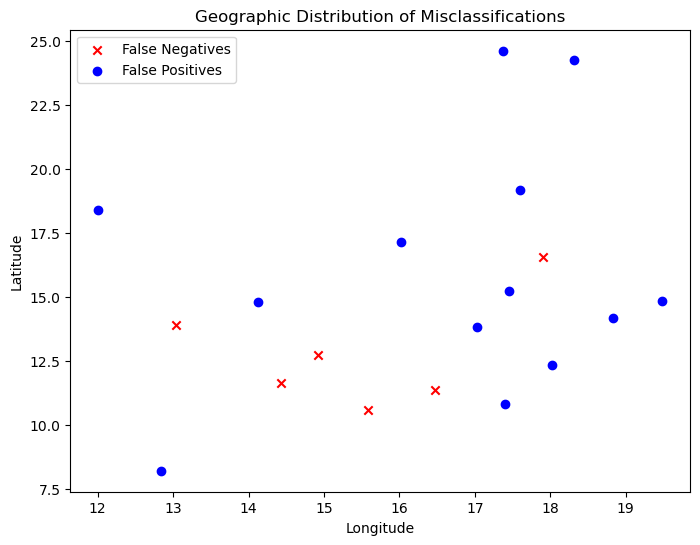

In [105]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(lon_false_neg, lat_false_neg, marker='x', color='red', label='False Negatives')
plt.scatter(lon_false_pos, lat_false_pos, marker='o', color='blue', label='False Positives')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Distribution of Misclassifications')
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(lons_false_neg, lats_false_neg, color='red', marker='x', label='False Negatives')
plt.scatter(lons_false_pos, lats_false_pos, color='blue', marker='o', label='False Positives')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Distribution of Misclassifications')
plt.legend()
plt.show()


In [106]:
print("Total samples:", len(sample_lat))
print("Unique latitudes:", len(np.unique(sample_lat)))
print("Unique longitudes:", len(np.unique(sample_lon)))


Total samples: 700
Unique latitudes: 700
Unique longitudes: 700


In [107]:
print("First 10 latitudes:", sample_lat[:10])
print("First 10 longitudes:", sample_lon[:10])


First 10 latitudes: [20.60745053 22.92874283 22.75682185 16.286706   21.65157051 23.769814
 25.29983151 15.40878142 23.29264832 20.25219614]
First 10 longitudes: [14.36303678 15.2017736  15.95271772 14.51583    11.41060704 13.73301446
 17.44799198 17.16743721 16.87077174 15.00467626]


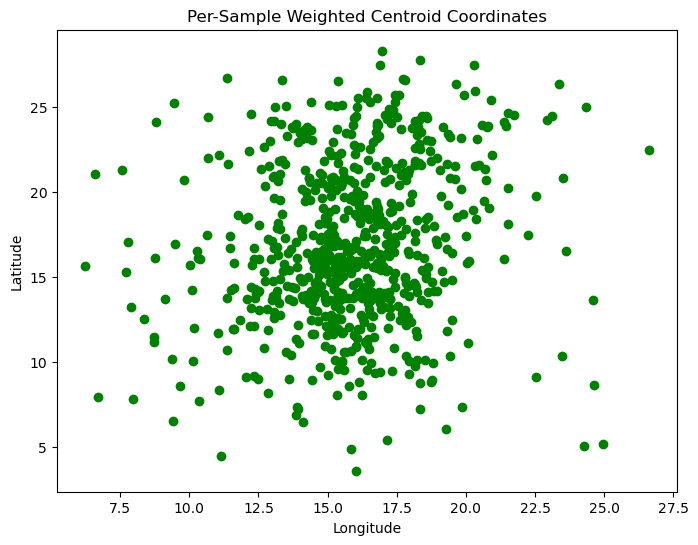

In [108]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(sample_lon, sample_lat, c='green', marker='o')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Per-Sample Weighted Centroid Coordinates')
plt.show()


In [27]:


# --- Permutation Importance ---
# Evaluate baseline performance using your loss metric (here, the custom f1_loss_sigmoid)
# model.metrics_names gives a list where index 0 is 'loss'
baseline_results = model.evaluate(input_test_scaled, label_test_scaled,
                                  batch_size=label_test_scaled.shape[0],
                                  verbose=0)
baseline_loss = baseline_results[model.metrics_names.index('loss')]
print("Baseline loss:", baseline_loss)

# Set the number of repetitions for averaging
n_repeats = 5
n_features = input_test_scaled.shape[-1]
permutation_importances = np.zeros(n_features)

# Loop over each feature (channel)
for feature_idx in range(n_features):
    permuted_losses = []
    for _ in range(n_repeats):
        # Copy the test set to avoid modifying the original
        X_permuted = np.copy(input_test_scaled)
        # Permute the values of the selected feature across samples
        perm = np.random.permutation(X_permuted.shape[0])
        X_permuted[:, :, :, feature_idx] = X_permuted[perm, :, :, feature_idx]
        
        # Evaluate the model on the permuted test set
        permuted_results = model.evaluate(X_permuted, label_test_scaled,
                                          batch_size=label_test_scaled.shape[0],
                                          verbose=0)
        permuted_loss = permuted_results[model.metrics_names.index('loss')]
        permuted_losses.append(permuted_loss)
    
    avg_permuted_loss = np.mean(permuted_losses)
    # The difference between the permuted loss and baseline loss indicates feature importance:
    # A larger increase means the feature is more important.
    permutation_importances[feature_idx] = avg_permuted_loss - baseline_loss
    print(f"Feature {feature_idx} - Increase in Loss: {permutation_importances[feature_idx]}")

print("Permutation Importances (increase in loss) for all features:", permutation_importances)


Baseline loss: 0.4705783724784851
Feature 0 - Increase in Loss: -0.018275028467178323
Feature 1 - Increase in Loss: -0.005778414011001598
Feature 2 - Increase in Loss: 0.004523545503616333
Feature 3 - Increase in Loss: 0.08117150664329531
Feature 4 - Increase in Loss: -0.008586376905441284
Feature 5 - Increase in Loss: 0.0392042934894562
Feature 6 - Increase in Loss: 0.0030174851417541504
Feature 7 - Increase in Loss: -0.029298615455627453
Feature 8 - Increase in Loss: -0.01373400688171389
Feature 9 - Increase in Loss: 0.014500242471694957
Feature 10 - Increase in Loss: 0.012628561258316018
Feature 11 - Increase in Loss: -0.027949023246765126
Feature 12 - Increase in Loss: 0.04461908936500547
Feature 13 - Increase in Loss: -0.04004896879196168
Feature 14 - Increase in Loss: -0.030080848932266258
Feature 15 - Increase in Loss: 0.001943993568420399
Feature 16 - Increase in Loss: -0.0008721888065338357
Feature 17 - Increase in Loss: -0.03540356159210206
Feature 18 - Increase in Loss: 0.04

Feature 1 - Increase in Loss: -0.005778414011001598


Feature 2 - Increase in Loss: 0.004523545503616333


Feature 3 - Increase in Loss: 0.08117150664329531


Feature 4 - Increase in Loss: -0.008586376905441284


Feature 5 - Increase in Loss: 0.0392042934894562


Feature 6 - Increase in Loss: 0.0030174851417541504


Feature 7 - Increase in Loss: -0.029298615455627453


Feature 8 - Increase in Loss: -0.01373400688171389


Feature 9 - Increase in Loss: 0.014500242471694957


Feature 10 - Increase in Loss: 0.012628561258316018


Feature 11 - Increase in Loss: -0.027949023246765126


Feature 12 - Increase in Loss: 0.04461908936500547


Feature 13 - Increase in Loss: -0.04004896879196168


Feature 14 - Increase in Loss: -0.030080848932266258


Feature 15 - Increase in Loss: 0.001943993568420399


Feature 16 - Increase in Loss: -0.0008721888065338357


Feature 17 - Increase in Loss: -0.03540356159210206


Feature 18 - Increase in Loss: 0.04032555818557737


Feature 19 - Increase in Loss: 0.005713945627212502


Feature 20 - Increase in Loss: 0.019231653213500954


Feature 21 - Increase in Loss: -0.0026014626026153453


Feature 22 - Increase in Loss: -0.005112624168395974


Feature 23 - Increase in Loss: -0.04010382890701292


Feature 24 - Increase in Loss: 0.008307617902755748
Permutation Importances (increase in loss) for all features: [-0.01827503 -0.00577841  0.00452355  0.08117151 -0.00858638  0.03920429
  0.00301749 -0.02929862 -0.01373401  0.01450024  0.01262856 -0.02794902
  0.04461909 -0.04004897 -0.03008085  0.00194399 -0.00087219 -0.03540356
  0.04032556  0.00571395  0.01923165 -0.00260146 -0.00511262 -0.04010383
  0.00830762]


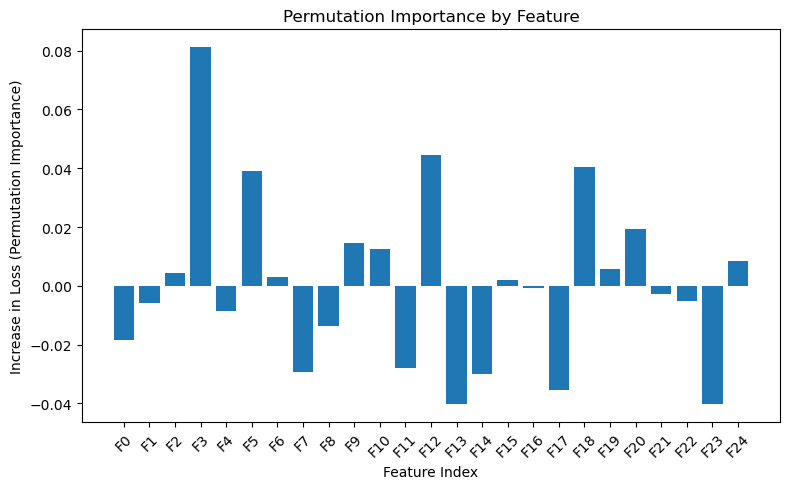

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Suppose permutation_importances is the numpy array you printed:
# e.g., [0.0820, 0.0824, 0.0815, 0.0864, 0.0121, ...]

feature_indices = np.arange(len(permutation_importances))

plt.figure(figsize=(8, 5))
plt.bar(feature_indices, permutation_importances)
plt.xlabel("Feature Index")
plt.ylabel("Increase in Loss (Permutation Importance)")
plt.title("Permutation Importance by Feature")
plt.xticks(feature_indices, [f"F{i}" for i in feature_indices], rotation=45)
plt.tight_layout()
plt.show()


In [ ]:


# Flatten predictions and true labels (assuming they are (N,1) arrays)
preds = np.round(predictions).flatten()
y_true = label_test_scaled.flatten()

# Find indices for false positives (true label 0 but predicted 1)
fp_indices = np.where((y_true == 0) & (preds == 1))[0]
# Find indices for false negatives (true label 1 but predicted 0)
fn_indices = np.where((y_true == 1) & (preds == 0))[0]


